In [1]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from scipy.interpolate import interp1d
from utils import *
import random
import pickle
from bokeh.plotting import figure, show
from itertools import groupby
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d, HoverTool

# Swisstech

Swisstech subcatchment gahthers the runoff to Rejet Convention Center.

### 1.1 Precipitation

The 10 min total precipitation data is downloaded from MeteoSwiss IDAWEB, with a unit of mm/10min.\
Lausanne station is chosen (LSN). This station is a part of Automatic Network.

In [2]:
with open('df_precp_st.pkl','rb') as f:
    df_precp_st = pd.read_pickle(f)
df_precp_st.head()

FileNotFoundError: [Errno 2] No such file or directory: 'df_precp_st.pkl'

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_precp_st.index, df_precp_st['rre150z0'])
ax.set_title("Rainfall")
ax.set_ylabel("Rainfall intensity (mm/10min)")

# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=8))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### 1.2 Discharge

What we got is meausred water level data (mm). We use formulat to convert water level to discharge ($m^3/s$). Please resort to utils.py. The resolution is from 15min to 5min. \
Original signal → denoised → denoised shifted → denoised shifted discharge

In [ ]:
with open('df_waterlevel_st.pkl', 'rb') as f:
    df_waterlevel = pickle.load(f)  
df_waterlevel.head()

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(9,9), sharey=True, sharex=True)
ax[0].plot(df_waterlevel.index, df_waterlevel['water level (mm)'])
ax[0].set_title('Original Water level')
ax[1].plot(df_waterlevel.index, df_waterlevel['denoised'])
ax[1].set_title('Denoised Water level')
ax[1].set_ylabel("Water level (mm)")
ax[2].plot(df_waterlevel.index, df_waterlevel['denoised_shift'])
ax[2].set_title('Denoised Shifted Water level')

# ax[2].xaxis.set_minor_locator(mdates.DayLocator(interval=3))
# ax[2].xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# plt.ylim((0,100))
plt.tight_layout()
plt.show()

In [ ]:
df_waterlevel['discharge_de_shift'] = df_waterlevel['discharge_de_shift'].fillna(0)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_waterlevel.index, df_waterlevel['discharge_de_shift'])
# ax.plot(df_waterlevel['TIME'], df_waterlevel['Simulation'], label='Simulation')
# ax.legend()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_ylabel('Water discharge ($m^3/s$)')
ax.set_title('Measured Discharge (Converted from Water Level)')

In [ ]:
# Output the plot inline in the notebook
output_notebook()
df1 = df_waterlevel.copy()
df1.reset_index()
# Convert DataFrame to ColumnDataSource for Bokeh
source1 = ColumnDataSource(df1)
# source2 = ColumnDataSource(df_test)

# Create a figure with a datetime x-axis
p = figure(x_axis_type="datetime", title="Measured", x_axis_label='Date', y_axis_label='Water discharge (L^3/s)', width=1000)
p.y_range = Range1d(0, np.max(df1['discharge_de_shift']+0.05))
# Plot the first column as a line
p.line('Date', 'discharge_de_shift', source=source1, legend_label="Discharge", line_width=3, color="blue")
p.extra_y_ranges = {"h": Range1d(start=0, end=np.max(df1['denoised_shift']+0.5))}
p.add_layout(LinearAxis(y_range_name="h", axis_label='Water level (mm)'), 'right')
p.line('Date', 'denoised_shift', source=source1, legend_label="Water level", line_width=1, color="green", y_range_name="h")

p.legend.location="top_left"
# Show the plot
show(p)

### 1.3 Hydrique

There are two kinds of Hydrique data: Stormwater (L/s) and Simulation (L/s). This model is quite mysterious.

In [ ]:
with open('df_hydrique_st.pkl', 'rb') as f:
    df_hydrique = pickle.load(f)
df_hydrique.head()

In [ ]:
df_hydrique['Stormwater'] = df_hydrique['Stormwater']/1000
df_hydrique['Simulation'] = df_hydrique['Simulation']/1000

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_hydrique['TIME'], df_hydrique['Stormwater'], label='Stormwater')
# ax.plot(df_hydrique['TIME'], df_hydrique['Simulation'], label='Simulation')
ax.legend()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_ylabel('Water discharge ($m^3/s$)')
# ax.set_title('Hydrique Model Performance')



In [ ]:
# Output the plot inline in the notebook
output_notebook()

# Convert DataFrame to ColumnDataSource for Bokeh
source1 = ColumnDataSource(df_hydrique)
# source2 = ColumnDataSource(df_test)

# Create a figure with a datetime x-axis
p = figure(x_axis_type="datetime", title="Hydrique Model", x_axis_label='Date', y_axis_label='Water discharge (L^3/s)')

# Plot the first column as a line
p.line('TIME', 'Stormwater', source=source1, legend_label="Stormwater (Runoff)", line_width=2, color="blue")

# Plot the second column as a line
p.line('TIME', 'Simulation', source=source1, legend_label="Simulation (Discharge)", line_width=2, color="green")
# p.line('TIME', 'Simulation 10min', source=source2, legend_label="Simulation rejet", line_width=1, color="red")
p.legend.location="top_left"
# Show the plot
show(p)


### 1.4 Wind

During calibration, we found that both measured discharge and Hydrique model has a delay (for Swisstech subcatchment about 2h) compared with the precipitation. One assumption is that EPFL rainfall has a delay compared with Lausanne rainfall and some rainfall amount was lost in the vapor transportation through wind. Therefore, we employ wind data (spped and direction) to do vector decompostion of precipitation, trying to explain the lag.

The wind data is from Lausanne station (NABLAU). Both features are in 10 min resolution (speed: km/h, direction: degree)


In [ ]:
with open("df_wind_st.pkl", "rb") as f:
    df_wind = pickle.load(f)

## 2. Data Integration

Merge into one dataframe to facilitate plotting.

In [2]:
with open("df_swstch.pkl", "rb") as f:
    df_swstch = pd.read_pickle(f)

In [3]:
df_swstch['Stormwater'] = df_swstch['Stormwater']/1000
df_swstch['Simulation'] = df_swstch['Simulation']/1000

In [4]:
df_swstch['discharge_de_shift'] = df_swstch['discharge_de_shift'].fillna(0)
df_swstch.head()


,time,precp,water level (mm),discharge_raw,denoised,discharge_org,discharge_de,denoised_shift,discharge_de_shift,Stormwater,Simulation,windspeed_m/s,windspeed_km/h,winddirection
0,2024-07-17 00:15:00,0.0,18.000000,0.164000,18.280809,0.000366,0.000379,4.369709,0.000016,0.000042,0.012329,0.4,1.4,254.5
1,2024-07-17 00:20:00,0.0,18.666667,0.170067,18.745464,0.000396,0.000400,4.834364,0.000021,0.000042,0.012135,0.4,1.4,288.0
2,2024-07-17 00:25:00,0.0,19.333333,0.176133,19.138208,0.000428,0.000418,5.227109,0.000025,0.000042,0.011953,0.5,1.8,295.0
3,2024-07-17 00:30:00,0.0,20.000000,0.182200,19.637061,0.000460,0.000442,5.725962,0.000030,0.000041,0.011771,0.6,2.2,302.0
4,2024-07-17 00:35:00,0.0,19.000000,0.173067,19.066878,0.000412,0.000415,5.155779,0.000024,0.000041,0.011646,0.6,2.2,302.0


## 3. Initial Parameters

### 3.1 Fixed parameter

We don't do sensitivity analysis on fixed parameters.

In [5]:
# [mare foret paturage prairie gazon-fleuri pelouse grille-gazon gravier mineral-compacte]
omegas_st = np.array([0, 0, 0, 2236.43, 1701.78, 0, 0, 0, 0])
# [platform, surface-impermeable]
omega0_st = np.array([5141.19, 6962.80])
# [tank-like roof, roof]
omegat_st = np.array([6225.88, 6035.83]) 


omegaSoil = sum(omegas_st)
omegaRoof = sum(omegat_st)


area_tt = sum(omega0_st) + sum(omegas_st) + sum(omegat_st)
imper = area_tt - sum(omegas_st)
omegaSoil

3938.21

TODO: 加一个饼图

### TODO: 3.2 Soil characteristics

TODO: Change the parameter according to the report: soil texture, rooting depth, infiltration rate.

Assumption: The soil in the same subcatchment is uniform.

Therefore: The following parameters can be modified.

Further: Change Emax according to temperature.

In [6]:
soil = dict()
texture=["sand", "loamy sand", "sandy loam", "loam", "clay"]
for t in texture:
    soil[t] = dict()

In [7]:
soil['sand'] = {"Ks":500, "n":0.35, "beta":12.1, "sh":0.08, "sw":0.11, "ss":0.33, "sfc":0.35}
soil['loamy sand'] = {"Ks":100, "n":0.42, "beta":12.7, "sh":0.08, "sw":0.11, "ss":0.31, "sfc":0.52}
soil['sandy loam'] = {"Ks":80, "n":0.43, "beta":13.8, "sh":0.14, "sw":0.18, "ss":0.46, "sfc":0.56}
soil['loam'] = {"Ks":20, "n":0.45, "beta":14.8, "sh":0.19, "sw":0.24, "ss":0.57, "sfc":0.65}
soil['clay'] = {"Ks":1, "n":0.5, "beta":26.8, "sh":0.47, "sw":0.52, "ss":0.78, "sfc":0.99}

In [8]:
n = 0.45          # porosity 
Z_root = 140
Z_soil = n * Z_root  # grass root depth[cm]
E_max = 0.5             #maximum evapotranspiration for grass[cm/day]
E_w = E_max / 8        # evapotraspiration at soil wilting point [cm/day]
beta = 14.8            # soil characteristics
s_h = 0.19 
s_w = 0.24
s_s = 0.57
s_fc = 1
Ks = 20         # saturated hydraulic conductivity [cm/day]
Kc = 2 #crop coefficient


eta_w = E_w / Z_soil;   # normalized maximum evapotranspiration [-/day]
eta = E_max / Z_soil
m = Ks / (Z_soil * (np.exp(beta * (1 - s_fc)) - 1)) if (s_fc != 1) else Ks / Z_soil

### 3.3 Other Parameters

For the 3rd reservoir, more parameters are added in. We'll discuss later.

In [9]:
k = 100 #[/day] Time constant
rf2s = 0.5 # meaning half of the rain falling on the roof will go to the soil. the proportion of rainfall on the roof that will go to the soil. Initial value is 0.5 but I try other values

## 4. Model Calibration

### 4.1 Baseline model

Half of the rainfall on the roof will go to the soil.

No interception. Emax doesn't rely on temperature.

In [10]:
def model_st(df, k=90, frac_rt2s=0.5, frac_rt2tk=0.5, Z_root=140, E_max=0.5, E_w=0.0625, heavy=55/600000, soiltype="loamy sand",\
        omegaSoil=sum(omegas_st), omegaRoad=sum(omega0_st), omegaRoof=sum(omegat_st), Vmax=10, lag=0, resolution=5, Qirr = omegaSoil*E_max/(100*86400),flushing_frequency=2):
    
    rain = df['precp'].fillna(0)
    rain_lag = rain if lag==0 else np.concatenate((np.zeros(lag), rain[:-lag]))
    df['time'] = pd.to_datetime(df['time'], format='%d.%m.%Y %H:%M')
    Kc = df['time'].dt.month.apply(lambda x: 1 if x in [12, 1, 2, 9, 10, 11] else 2)


    # Soil parameters
    Ks = soil[soiltype]['Ks']
    n = soil[soiltype]['n']
    beta = soil[soiltype]['beta']
    s_h = soil[soiltype]['sh']/soil[soiltype]['sfc']
    s_w = soil[soiltype]['sw']/soil[soiltype]['sfc']
    s_s = soil[soiltype]['ss']/soil[soiltype]['sfc']
    s_fc = soil[soiltype]['sfc']/soil[soiltype]['sfc']
    
    # Initialization
    
    y0 = [0, s_s, 0 , 0]
    y_result = np.zeros((df.shape[0], 4)) #increased to 4 for roof vector (index: 0 for Road, 1 for Soil, 2 for Roof, 3 for Tank)
    y_result[0] = y0
    dydt = np.zeros(4) #increased to 4 for roof vector
    Qsoil = np.zeros(df.shape[0])
    Qpolicy_irr = np.zeros(df.shape[0])
    Vpolicy_flush = np.zeros(df.shape[0])
    
    Qout = np.zeros(df.shape[0])
    Qroad = np.zeros(df.shape[0])
    Qroof = np.zeros(df.shape[0])
    Qtank = np.zeros(df.shape[0])
    Vroad = np.zeros(df.shape[0])
    Vroof = np.zeros(df.shape[0])
    Vtank = np.zeros(df.shape[0])

    steps_per_hour = 60 / resolution  # Number of time steps per hour
    lam = flushing_frequency / steps_per_hour  # Poisson mean

    for i in range(df.shape[0] - 1):
        p = rain_lag[i] / (1000 * 60 * resolution)  # Convert from mm/5min to m/s
        pm = p  # Modeled precipitation
        
        # Sample from a Poisson distribution (flush count per time step)
        flushing = np.random.poisson(lam)

    
        #============ Qsoil ===============#
        if y_result[i,1] >= s_fc:
            Qsoil[i] = p * omegaSoil
        elif p>heavy:
            Qsoil[i] = (p-heavy)*omegaSoil
        else:
            Qsoil[i] = 0

        #============ Qroad ===============#
        Qroad[i] = k * y_result[i,0]*omegaRoad / 86400 # Water flow at time point i the k should be different in roads and roofs
        Vroad[i] = y_result[i,0] * omegaRoad # Water volume of Road reservoir at time point i
        #Qroad[i] = k * V_runoff[i]  # Turn k [/day] to k [/s]

        #============ Qroof ===============#
        Vroof[i] = y_result[i, 2] * (1-frac_rt2tk) * omegaRoof
        Qroof[i] = k * y_result[i,2] * (1-frac_rt2tk) * omegaRoof / 86400 # Water flow at time point i
        
        

        #==============Road reservoir==========#
        dydt[0] = pm + (Qsoil[i] - Qroad[i]) / omegaRoad  #roof, tank and roads use pm (modeled precipitation)
        
        y_result[i+1, 0] = y_result[i, 0] + dydt[0]*60*resolution
        if y_result[i+1, 0] < 0:
            y_result[i+1, 0] = 0


        #==============Tank reservoir==========#
        Qpolicy_irr[i] = Kc[i]*Qirr if (pm == 0 and y_result[i,1] < s_fc-0.1 and y_result[i, 3] >= Kc[i]*Qirr*resolution*60 )  else 0
        Vpolicy_flush[i] = flushing*0.02 if (y_result[i, 3] > 0.02*flushing) else y_result[i, 3] # multiply by random 0 or 1
        
        if frac_rt2tk != 0:
            # Calculate inflow and outflows
            dydt[3] = pm * (frac_rt2tk * omegaRoof) - (Qtank[i] + Qpolicy_irr[i])
            y_result[i+1, 3] = y_result[i, 3] - Vpolicy_flush[i] + dydt[3] * 60 * resolution

            # Ensure tank volume is non-negative
            if y_result[i+1, 3] < 0:
                y_result[i+1, 3] = 0

    # Check for overflow
            if y_result[i+1, 3] >= Vmax:
                Qtank[i] = (y_result[i+1, 3] - Vmax) / (60 * resolution)  # Overflow rate
                y_result[i+1, 3] = Vmax
            else:
                Qtank[i] = 0
        else:
            dydt[3] = 0
            y_result[:, 3] = 0
 
        #==============Roof reservoir==========#
        dydt[2] = pm - Qroof[i]/ ( (1-frac_rt2tk) * omegaRoof) if frac_rt2tk != 1 else 0 #roof, tank and roads use pm (modeled precipitation)
        
        y_result[i+1, 2] = y_result[i, 2] + dydt[2]*60*resolution
        if y_result[i+1, 2] < 0:
            y_result[i+1, 2] = 0
            
        #==============Soil reservoir==========#
        Z_soil = n*Z_root
        dydt[1] = (p+Qpolicy_irr[i]/omegaSoil) / (Z_soil / 100) \
                 - rho(y_result[i, 1],n, Z_root, E_max, E_w, beta, s_h, s_w, s_s, s_fc, Ks) / 86400 #(1+(1-frac_rt2tk)*frac_rt2s*omegat/omegas)

        y_result[i+1, 1] = y_result[i, 1] + dydt[1]*60*resolution
        if y_result[i+1, 1] >=1:
            y_result[i+1, 1] = 1
    
        #============ Qout ===============#
        Qout[i] = Qroad[i] + Qroof[i] + Qtank[i] # Total outflow at time point i

    
    df_return = df.copy()
    df_return['Qout'] = Qout 
    df_return['Qroad'] = Qroad
    df_return['Qroof'] = Qroof
    df_return['Qsoil'] = Qsoil
    df_return['Qtank'] = Qtank
    df_return['Qirr'] = Qpolicy_irr
    df_return['Vflush'] = Vpolicy_flush
    df_return['soil_mois'] = y_result[:,1]
    df_return['v_tank'] = y_result[:,3]

    return df_return

In [11]:
lagging = 0
k_st = 60 #60
df_st_base = model_st(df_swstch, k=k_st, lag=lagging)

#### Yacine, with new data

In [13]:
df_triades = pd.read_pickle('df_triades.pkl')
df_pluviometer = pd.read_pickle('pluviometer.pkl')


df_pluviometer = df_pluviometer.rename(columns={"Cumul de pluviomètrie [0] (mm)": "precp"})
df_pluviometer = df_pluviometer.rename(columns={"Date": "time"})


df_model_pluvio = model_st(df_pluviometer, k=k_st, lag=lagging,Vmax=100)

df_model_pluvio.head()

# Save as pkl to compare

# Save df_triades as a pickle file
df_model_pluvio.to_pickle('df_model_pluvio.pkl')


In [19]:
df_pluviometer

,Date,Sn,Name,Compteur[0] (22[0]),precp
0,01.11.2024 00:04,IJA0102-00009933,Pluvio_Gr,0,0.0
1,01.11.2024 00:09,IJA0102-00009933,Pluvio_Gr,0,0.0
2,01.11.2024 00:14,IJA0102-00009933,Pluvio_Gr,0,0.0
3,01.11.2024 00:19,IJA0102-00009933,Pluvio_Gr,0,0.0
4,01.11.2024 00:24,IJA0102-00009933,Pluvio_Gr,0,0.0
...,...,...,...,...,...
7345,26.11.2024 12:09,IJA0102-00009933,Pluvio_Gr,0,0.0
7346,26.11.2024 12:14,IJA0102-00009933,Pluvio_Gr,0,0.0
7347,26.11.2024 12:19,IJA0102-00009933,Pluvio_Gr,0,0.0
7348,26.11.2024 12:24,IJA0102-00009933,Pluvio_Gr,0,0.0


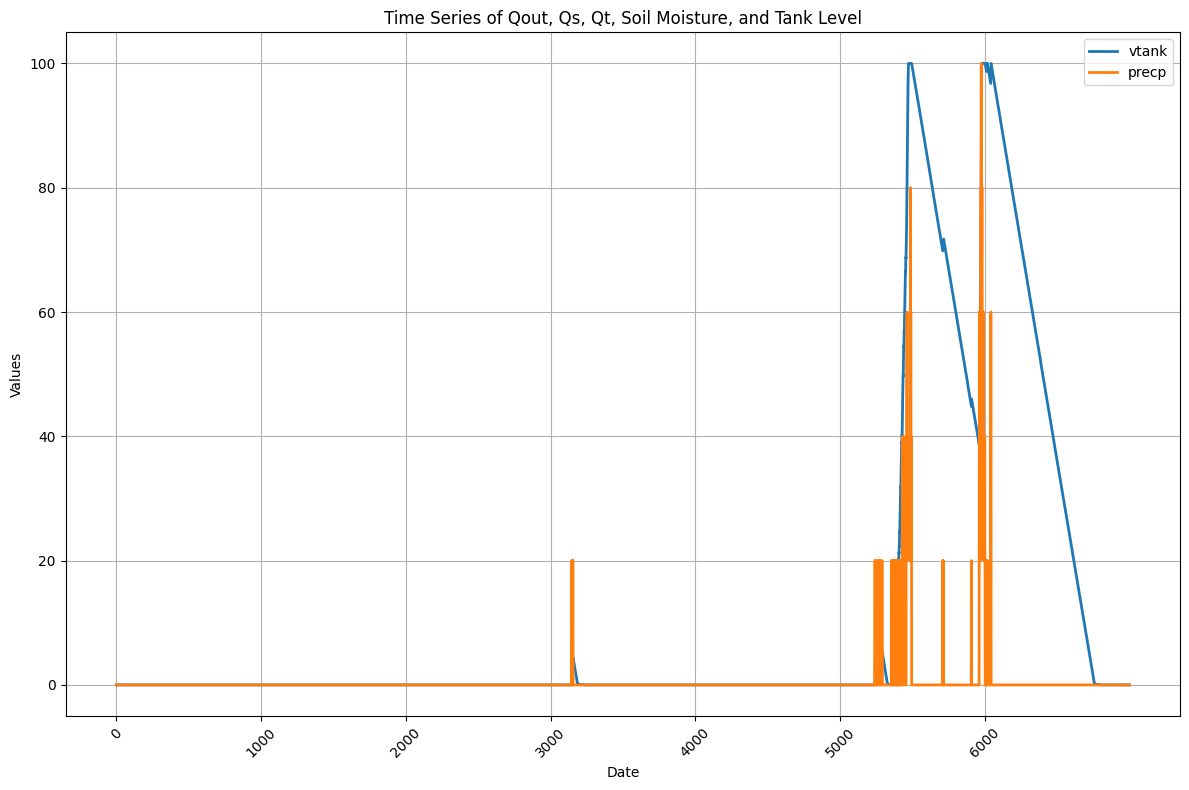

In [24]:
# Plot the results

import matplotlib.pyplot as plt

start = 0
end = 7000

# Set the 'Date' column as the x-axis
plt.figure(figsize=(12, 8))

# Plot each variable
#plt.plot(df_model_pluvio.index[start:end], df_model_pluvio['Qsoil'][start:end], label='Qsoil', linewidth=2)
#plt.plot(df_model_pluvio.index, df_model_pluvio['Qtank'], label='Qtank', linewidth=2)
#plt.plot(df_model_pluvio.index[start:end], df_model_pluvio['Qirr'][start:end], label='Qirr', linewidth=2)
#plt.plot(df_model_pluvio.index[start:end], df_model_pluvio['Vflush'][start:end], label='Vflush', linewidth=1)
plt.plot(df_model_pluvio.index[start:end], df_model_pluvio['v_tank'][start:end], label='vtank', linewidth=2)
plt.plot(df_model_pluvio.index[start:end],df_pluviometer['precp'][start:end]*100,label = 'precp',linewidth = 2)
#plt.plot(df_pluvio_2.index,df_pluvio_2['precp'],label = 'precp2',linewidth = 1)
#plt.plot(df_model_pluvio.index[start:end],df_model_pluvio['soil_mois'][start:end],label = 'soil moisture',linewidth = 1)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Qout, Qs, Qt, Soil Moisture, and Tank Level')
plt.xticks(df_model_pluvio.index[start:end:1000], rotation=45)  # Show every 1000th date
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

#np.sum(df_model_pluvio['Qout'][:7000])

#### Tank Statistics

In [12]:
def calculate_tank_statistics_with_overflow(df,df_model ,Vmax, time_step):
    """
    Calculate tank statistics based on overflow events.
    
    Parameters:
        y_result (numpy.ndarray): Tank volumes over time (array of size [time_steps, 4]).
                                  Tank volume is assumed to be in the 4th column (index 3).
        Vmax (float): Maximum tank volume.
        Qtank (numpy.ndarray): Overflow flow rates over time (array of size [time_steps]).
        time_step (float): Duration of each time step in seconds (e.g., 300 for 5 minutes).
    
    Returns:
        dict: A dictionary containing tank statistics.
    """
    # Extract the tank volume over time
    tank_volumes = df_model['v_tank']

    # Number of precipitation event 

    non_zero_precp = (df['precp'] != 0).sum()

    # Define failure as when the tank is at its maximum  capacity
    failures = df_model['Qtank'] != 0

    # Calculate failure metrics
    total_time_steps = non_zero_precp
    total_failure_time_steps = np.sum(failures)
    failure_rate = total_failure_time_steps*100/non_zero_precp

    # Calculate total overflow volume
    total_overflow_volume = np.sum(df_model['Qtank'] * time_step)


    # Ensure `failures` is a boolean array
    failures = (df_model['Qtank'] != 0).to_numpy()  # Example of converting to boolean array
    failure_durations = []
    
    # Group consecutive failures
    for key, group in groupby(failures):
        if key:  # Only consider groups where key == True (failures)
            failure_durations.append(len(list(group)))
    
    # Convert failure durations from steps to time (seconds)
    failure_durations_time = [duration * time_step/3600 for duration in failure_durations]
    
    # Calculate average failure duration
    avg_failure_duration = np.mean(failure_durations_time)if failure_durations_time else 0
    var_failure = np.var(failure_durations_time) if failure_durations_time else 0
    
    # Debug outputs
    #print("Failure durations (steps):", failure_durations)
    #print("Failure durations (hours):", failure_durations_time)
    #print("Average failure duration (hours):", avg_failure_duration)


    # Failure intervals (time between failures)
    failure_start_times = np.where(np.diff(failures.astype(int)) == 1)[0] * time_step
    failure_end_times = np.where(np.diff(failures.astype(int)) == -1)[0] * time_step
    failure_intervals = np.diff(failure_start_times) if len(failure_start_times) > 1 else []

    # Create results dictionary
    stats = {
        "total_time_steps_rain": total_time_steps,
        "total_failure_time_steps": total_failure_time_steps,
        "failure_rate": round(failure_rate,2),  # Fraction of time tank overflows
        "failure_durations (hours)": [round(duration, 2) for duration in failure_durations_time],
        "avg_failure_duration (hours)": round(avg_failure_duration,2),
        "variance_failure_duration (hours^2)": round(var_failure,3),
        "total_overflow_volume": round(total_overflow_volume,2),  # Total volume overflowed
    }

    return stats


In [14]:
# Calculate statistics
stats = calculate_tank_statistics_with_overflow(df_pluviometer,df_model_pluvio, 50, 300)

# Print statistics
print("Tank Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

NameError: name 'calculate_tank_statistics_with_overflow' is not defined

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_failure_rate(df, model_st, k_st, lagging, Vmax_values, time_step,fraction,flushing_frequency):
    """
    Calculate the failure rate of the tank for different Vmax values.
    
    Parameters:
        df_pluviometer (DataFrame): Input precipitation data.
        model_st (function): The tank model function.
        k_st (float): Time constant for the model.
        lagging (int): Lag parameter for the model.
        Vmax_values (list or array): Different Vmax values to test.
        time_step (float): Time step duration in seconds.
    
    Returns:
        dict: Dictionary with Vmax as keys and failure rates as values.
    """
    failure_rates = {}
    
    for Vmax in Vmax_values:

        #look the number of steps where precp different than 0
        
        non_zero_precp = (df['precp'] != 0).sum()

        # Run the model with the current Vmax
        df_model = model_st(df, k=k_st,frac_rt2tk = fraction, lag=lagging, Vmax=Vmax,resolution=time_step/60,flushing_frequency=flushing_frequency)
        
        # Extract tank volume and check failures
        #tank_volumes = df_model['v_tank']

        # Define failure as when the tank is at its maximum capacity
        failures = (df_model['Qtank'] != 0).sum()
        
        # Calculate failure rate
        #total_time_steps = len(tank_volumes)
        #total_failure_time_steps = np.sum(failures)
        failure_rate = failures*100 / non_zero_precp # in percent
        
        # Store the failure rate
        failure_rates[Vmax] = failure_rate
    
    return failure_rates

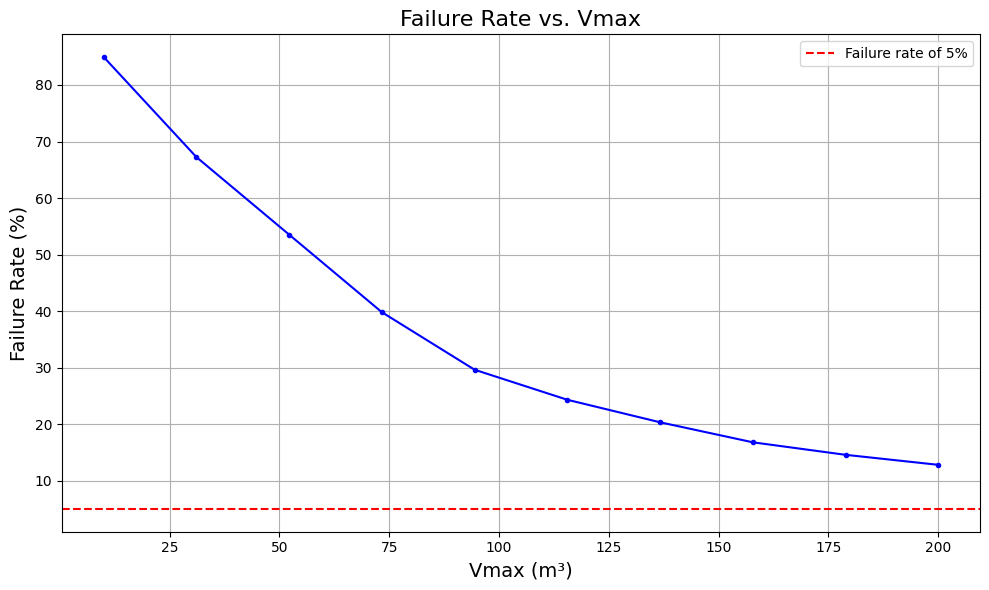

In [27]:
# Example usage
time_step = 300  # 5-minute intervals in seconds

# Define a range of Vmax values to test
Vmax_values = np.linspace(10, 200, 10)  # Test Vmax from 10 to 100 in 10 steps
flushing_frequency = 10

# Call the function
failure_rates = calculate_failure_rate(df_pluviometer, model_st, 90, lagging, Vmax_values, time_step,0.5,10)

# Plot failure rates vs. Vmax
plt.figure(figsize=(10, 6))
plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', color='blue')
plt.title("Failure Rate vs. Vmax", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

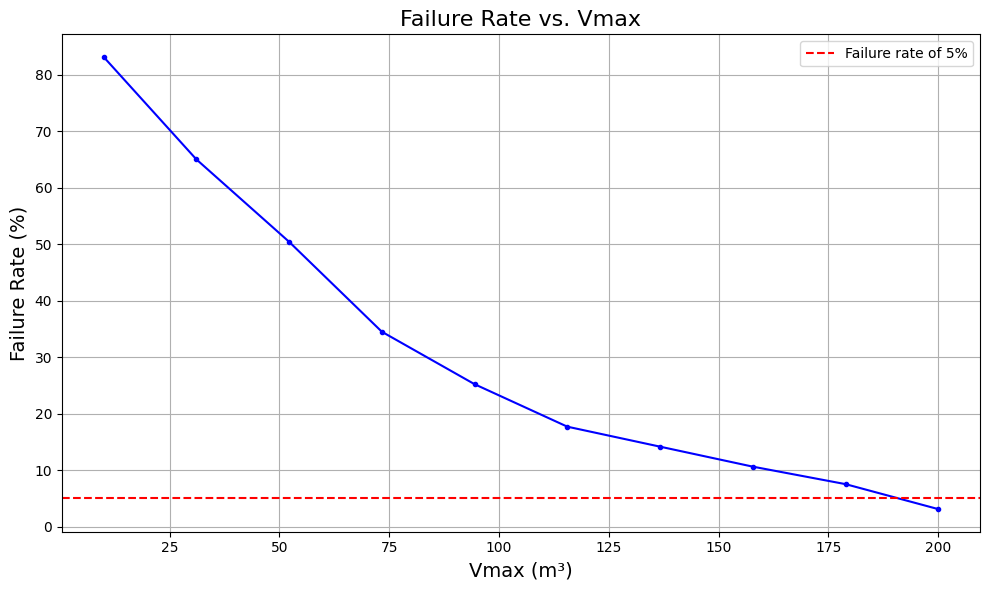

In [32]:
# Example usage
time_step = 300  # 5-minute intervals in seconds

# Define a range of Vmax values to test
Vmax_values = np.linspace(10, 200, 10)  # Test Vmax from 10 to 100 in 10 steps
flushing_frequency = 10

# Call the function
failure_rates = calculate_failure_rate(df_pluviometer, model_st, 90, lagging, Vmax_values, time_step,0.5,10)

# Plot failure rates vs. Vmax
plt.figure(figsize=(10, 6))
plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', color='blue')
plt.title("Failure Rate vs. Vmax", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def calculate_failure_rate_for_fractions(df, model_st, k_st, lagging, Vmax_values, time_step, fractions,flushing_frequency):
    """
    Calculate failure rates for multiple tank volumes and fractions of roof-to-tank flow.

    Parameters:
        df (DataFrame): Input precipitation data.
        model_st (function): The tank model function.
        k_st (float): Time constant for the model.
        lagging (int): Lag parameter for the model.
        Vmax_values (list or array): Different Vmax values to test.
        time_step (float): Time step duration in seconds.
        fractions (list or array): Different values of frac_rt2tk to test.
    
    Returns:
        dict: Dictionary with frac_rt2tk as keys, each containing a dictionary of Vmax vs failure rate.
    """
    results = {}
    
    for frac_rt2tk in fractions:
        failure_rates = {}
        for Vmax in Vmax_values:
            # Look at the number of steps where precipitation is non-zero
            non_zero_precp = (df['precp'] != 0).sum()

            # Run the model with the current Vmax and fraction
            df_model = model_st(df, k=k_st, frac_rt2tk=frac_rt2tk, lag=lagging, Vmax=Vmax,flushing_frequency = flushing_frequency)
            
            # Extract tank volume and check failures
            failures = df_model['Qtank'] != 0  # Overflow is when Qtank is non-zero
            
            # Calculate failure rate
            total_failure_time_steps = np.sum(failures)
            failure_rate = total_failure_time_steps * 100 / non_zero_precp  # In percent
            
            # Store the failure rate for this Vmax
            failure_rates[Vmax] = failure_rate
        
        # Store results for this fraction
        results[frac_rt2tk] = failure_rates
    
    return results

In [ ]:
# Example usage
time_step = 300  # 5-minute intervals in seconds
Vmax_values = np.linspace(10, 250, 30)  # Test Vmax from 10 to 120 in 10 steps
fractions = np.linspace(0.1, 1, 10)  # Test frac_rt2tk from 0.1 to 1.0 in 10 steps
flushing_frequency = 2

# Call the function

results = calculate_failure_rate_for_fractions(df_pluviometer, model_st, 90, lagging, Vmax_values, time_step, fractions,flushing_frequency)
# Plot results
plt.figure(figsize=(12, 8))
for frac_rt2tk, failure_rates in results.items():
    plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', label=f"frac_rt2tk={frac_rt2tk:.1f}")

plt.title("Failure Rate vs. Vmax for Different Fractions", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
#triades2 = pd.read_pickle('triades2.pkl')
#df_pluvio_2 = pd.read_pickle('pluvio_2.pkl')


#df_pluvio_2 = df_pluvio_2.rename(columns={"Cumul de pluviomÃ©trie[0] (mm)": "precp"})

#df_pluvio_2['precp'] = pd.to_numeric(df_pluvio_2['precp'], errors='coerce')

df_model_2 = model_st(df_pluvio_2, k=k_st, lag=lagging)

df_model_2.head()

# Save as pkl to compare

# Save df_triades as a pickle file
df_model_2.to_pickle('df_model_2.pkl')

#### Calibration

In [20]:
# We substract the offset

triades2 = pd.read_pickle('triades2.pkl')

shift = np.mean(triades2['Flow Rate (Qp)'][600:1600])

triades2['Flow Rate (Qp)'] = triades2['Flow Rate (Qp)'] - shift


In [22]:
# k = 60

modeled = df_model_opti['Qout']
measured = triades2['Flow Rate (Qp)']

# Calculate the Mean Squared Error
mse = np.mean((modeled - measured) ** 2)

print(f"Mean Squared Error (MSE): {mse:.6e}")

Mean Squared Error (MSE): 1.383158e-06


In [27]:
num_iterations = 200
k_opt = np.zeros(num_iterations)
MSE = np.zeros(num_iterations)

measured = triades2['Flow Rate (Qp)']

k_opt[0] = 0  # Valeur initiale de k

# Boucle pour calculer MSE pour différentes valeurs de k
for i in range(num_iterations):
    df_calibration = model_st(df_pluvio_2, k=k_opt[i], lag=lagging,frac_rt2tk=0.00001)
    qout = df_calibration['Qout']
    MSE[i] = np.mean((qout - measured) ** 2) # Calcul de la MSE
    
    # Mettre à jour k, sauf à la dernière itération
    if i < num_iterations - 1:
        k_opt[i+1] = k_opt[i] + 1

# Résultat final
min_MSE = np.min(MSE)  # MSE minimale
best_k = k_opt[np.argmin(MSE)]  # k correspondant à la MSE minimale

# Affichage des résultats
print(f"Meilleure constante k : {best_k:.4f}")
print(f"Erreur quadratique moyenne minimale (MSE) : {min_MSE:.6e}")


Meilleure constante k : 84.0000
Erreur quadratique moyenne minimale (MSE) : 1.378651e-06


Plot saved as 'MSE_k.png'.


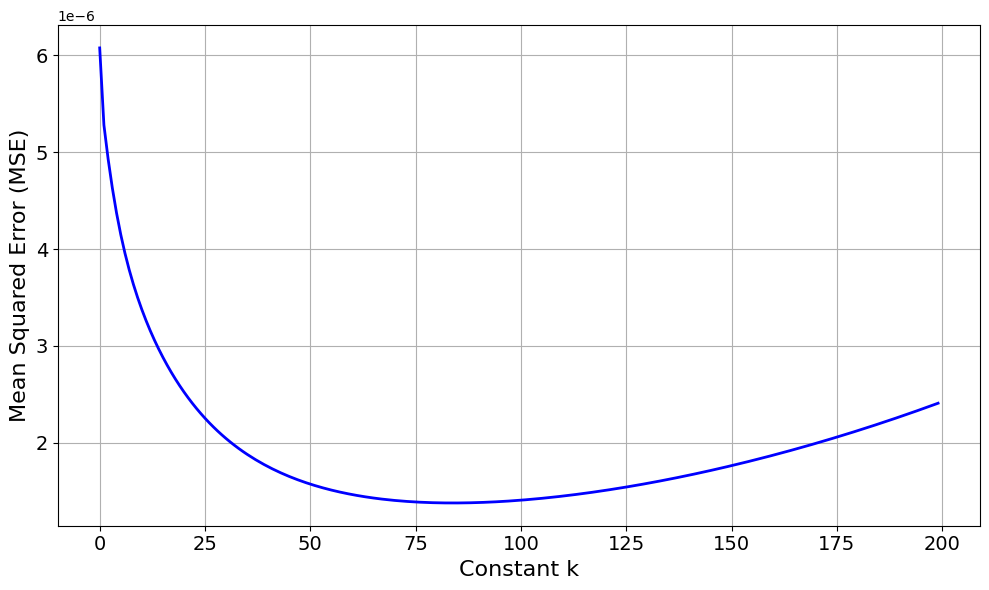

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(k_opt, MSE, label='MSE vs k', linewidth=2, color='blue')
plt.xlabel("Constant k", fontsize=16)
plt.ylabel("Mean Squared Error (MSE)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("plot/MSE_k.png", dpi=300)  # Save as PNG with high quality
print("Plot saved as 'MSE_k.png'.")
plt.show()


In [21]:
df_pluvio_2 = pd.read_pickle('pluvio_2.pkl')

df_pluvio_2 = df_pluvio_2.rename(columns={"precp": "original_precp"})
df_pluvio_2 = df_pluvio_2.rename(columns={"precp2" : "precp"})
df_pluvio_2 = df_pluvio_2.rename(columns={"Date" : "time"})

df_model_opti = model_st(df_pluvio_2, k=90, lag=lagging,frac_rt2tk=0.000001)

#### Plots

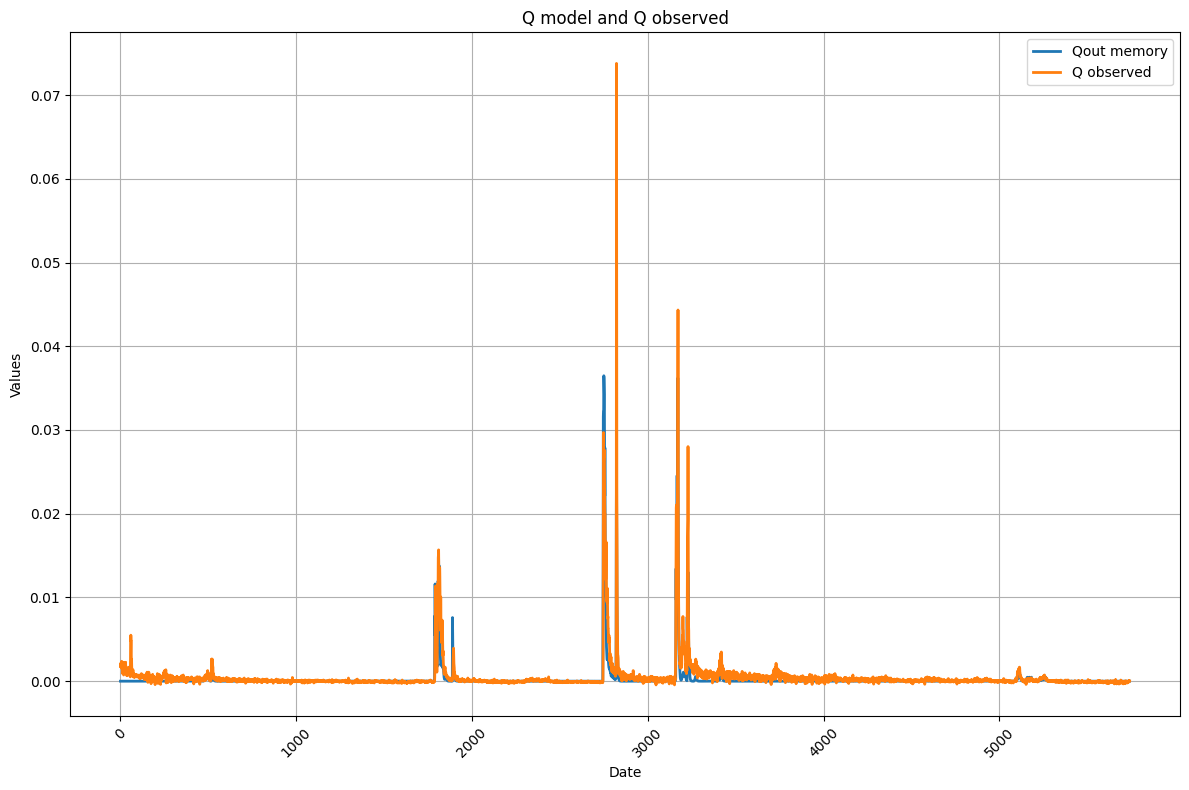

In [40]:
# Set the 'Date' column as the x-axis
plt.figure(figsize=(12, 8))

# Plot each variable
plt.plot(df_model_opti.index, df_model_opti['Qout'], label='Qout memory', linewidth=2)
plt.plot(triades2.index, triades2['Flow Rate (Qp)'], label='Q observed', linewidth=2)
#plt.plot(df_model_2.index, df_model_2['Qout'], label='Qout original', linewidth=2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Q model and Q observed')
plt.xticks(df_model_opti.index[::1000], rotation=45)  # Show every 1000th date
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


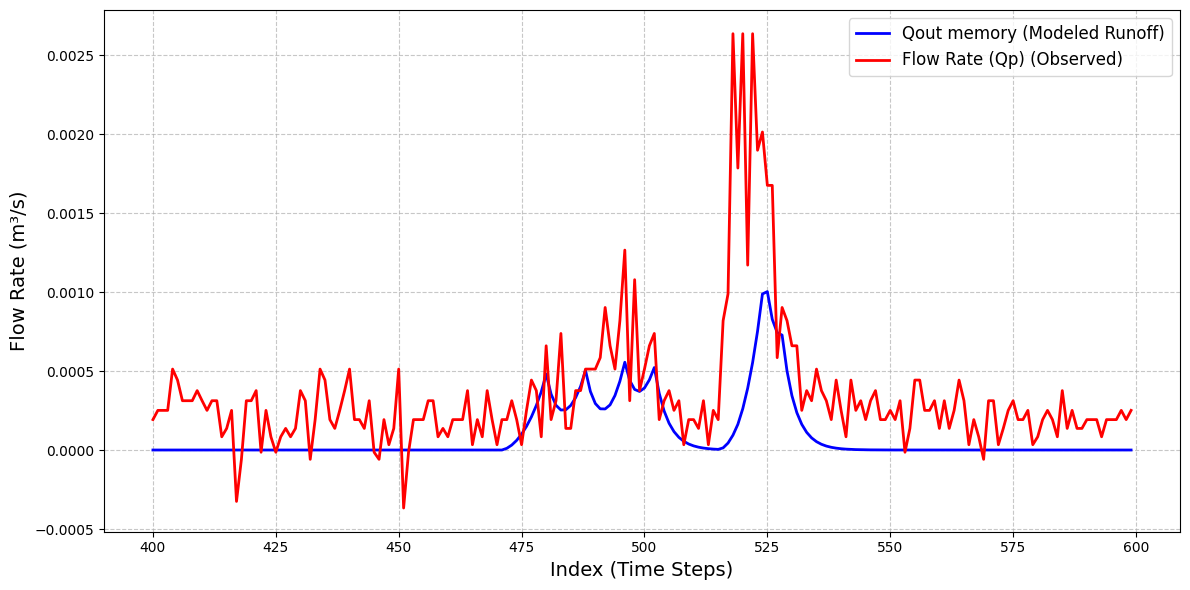

In [97]:
start = 400
end = 600

# Ensure both datasets have numeric indices
df_model_opti.reset_index(drop=True, inplace=True)
triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_opti.index[start:end], df_model_opti['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(triades2.index[start:end], triades2['Flow Rate (Qp)'][start:end], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
#plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
#plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('opti1.png', dpi=300)  # Save with 300 DPI for high quality
plt.show()

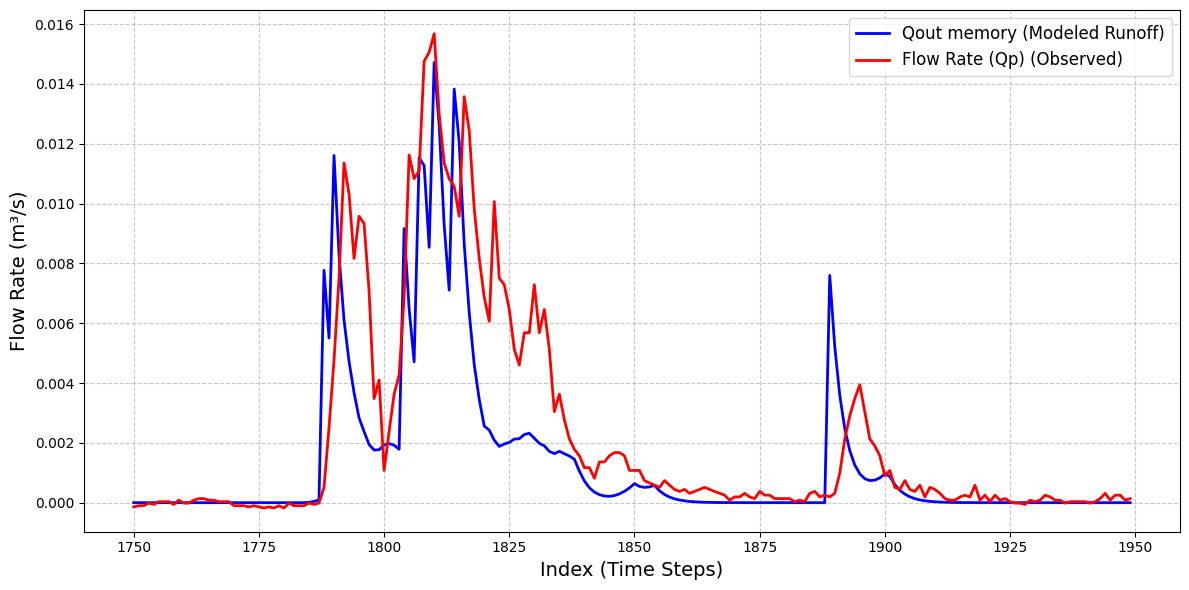

In [98]:
start = 1750
end = 1950

# Ensure both datasets have numeric indices
df_model_opti.reset_index(drop=True, inplace=True)
triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_opti.index[start:end], df_model_opti['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(triades2.index[start:end], triades2['Flow Rate (Qp)'][start:end], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
#plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
#plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('opti2.png', dpi=300)  # Save with 300 DPI for high quality
plt.show()

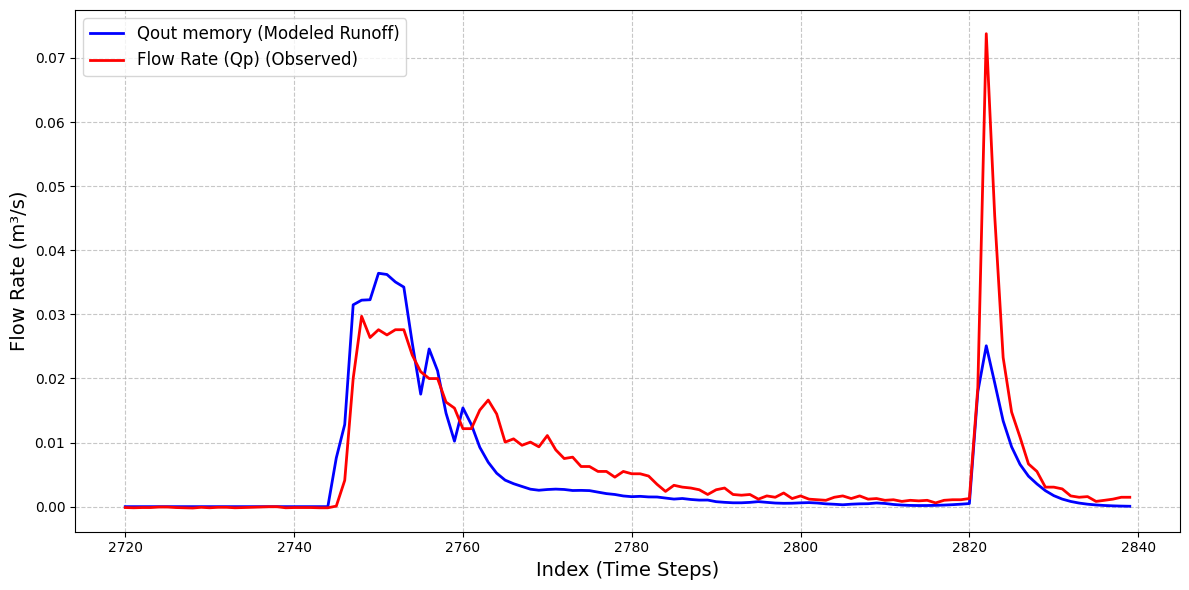

In [99]:
start = 2720
end = 2840

# Ensure both datasets have numeric indices
df_model_opti.reset_index(drop=True, inplace=True)
triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_opti.index[start:end], df_model_opti['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(triades2.index[start:end], triades2['Flow Rate (Qp)'][start:end], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
#plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
#plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('opti3.png', dpi=300)  # Save with 300 DPI for high quality
plt.show()

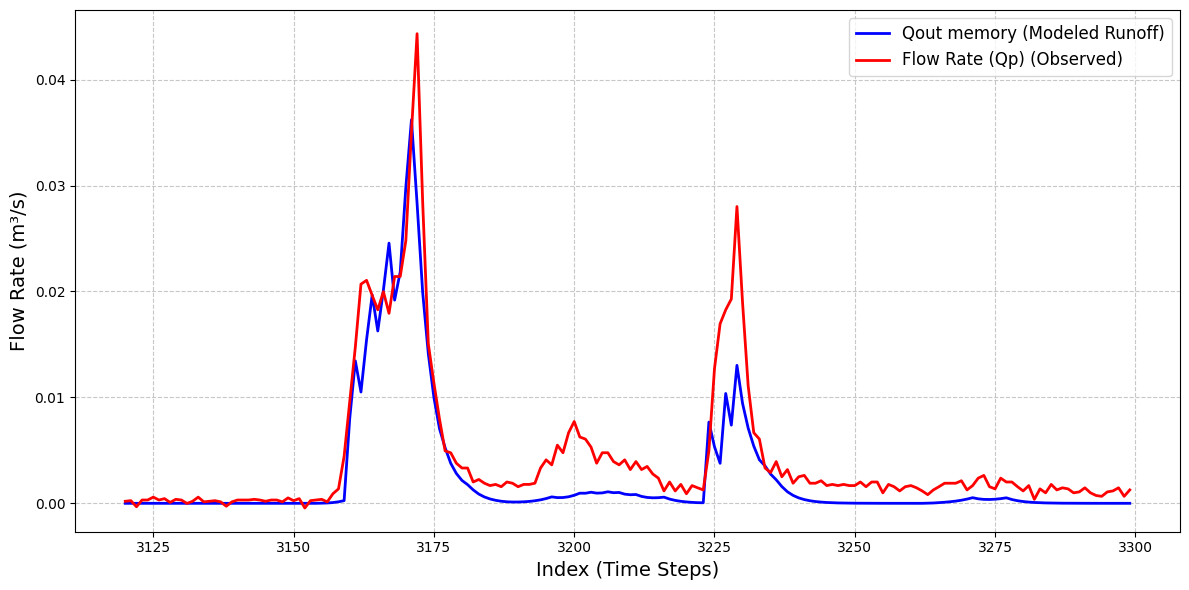

In [100]:
start = 3120
end = 3300

# Ensure both datasets have numeric indices
df_model_opti.reset_index(drop=True, inplace=True)
triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_opti.index[start:end], df_model_opti['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(triades2.index[start:end], triades2['Flow Rate (Qp)'][start:end], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
#plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
#plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('opti4.png', dpi=300)  # Save with 300 DPI for high quality
plt.show()

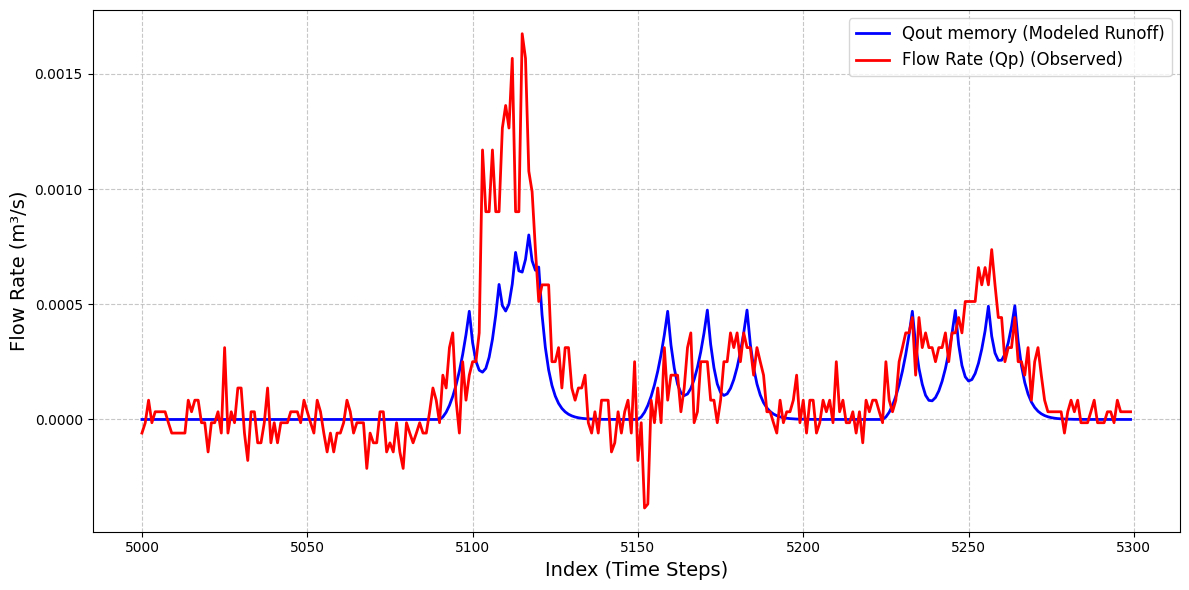

In [101]:
start = 5000
end = 5300

# Ensure both datasets have numeric indices
df_model_opti.reset_index(drop=True, inplace=True)
triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_opti.index[start:end], df_model_opti['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(triades2.index[start:end], triades2['Flow Rate (Qp)'][start:end], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
#plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
#plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('opti5.png', dpi=300)  # Save with 300 DPI for high quality
plt.show()

#### Tank Work on the memory rainfall

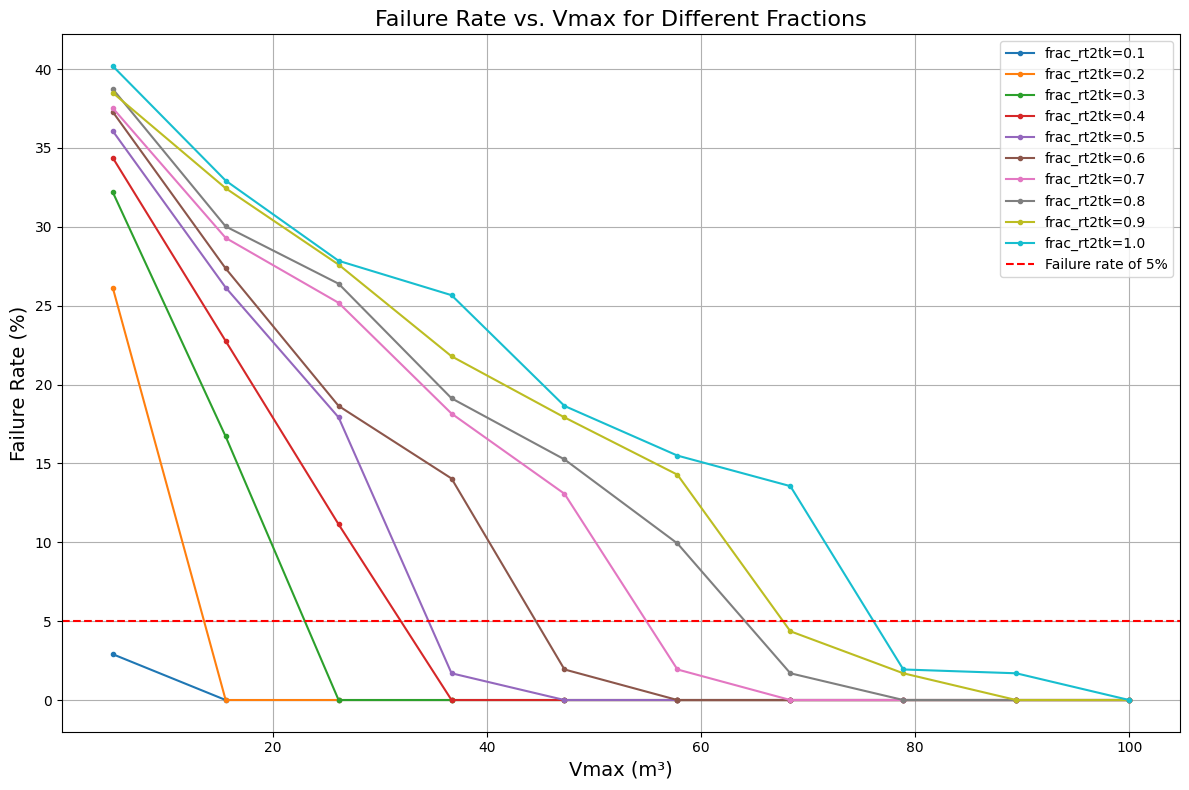

In [21]:
time_step = 300  # 5-minute intervals in seconds
Vmax_values = np.linspace(5, 100, 10)  # Test Vmax from 10 to 120 in 10 steps
fractions = np.linspace(0.1, 1, 10)  # Test frac_rt2tk from 0.1 to 1.0 in 10 steps
flushing_frequency = 2

results = calculate_failure_rate_for_fractions(df_pluvio_2, model_st, 90, lagging, Vmax_values, time_step, fractions,flushing_frequency)
# Plot results
plt.figure(figsize=(12, 8))
for frac_rt2tk, failure_rates in results.items():
    plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', label=f"frac_rt2tk={frac_rt2tk:.1f}")

plt.title("Failure Rate vs. Vmax for Different Fractions", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

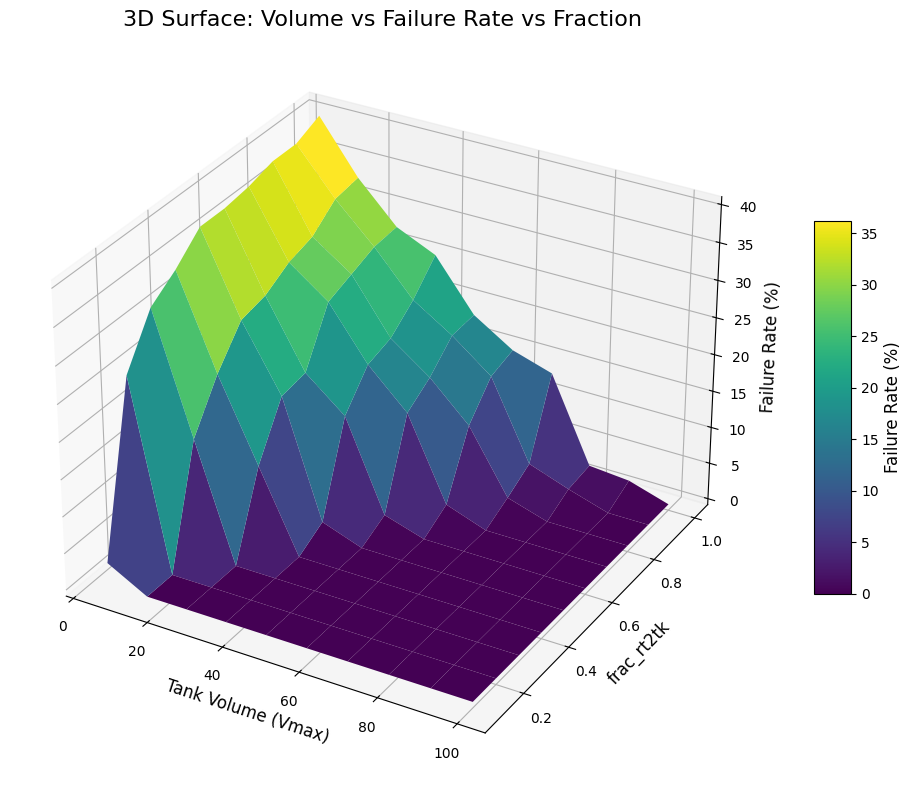

In [23]:

from mpl_toolkits.mplot3d import Axes3D

# Prepare grid data
frac_rt2tk = np.array(list(results.keys()))  # frac_rt2tk values
Vmax_grid = np.array(Vmax_values)  # Vmax_values

# Create a 2D grid for frac_rt2tk and Vmax
X, Y = np.meshgrid(Vmax_grid, frac_rt2tk)

# Extract Z (failure rates) for the grid
Z = np.array([list(results[frac].values()) for frac in frac_rt2tk])

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add color bar for the surface
colorbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
colorbar.set_label('Failure Rate (%)', fontsize=12)

# Set labels
ax.set_title("3D Surface: Volume vs Failure Rate vs Fraction", fontsize=16)
ax.set_xlabel("Tank Volume (Vmax)", fontsize=12)
ax.set_ylabel("frac_rt2tk", fontsize=12)
ax.set_zlabel("Failure Rate (%)", fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig("3d.png", dpi=300, bbox_inches="tight")  # Save as a PNG file
plt.show()


In [24]:
frac_rt2tk = 0.9

# Extract the failure rates for the specified fraction as a NumPy array
failure_rates_array = np.array(list(results.get(frac_rt2tk, {}).values()))

# Print the result
print(f"Failure rates for frac_rt2tk={frac_rt2tk} as a NumPy array:")
print(failure_rates_array)

Failure rates for frac_rt2tk=0.9 as a NumPy array:
[38.7409201  32.68765133 27.60290557 21.79176755 18.40193705 14.28571429
  3.63196126  1.69491525  0.          0.        ]


In [25]:
np.sum(df_pluvio_2['precp'])

19.490574034909823

In [17]:
def find_vmax_at_failure_rate(results, target_rate):
    """
    Find the Vmax corresponding to a target failure rate for each fraction using precomputed results.

    Parameters:
        results (dict): Precomputed failure rates with frac_rt2tk as keys and dictionaries of Vmax vs failure rate as values.
        target_rate (float): The failure rate (in %) to find Vmax for.

    Returns:
        dict: Dictionary with frac_rt2tk as keys and corresponding Vmax at target rate as values.
    """
    vmax_at_target = {}
    
    for frac_rt2tk, failure_rates in results.items():
        vmax_values = np.array(list(failure_rates.keys()))
        failure_rate_values = np.array(list(failure_rates.values()))
        
        # Calculate the difference from the target rate
        differences = failure_rate_values - target_rate
        
        # Find the smallest positive and largest negative differences
        positive_differences = differences[differences > 0]
        negative_differences = differences[differences < 0]
        
        if positive_differences.size > 0 and negative_differences.size > 0:
            # Get the smallest positive difference and its index
            pos_index = np.where(differences == positive_differences.min())[0][0]
            # Get the largest negative difference and its index
            neg_index = np.where(differences == negative_differences.max())[0][0]
            
            # Values for interpolation
            x1, x2 = failure_rate_values[neg_index], failure_rate_values[pos_index]
            y1, y2 = vmax_values[neg_index], vmax_values[pos_index]
            
            # Linear interpolation formula: y = y1 + (target - x1) * (y2 - y1) / (x2 - x1)
            vmax_at_target[frac_rt2tk] = y1 + (target_rate - x1) * (y2 - y1) / (x2 - x1)
        else:
            vmax_at_target[frac_rt2tk] = None  # No valid interpolation
    
    return vmax_at_target

In [ ]:
# Example usage with precomputed results
target_rate = 5.0  # Target failure rate in %
vmax_at_5_percent = find_vmax_at_failure_rate(results, target_rate)

# Print results
print("Vmax at 5% Failure Rate for Each Fraction:")
for frac_rt2tk, vmax in vmax_at_5_percent.items():
    if vmax is not None:
        print(f"frac_rt2tk={frac_rt2tk:.1f}: Vmax={vmax:.2f} m³")
    else:
        print(f"frac_rt2tk={frac_rt2tk:.1f}: No Vmax satisfies the target failure rate.")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(
    list(vmax_at_5_percent.keys()), 
    [v if v is not None else np.nan for v in vmax_at_5_percent.values()], 
    marker="o", linestyle="-", label="Vmax at 5% Failure Rate"
)
plt.title("Vmax at 5% Failure Rate vs. Fraction (frac_rt2tk)", fontsize=16)
plt.xlabel("frac_rt2tk", fontsize=14)
plt.ylabel("Vmax (m³)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
vmax_at_5_percent

NameError: name 'vmax_at_5_percent' is not defined

In [28]:
vmax_5 =  np.array(list(vmax_at_5_percent.values()))
vmax_5[0] = 0

In [29]:
### Now we will compare the ratio Vout and Vin (sum of precipitation*area) for each frac. The goal is to reduce the ratio, which mean we reuse most of the water.

# Vin is the precipitation * area_total which is the same for each frac.

Vin = np.sum(df_pluvio_2["precp"]/1000)*imper # total volume on roads and soil, in m3

nb_steps = 10

Vout = np.zeros(nb_steps)

fraction = 0.1
resolution = 5

for i in range(10):
    results = model_st(df_pluvio_2, k=83, frac_rt2tk=fraction, lag=lagging, Vmax=vmax_5[i])
    Vout[i] = np.sum(results['Qout'])*60*resolution
    fraction += 0.1




In [30]:
ratio = Vout/Vin

In [31]:
Vout[9]

251.24074765801822

In [32]:
ratio

array([1.        , 0.8993527 , 0.84902904, 0.79967118, 0.76438247,
       0.71465158, 0.66246485, 0.61358992, 0.57823449, 0.52903762])

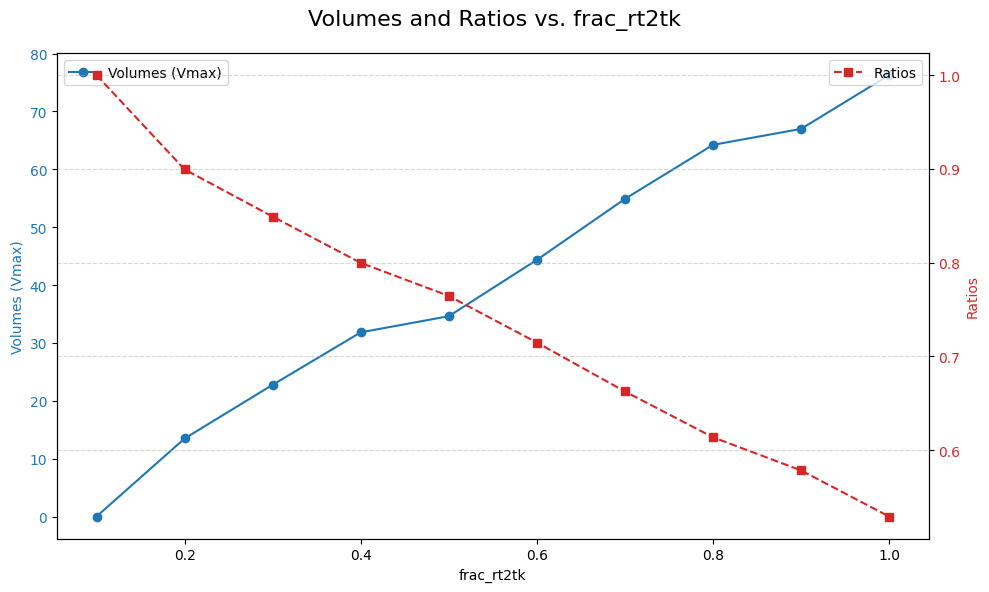

In [33]:
# Create a figure and axis

frac_rt2tk = np.arange(0.1, 1.1, 0.1)


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the volumes on the first y-axis
color1 = 'tab:blue'
ax1.set_xlabel('frac_rt2tk')
ax1.set_ylabel('Volumes (Vmax)', color=color1)
ax1.plot(frac_rt2tk, vmax_5, marker='o', color=color1, label='Volumes (Vmax)')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Ratios', color=color2)
ax2.plot(frac_rt2tk, ratio, marker='s', linestyle='--', color=color2, label='Ratios')
ax2.tick_params(axis='y', labelcolor=color2)

# Add a title and legends
fig.suptitle('Volumes and Ratios vs. frac_rt2tk', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add a grid and layout
plt.grid(True, which='both', linestyle='--', alpha=0.5)
fig.tight_layout()

# Show the plot

#### 10 yr data

In [85]:
# Read the file
df_precp_10yr = pd.read_csv(
    "order_124645_data.txt", 
    delimiter=";", 
    low_memory=False
)


In [86]:
# Convert the 'time' column to a datetime format
df_precp_10yr['time'] = pd.to_datetime(df_precp_10yr['time'], format='%Y%m%d%H%M')

df_precp_10yr = df_precp_10yr.rename(columns={"rre150z0": "precp"})

# Display the first few rows
print(df_precp_10yr.head())

   stn                time precp
0  LSN 2014-01-01 00:00:00   0.0
1  LSN 2014-01-01 00:10:00   0.0
2  LSN 2014-01-01 00:20:00   0.1
3  LSN 2014-01-01 00:30:00   0.1
4  LSN 2014-01-01 00:40:00   0.1


In [87]:
len(df_precp_10yr['time'])

525888

In [17]:
### We made the modification on the rainfall date and added the memory effect, we will now run the model.
df_precp_10yr = pd.read_pickle('df_precp_10yr.pkl')

df_precp_10yr = df_precp_10yr.rename(columns={"precp": "original_precp"})
df_precp_10yr = df_precp_10yr.rename(columns={"precp2" : "precp"})

In [19]:
df_precp_10yr['time'].dt.month

0          1
1          1
2          1
3          1
4          1
          ..
525883    12
525884    12
525885    12
525886    12
525887    12
Name: time, Length: 525888, dtype: int32

In [18]:
df_model_10yr = model_st(df_precp_10yr, k=90, lag=lagging,frac_rt2tk = 0.5, Vmax = 100,resolution = 10)

In [58]:
df_model_flush10 = model_st(df_precp_10yr,k=90,lag=lagging,frac_rt2tk =0.5,Vmax=100,resolution=10,flushing_frequency=10)

df_model_flush100 = model_st(df_precp_10yr,k=90,lag=lagging,frac_rt2tk =0.5,Vmax=100,resolution=10,flushing_frequency=100)

In [28]:
df_model_flush10

,stn,time,original_precp,precp,Qout,Qroad,Qroof,Qsoil,Qtank,Qirr,Vflush,soil_mois,v_tank
0,LSN,2014-01-01 00:00:00,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.596154,0.000000
1,LSN,2014-01-01 00:10:00,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.596095,0.000000
2,LSN,2014-01-01 00:20:00,0.1,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.596036,0.000000
3,LSN,2014-01-01 00:30:00,0.1,0.000285,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.595977,0.000000
4,LSN,2014-01-01 00:40:00,0.1,0.000914,5.405848e-06,3.588313e-06,1.817535e-06,0.0,0.0,0.0,0.001745,0.595918,0.001745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525883,LSN,2023-12-31 23:10:00,0.0,0.000000,7.071539e-13,4.693971e-13,2.377568e-13,0.0,0.0,0.0,0.040000,0.901410,17.359943
525884,LSN,2023-12-31 23:20:00,0.0,0.000000,2.651827e-13,1.760239e-13,8.915879e-14,0.0,0.0,0.0,0.000000,0.901351,17.319943
525885,LSN,2023-12-31 23:30:00,0.0,0.000000,9.944351e-14,6.600897e-14,3.343455e-14,0.0,0.0,0.0,0.100000,0.901292,17.319943
525886,LSN,2023-12-31 23:40:00,0.0,0.000000,3.729132e-14,2.475336e-14,1.253795e-14,0.0,0.0,0.0,0.020000,0.901233,17.219943


In [29]:
np.mean(df_model_flush100['Vflush'])

0.03423222773578189

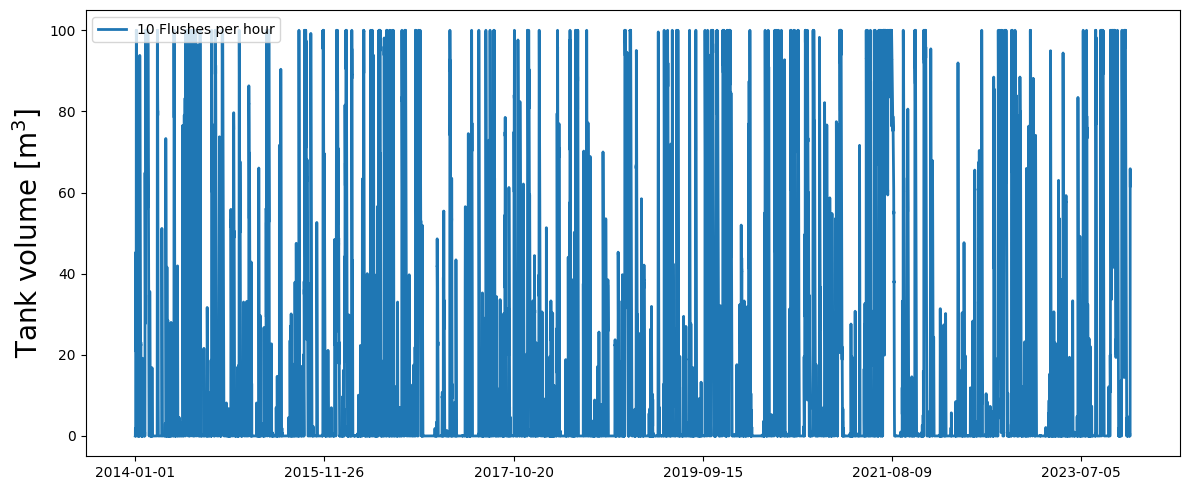

In [59]:
# Plot the results

start = 207000
end = 208000

# Set the 'Date' column as the x-axis
plt.figure(figsize=(12, 5))

        ### Qirr

#plt.plot(df_model_10yr['time'][start:end], df_model_flush100['Qirr'][start:end]*2000, label='Qirr' ,linewidth=2)

        ### V_flush

#plt.plot(df_model_10yr['time'][start:end], df_model_10yr['Vflush'][start:end], label='Vflush_2', linewidth=1)
#plt.plot(df_model_10yr['time'][start:end], df_model_flush10['Vflush'][start:end], label='Vflush_10', linewidth=1)
#plt.plot(df_model_10yr['time'][start:end], df_model_flush100['Vflush'][start:end], label='Vflush_100', linewidth=1)

        ### V_tank

#plt.plot(df_model_10yr['time'][start:end], df_model_flush100['v_tank'][start:end], label='100 Flushes per hour',linewidth=2)
plt.plot(df_model_10yr['time'], df_model_flush10['v_tank'],label='10 Flushes per hour', linewidth=2)
#plt.plot(df_model_10yr['time'][start:end], df_model_10yr['v_tank'][start:end],label='2 Flushes per hour', linewidth=2)

        ### Q_tank
#plt.plot(df_model_10yr.index[start:end], df_model_10yr['Qtank'][start:end], label='Qtank_2', linewidth=2)
#plt.plot(df_model_10yr.index[start:end], df_model_flush10['Qtank'][start:end], label='Qtank_10', linewidth=2)
#plt.plot(df_model_10yr.index[start:end], df_model_flush100['Qtank'][start:end], label='Qtank_100', linewidth=2)

#plt.plot(df_model_10yr['time'],df_precp_10yr['precp'],linewidth = 2)
#plt.plot(df_pluvio_2.index,df_pluvio_2['precp'],label = 'precp2',linewidth = 1)
#plt.plot(df_model_10yr['time'][start:end],df_model_10yr['soil_mois'][start:end],label = 'soil moisture',linewidth = 1)
#plt.plot(df_model_10yr['time'], df_model_10yr['Qout'], linewidth=2)

# Customize the plot
#plt.xlabel('Date',fontsize = 20)
plt.ylabel('Tank volume [m$^3$]',fontsize = 20)
#plt.title('Time Series for 1 year')
plt.xticks(df_model_10yr['time'][::100000], rotation=0,fontsize = 10)  # Show every 1000th date
plt.legend(loc="upper left")

plt.tight_layout()
#plt.savefig("presentation/flush.png", dpi=300, bbox_inches="tight")  # Save as a PNG file

# Show the plot
plt.show()

In [36]:
df_model_flush10['v_tank'].head()

#df_model_flush10['v_tank'].tail()

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.001745
Name: v_tank, dtype: float64

In [21]:
# Modification of Qirr and impact on the model

#df_model_Qirr10 = model_st(df_precp_10yr,k=90,lag=lagging,frac_rt2tk =0.5,Vmax=100,resolution=10,Qirr = 10*omegaSoil*E_max/(100*86400),flushing_frequency=10)
#df_model_Qirr100 = model_st(df_precp_10yr,k=90,lag=lagging,frac_rt2tk =0.5,Vmax=100,resolution=10,Qirr = 100*omegaSoil*E_max/(100*86400),flushing_frequency=10)
df_model_Qirr1 = model_st(df_precp_10yr,k=90,lag=lagging,frac_rt2tk =0.5,Vmax=100,resolution=10,flushing_frequency=10)

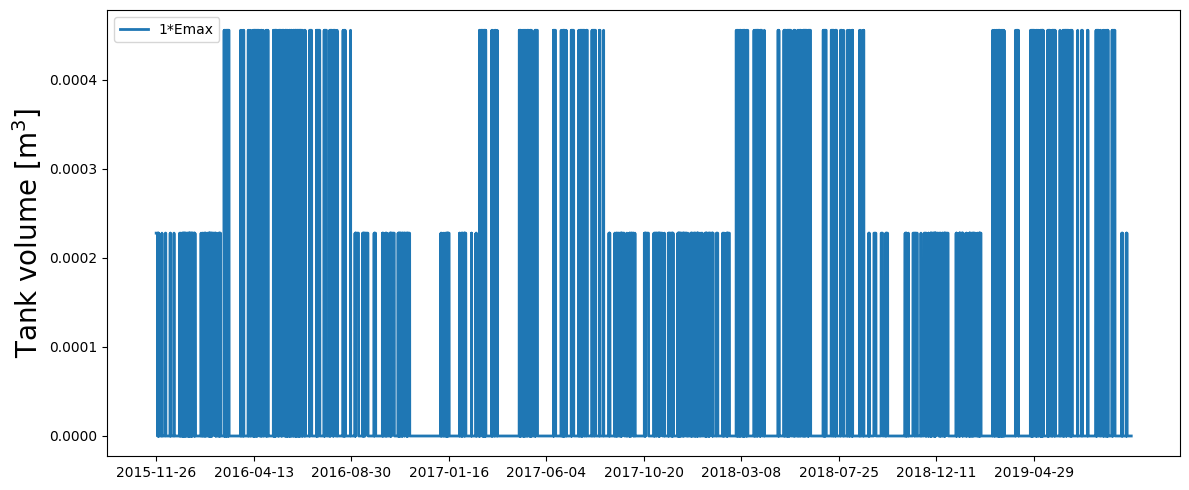

In [44]:
start = 100000
end = 300000

# Set the 'Date' column as the x-axis
plt.figure(figsize=(12, 5))

### V_tank

#plt.plot(df_model_10yr['time'][start:end], df_model_Qirr10['v_tank'][start:end], label='10*Emax',linewidth=2)
#plt.plot(df_model_10yr['time'][start:end], df_model_flush10['v_tank'][start:end],label='50*Emax', linewidth=2)
#plt.plot(df_model_10yr['time'][start:end], df_model_Qirr100['v_tank'][start:end],label='100*Emax', linewidth=2)
plt.plot(df_model_10yr['time'][start:end], df_model_Qirr1['Qirr'][start:end],label='1*Emax', linewidth=2)

# Customize the plot
#plt.xlabel('Date',fontsize = 20)
plt.ylabel('Tank volume [m$^3$]',fontsize = 20)
#plt.title('Time Series for 1 year')
plt.xticks(df_model_10yr['time'][start:end:20000], rotation=0,fontsize = 10)  # Show every 1000th date
plt.legend(loc="upper left")

plt.tight_layout()
#plt.savefig("presentation/irrigation.png", dpi=300, bbox_inches="tight")  # Save as a PNG file

# Show the plot
plt.show()



In [25]:
non_zero_precp = (df_precp_10yr['precp'] != 0).sum()

non_zero_precp

68590

In [26]:
np.mean(df_precp_10yr['precp']/(1000*600))*4000

9.02665450132808e-05

In [43]:
failures1 = (df_model_Qirr1['Qtank'] != 0).sum()*100/non_zero_precp
#failures10 = (df_model_Qirr10['Qtank'] != 0).sum()*100/non_zero_precp
#failures100 = (df_model_Qirr100['Qtank'] != 0).sum()*100/non_zero_precp
#failures50 = (df_model_flush10['Qtank'] != 0).sum()*100/non_zero_precp

print(f"Failure rate for Qirr = 1*Emax: {failures1:.2f} %")
#print(f"Failure rate for Qirr = 10*Emax: {failures10:.2f} %")
#print(f"Failure rate for Qirr = 50*Emax: {failures50:.2f} %")
#print(f"Failure rate for Qirr = 100*Emax: {failures100:.2f} %")


Failure rate for Qirr = 1*Emax: 11.09 %


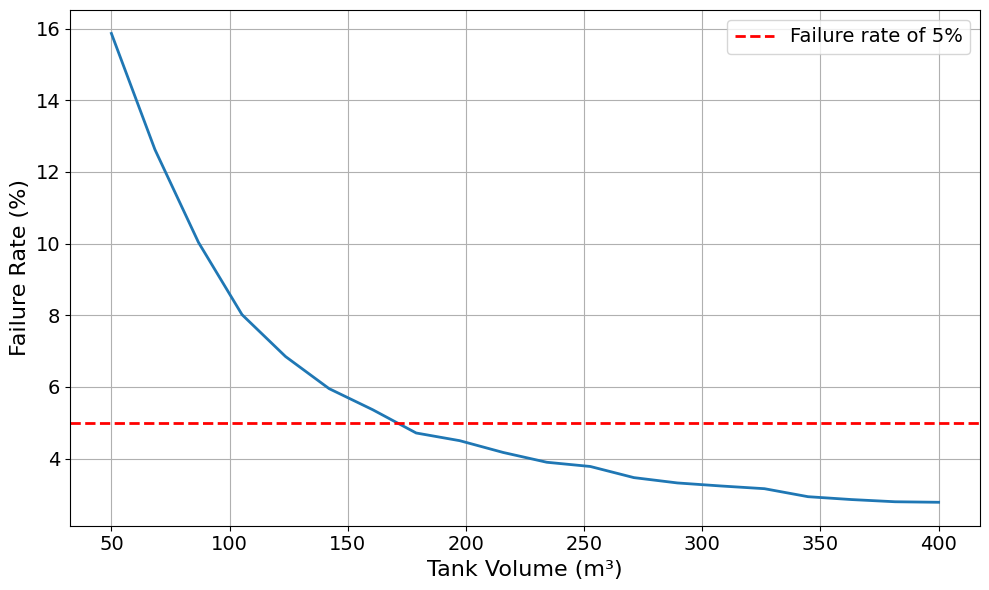

In [17]:

# Example usage
time_step = 600  # 10-minute intervals in seconds
fraction = 0.5

# Define a range of Vmax values to test
Vmax_values = np.linspace(50, 400, 20)  # Test Vmax from 50 to 400 in 20 steps
flushing_frequency = 10

# Call the function (assuming it's already defined)
failure_rates = calculate_failure_rate(df_precp_10yr, model_st, 90, lagging, Vmax_values, time_step, fraction, flushing_frequency)

# Plot failure rates vs. Vmax
plt.figure(figsize=(10, 6))

plt.plot(
    Vmax_values,
    list(failure_rates.values()),
    linestyle='-',
    linewidth=2,
    markersize=8
)

plt.axhline(
    y=5,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Failure rate of 5%"
)

plt.xlabel("Tank Volume (m³)", fontsize=16)
plt.ylabel("Failure Rate (%)", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc="upper right", fontsize=14)
plt.grid(True)
plt.tight_layout()

# Save the figure in high resolution (300 dpi)
plt.savefig("failure_rate_vs_Vmax.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


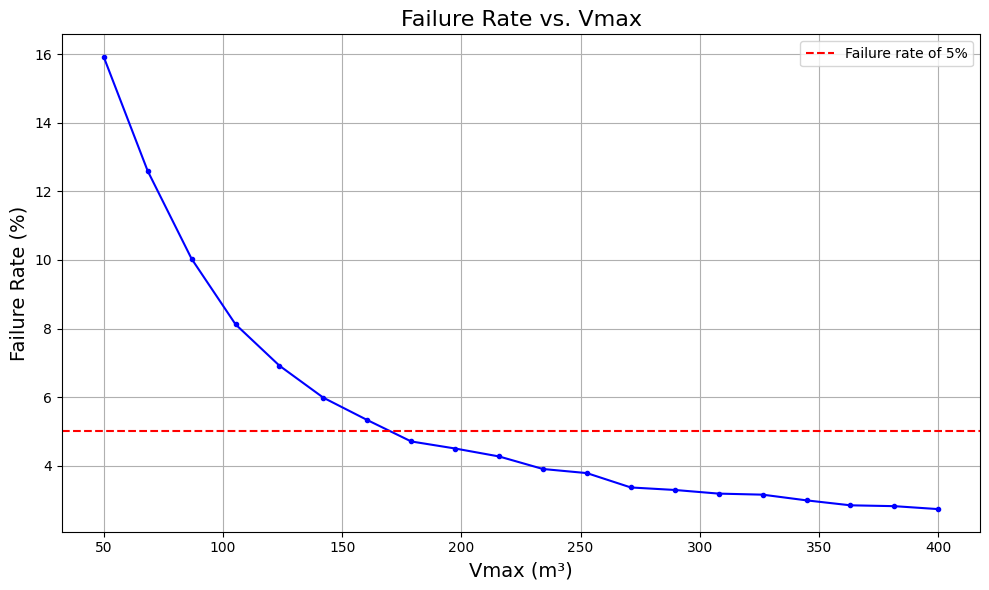

In [20]:
# Example usage
time_step = 600  # 10-minute intervals in seconds
fraction = 0.5

# Define a range of Vmax values to test
Vmax_values = np.linspace(50, 400, 20)  # Test Vmax from 10 to 100 in 10 steps
flushing_frequency = 10

# Call the function
failure_rates = calculate_failure_rate(df_precp_10yr, model_st, 90, lagging, Vmax_values, time_step,fraction,flushing_frequency)

# Plot failure rates vs. Vmax
plt.figure(figsize=(10, 6))
plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', color='blue')
plt.title("Failure Rate vs. Vmax", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
#tank statistics

# Calculate statistics
stats = calculate_tank_statistics_with_overflow(df_precp_10yr,df_model_Qirr1, 100, 600)

# Print statistics
print("Tank Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

Tank Statistics:
total_time_steps_rain: 68590
total_failure_time_steps: 7532
failure_rate: 10.98
failure_durations (hours): [2.17, 3.67, 0.17, 0.5, 3.17, 0.33, 1.0, 2.67, 4.33, 0.17, 0.33, 2.17, 10.17, 0.17, 2.5, 1.17, 1.17, 0.17, 0.17, 1.0, 1.5, 3.67, 1.33, 0.67, 0.33, 1.33, 0.5, 0.83, 1.17, 1.0, 0.33, 0.83, 0.33, 1.5, 1.5, 0.33, 10.0, 0.5, 1.33, 9.17, 0.17, 0.5, 0.5, 4.67, 0.33, 1.0, 2.67, 3.67, 0.67, 0.17, 0.17, 1.83, 0.33, 3.83, 0.33, 0.67, 0.17, 2.17, 0.5, 1.5, 0.17, 0.33, 0.17, 2.5, 0.33, 1.33, 0.17, 0.5, 0.67, 0.17, 0.17, 1.83, 0.17, 2.67, 0.5, 0.33, 0.83, 0.17, 1.17, 0.17, 2.17, 0.17, 0.17, 11.0, 0.17, 0.33, 3.17, 3.67, 0.17, 3.33, 2.17, 0.67, 7.0, 0.67, 0.5, 0.5, 0.17, 5.67, 2.33, 0.17, 2.0, 3.17, 2.67, 8.83, 4.17, 1.0, 7.5, 0.5, 0.17, 9.67, 0.5, 2.33, 1.0, 0.33, 1.0, 0.83, 3.83, 0.5, 3.83, 0.67, 3.67, 0.17, 0.5, 1.0, 3.17, 1.0, 0.17, 1.5, 0.17, 6.5, 9.33, 0.17, 7.67, 0.17, 1.17, 8.0, 1.5, 4.33, 0.83, 0.17, 0.17, 0.67, 0.5, 0.33, 0.5, 4.0, 0.5, 2.67, 0.83, 2.67, 0.17, 1.0, 2.3

In [31]:
# Find the index of the maximum value in 'Qtank'
max_qtank_index = df_model_Qirr1['Qtank'].idxmax()

# Retrieve the entire row corresponding to the maximum value
max_qtank_row = df_model_Qirr1.loc[max_qtank_index]

print("Row corresponding to the maximum Qtank:")
print(max_qtank_row)


Row corresponding to the maximum Qtank:
stn                               LSN
time              2018-06-11 21:10:00
original_precp                   41.0
precp                       41.004246
Qout                         0.502967
Qroad                        0.055768
Qroof                        0.028247
Qsoil                             0.0
Qtank                        0.418952
Qirr                              0.0
Vflush                           0.02
soil_mois                    0.637163
v_tank                          100.0
soil_volume               1580.848202
Name: 233695, dtype: object


In [32]:
# Boolean array indicating failures (Qtank != 0)
failures = (df_model_Qirr1['Qtank'] != 0).to_numpy()

# Initialize variables
failure_durations = []
current_start = None
current_duration = 0
failure_rows = []  # To store start and end indices of each failure event

# Identify consecutive failure durations
for i, fail in enumerate(failures):
    if fail:
        current_duration += 1
        if current_start is None:
            current_start = i
    elif current_duration > 0:
        # Store the failure duration and indices
        failure_durations.append(current_duration)
        failure_rows.append((current_start, i - 1))
        current_duration = 0
        current_start = None

# Handle the last failure if it ends at the last step
if current_duration > 0:
    failure_durations.append(current_duration)
    failure_rows.append((current_start, len(failures) - 1))

# Find the index of the longest failure
longest_failure_index = np.argmax(failure_durations)
longest_failure_start, longest_failure_end = failure_rows[longest_failure_index]

# Calculate the duration in time
longest_failure_duration_steps = failure_durations[longest_failure_index]
longest_failure_duration_hours = longest_failure_duration_steps * time_step / 3600  # Convert to hours

# Extract rows corresponding to the longest failure
longest_failure_rows = df_model_Qirr1.iloc[longest_failure_start:longest_failure_end + 1]

# Output results
print(f"Longest failure duration: {longest_failure_duration_hours:.2f} hours")
print(f"Start index: {longest_failure_start}, End index: {longest_failure_end}")
#print("Rows corresponding to the longest failure:")
#print(longest_failure_rows)


Longest failure duration: 9.50 hours
Start index: 521439, End index: 521552


#### Soil moisture statistics

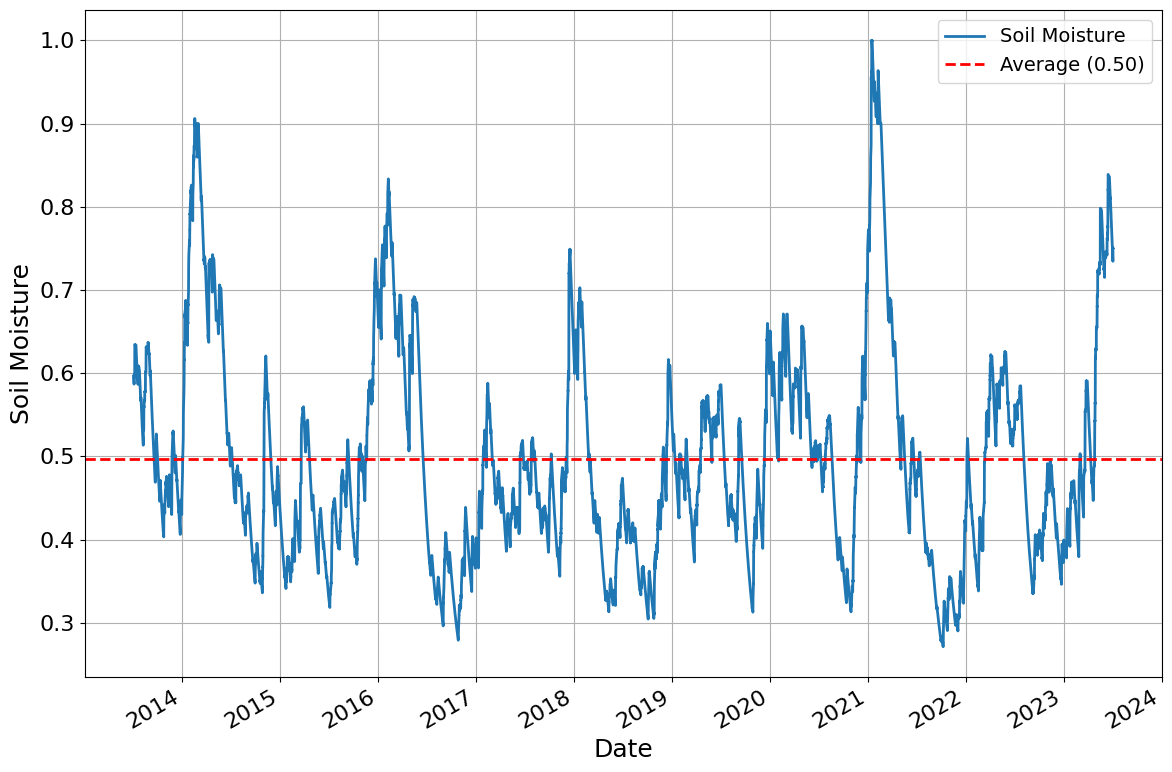

In [26]:

average_soil_moisture = df_model_Qirr1['soil_mois'].mean()

df_model_10yr['time'] = pd.to_datetime(df_model_10yr['time'])


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})

plt.plot(
    df_model_10yr['time'],
    df_model_Qirr1['soil_mois'],
    label='Soil Moisture',
    linewidth=2
)

plt.axhline(
    y=average_soil_moisture,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Average ({average_soil_moisture:.2f})'
)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Soil Moisture', fontsize=18)  # You can adjust the unit if needed

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # e.g., 2025-03-11
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))     # Tick every 6 months (adjust as needed)

# Rotate x-axis labels for readability
plt.gcf().autofmt_xdate()

# Add legend
plt.legend(fontsize=14)

# Add grid
plt.grid(True)

# Improve layout spacing
plt.tight_layout()

# Save the plot in the 'plot' folder
plt.savefig('plot/10yr_soil_moisture.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Average Soil Volume: 1232.51 m³
Variance of Soil Volume: 103294.19 m³²
Maximum Soil Volume: 2481.07 m³
Minimum Soil Volume: 673.02 m³


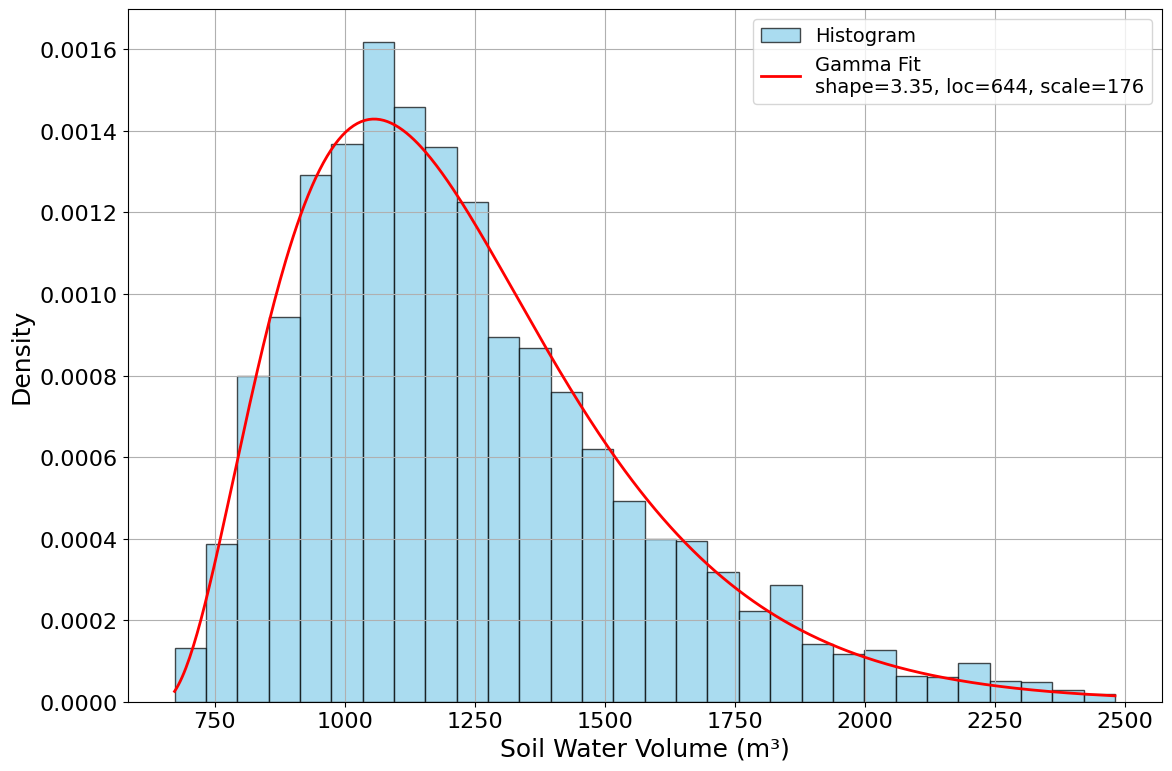

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
import os

# Calculate total omega for soil layers
omegaSoil = sum(omegas_st)

# Calculate soil water volume
df_model_Qirr1['soil_volume'] = df_model_Qirr1['soil_mois'] * omegaSoil * (Z_root / 100) * 0.45  # Z_root in cm, 0.45 porosity

# Statistics
average_volume = np.mean(df_model_Qirr1['soil_volume'])
variance_volume = np.var(df_model_Qirr1['soil_volume'])
max_volume = np.max(df_model_Qirr1['soil_volume'])
min_volume = np.min(df_model_Qirr1['soil_volume'])

# Print statistics
print(f"Average Soil Volume: {average_volume:.2f} m³")
print(f"Variance of Soil Volume: {variance_volume:.2f} m³²")
print(f"Maximum Soil Volume: {max_volume:.2f} m³")
print(f"Minimum Soil Volume: {min_volume:.2f} m³")

# Fit gamma distribution to soil volume data
soil_volume = df_model_Qirr1['soil_volume']
shape, loc, scale = gamma.fit(soil_volume)

# Generate x values and fitted gamma PDF
x = np.linspace(min(soil_volume), max(soil_volume), 500)
fitted_pdf = gamma.pdf(x, shape, loc, scale)

# Create plot folder if it doesn't exist
os.makedirs('plot', exist_ok=True)

# Plot histogram and gamma fit
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})

# Histogram
plt.hist(soil_volume, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')

# Gamma fit line
plt.plot(x, fitted_pdf, color='red', linewidth=2, label=f'Gamma Fit\nshape={shape:.2f}, loc={loc:.0f}, scale={scale:.0f}')

# Axis labels (no title)
plt.xlabel("Soil Water Volume (m³)", fontsize=18)
plt.ylabel("Density", fontsize=18)

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True)

# Layout
plt.tight_layout()

# Save the figure in plot folder
plt.savefig('plot/soil_volume_gamma_fit.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [34]:
duration = stats['failure_durations (hours)']

In [35]:
average = stats['avg_failure_duration (hours)']
1/average

0.5813953488372093

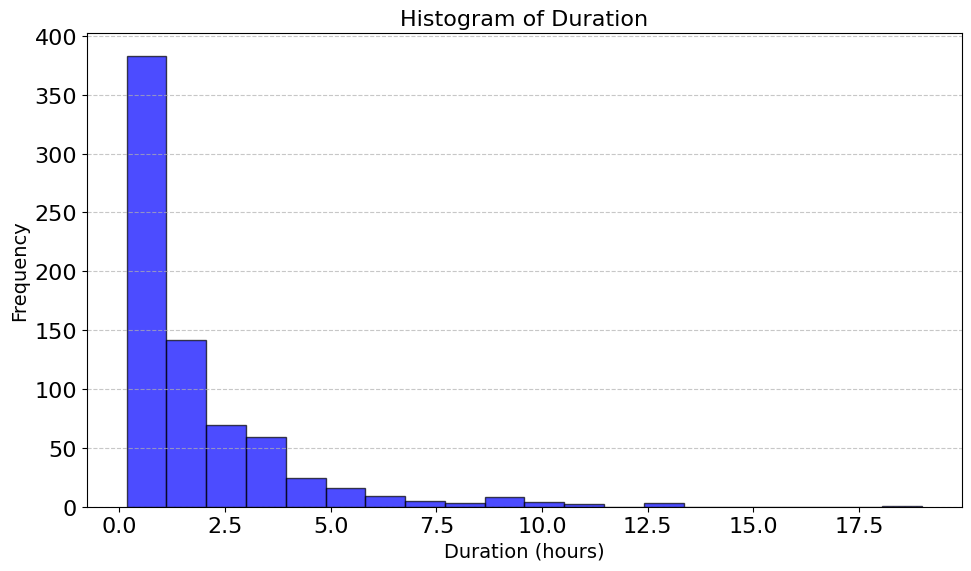

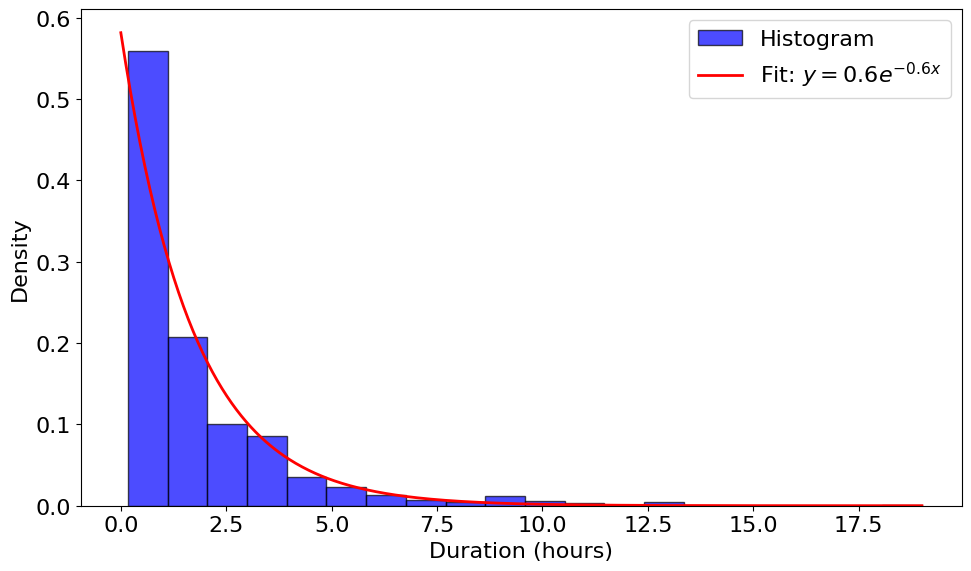

In [36]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(duration, bins=20, color='blue', alpha=0.7, edgecolor='black')

# Add labels and title
plt.title("Histogram of Duration", fontsize=16)
plt.xlabel("Duration (hours)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


from scipy.optimize import curve_fit

average = stats['avg_failure_duration (hours)']

# Compute the fixed decay parameter (1/average duration)
fixed_lambda = 1 / np.mean(average)  

# Define the fixed exponential function
def fixed_exp_decay(x):
    return fixed_lambda * np.exp(-fixed_lambda * x)

# Create a histogram
hist, bin_edges = np.histogram(duration, bins=20, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

# Generate data for the fixed exponential curve
x_fit = np.linspace(0, max(duration), 500)
y_fit = fixed_exp_decay(x_fit)

# Plot the histogram and the fixed exponential curve
plt.figure(figsize=(10, 6))
plt.hist(duration, bins=20, density=True, color='blue', alpha=0.7, edgecolor='black', label='Histogram')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Fit: $y = {fixed_lambda:.1f} e^{{-{fixed_lambda:.1f}x}}$')

# Add labels and title
plt.xlabel("Duration (hours)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)

# Show the plot
plt.tight_layout()

# Save the figure
plt.savefig('presentation/duration.png', dpi=300)

plt.show()




In [18]:
time_step = 600  # 10-minute intervals in seconds
Vmax_values = np.linspace(20, 400, 10)  # Test Vmax from 10 to 120 in 10 steps
fractions = np.linspace(0.1, 1, 10)  # Test frac_rt2tk from 0.1 to 1.0 in 10 steps
flushing_frequency = 100

results = calculate_failure_rate_for_fractions(df_precp_10yr, model_st, 90, lagging, Vmax_values, time_step, fractions,flushing_frequency)

# Save the results to a pickle file
with open('results2.pkl', 'wb') as file:
    pickle.dump(results, file)

print("Data successfully saved to 'results2.pkl'")

# Plot results
plt.figure(figsize=(12, 8))
for frac_rt2tk, failure_rates in results.items():
    plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', label=f"frac_rt2tk={frac_rt2tk:.1f}")

plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Tank volume (m³)", fontsize=16)
plt.ylabel("Failure Rate (%)", fontsize=16)
plt.legend(loc="upper right", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [19]:
with open('results2.pkl', 'rb') as file:
    results = pickle.load(file)

print("Data successfully loaded!")
#print(results)

Data successfully loaded!


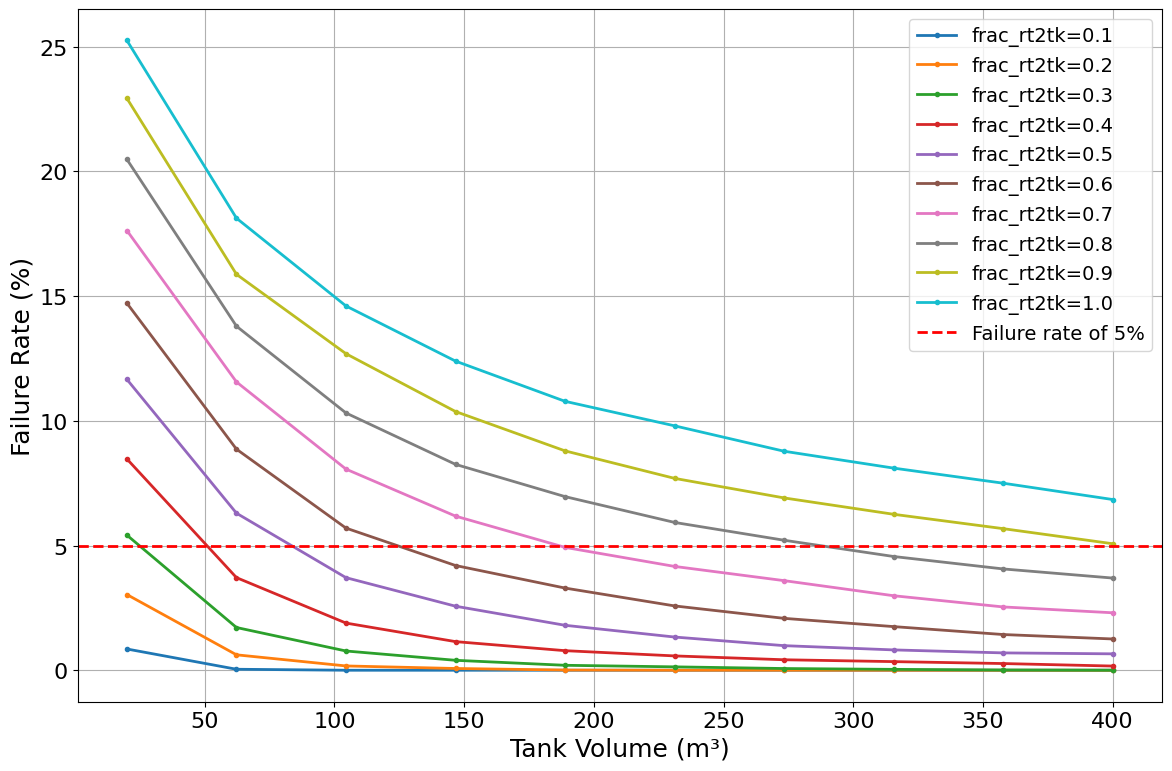

In [23]:
time_step = 600  # 10-minute intervals in seconds
Vmax_values = np.linspace(20, 400, 10)  # Test Vmax from 10 to 120 in 10 steps
fractions = np.linspace(0.1, 1, 10)  # Test frac_rt2tk from 0.1 to 1.0 in 10 steps

# Create the plot
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})  # General font size for everything

# Plot each failure rate curve
for frac_rt2tk, failure_rates in results.items():
    plt.plot(
        Vmax_values,
        list(failure_rates.values()),
        marker='.',
        linestyle='-',
        linewidth=2,
        label=f"frac_rt2tk={frac_rt2tk:.1f}"
    )

# Add horizontal line for 5% failure rate threshold
plt.axhline(y=5, color="red", linestyle="--", linewidth=2, label="Failure rate of 5%")

# Axis labels (big fonts)
plt.xlabel("Tank Volume (m³)", fontsize=18)
plt.ylabel("Failure Rate (%)", fontsize=18)

# Legend (smaller font but still readable)
plt.legend(loc="upper right", fontsize=14)

# Add grid
plt.grid(True)

# Improve spacing
plt.tight_layout()

# Save the figure
plt.savefig('plot/failure_rate_vs_tank_volume.png', dpi=300)

# Show the plot
plt.show()

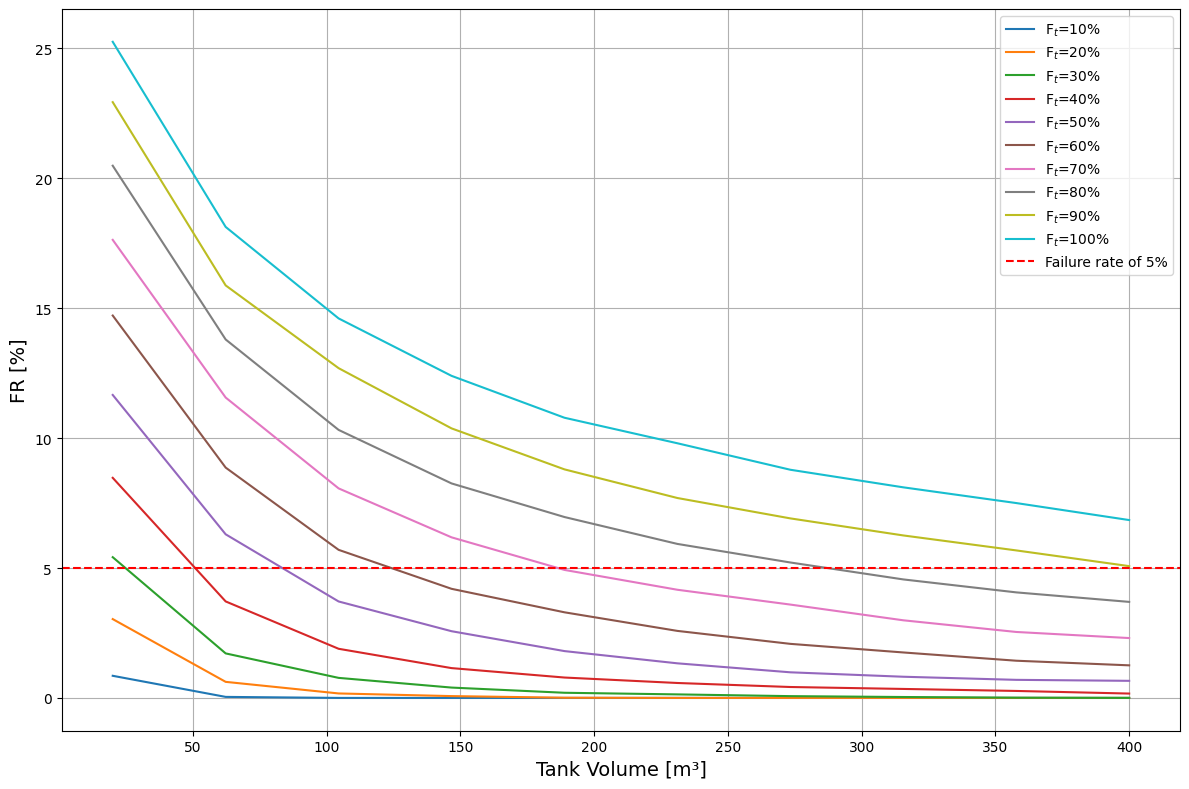

In [62]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# Interpolating failure rates for a continuous curve
interpolated_results = {}

Vmax_continuous = np.linspace(20, 400, 100)  # More points for smoother curve

plt.figure(figsize=(12, 8))

for frac_rt2tk, failure_rates in results.items():
    x = np.array(list(failure_rates.keys()))  # Original Vmax values
    y = np.array(list(failure_rates.values()))  # Corresponding failure rates

    # Create an interpolation function
    f_interp = interp1d(x, y, kind='linear', fill_value="extrapolate")
    
    # Compute interpolated values
    y_continuous = f_interp(Vmax_continuous)
    
    # Store interpolated results
    interpolated_results[frac_rt2tk * 100] = y_continuous  # Convert to percentage

    # Plot the interpolated curve
    plt.plot(Vmax_continuous, y_continuous, linestyle='-', label=f"F$_t$={frac_rt2tk * 100:.0f}%")

#plt.title("Failure Rate vs. Vmax for Different Fractions (Interpolated)", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Tank Volume [m³]", fontsize=14)
plt.ylabel("FR [%]", fontsize=14)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.savefig('presentation/fractions.png', dpi=300)

plt.show()


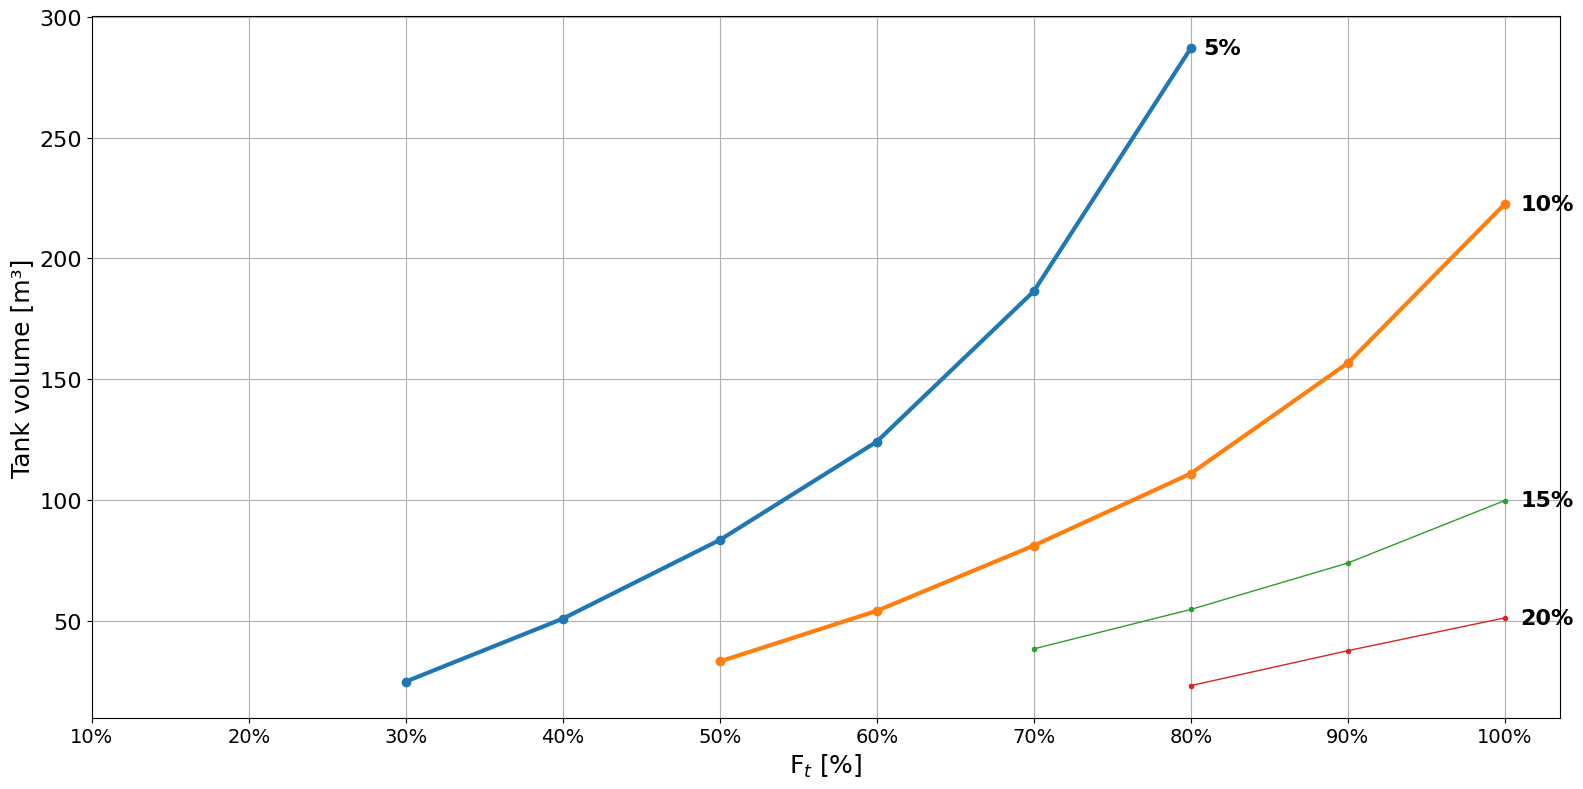

In [64]:
import matplotlib.pyplot as plt

# Define failure rates to extract
failure_levels = [5, 10, 15, 20]
highlighted_levels = [5,10]
fractions = sorted(interpolated_results.keys())  # Sorted fraction values

# Convert fractions to percentages
fraction_percentages = [f for f in fractions]

# Storage for interpolated Vmax values
interpolated_Vmax = {level: [] for level in failure_levels}

# Find Vmax for each failure level at each fraction using interpolation
for frac in fractions:
    y = interpolated_results[frac]  # Interpolated failure rates
    x = Vmax_continuous  # Interpolated Vmax values

    # Create an interpolation function (failure rate -> Vmax)
    f_interp = interp1d(y, x, kind='linear', fill_value="extrapolate")

    for level in failure_levels:
        if min(y) <= level <= max(y):  # Ensure level is within range
            interpolated_Vmax[level].append(f_interp(level))
        else:
            interpolated_Vmax[level].append(np.nan)  # Assign NaN if out of range

# Plotting the results
plt.figure(figsize=(16, 8))

for level, Vmax_interpolated in interpolated_Vmax.items():
    # Set line width for bold effect
    linewidth = 3 if level in highlighted_levels else 1
    marker = 'o' if level in highlighted_levels else '.'
    alpha = 1  # Keep all lines fully visible

    plt.plot(
        fraction_percentages, Vmax_interpolated, 
        marker=marker, linestyle='-', 
        linewidth=linewidth, alpha=alpha, 
        label=f"{level}% Failure Rate"
    )

    # Add text label near the end of each curve
    last_valid_idx = next((i for i in reversed(range(len(Vmax_interpolated))) if not np.isnan(Vmax_interpolated[i])), None)
    if last_valid_idx is not None:
        plt.text(fraction_percentages[last_valid_idx] * 1.01, Vmax_interpolated[last_valid_idx], f"{level}%", 
                 fontsize=16, ha='left', va='center', fontweight='bold', color='black')

# Set x-axis labels to percentages
plt.xticks(fraction_percentages, [f"{int(f)}%" for f in fraction_percentages],fontsize = 14)
plt.yticks(fontsize = 16)

#plt.title("Vmax vs. Fraction for Different Failure Rates", fontsize=16)
plt.xlabel("F$_t$ [%]", fontsize=18)
plt.ylabel("Tank volume [m³]", fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.savefig('presentation/failure.png', dpi=300)
plt.show()


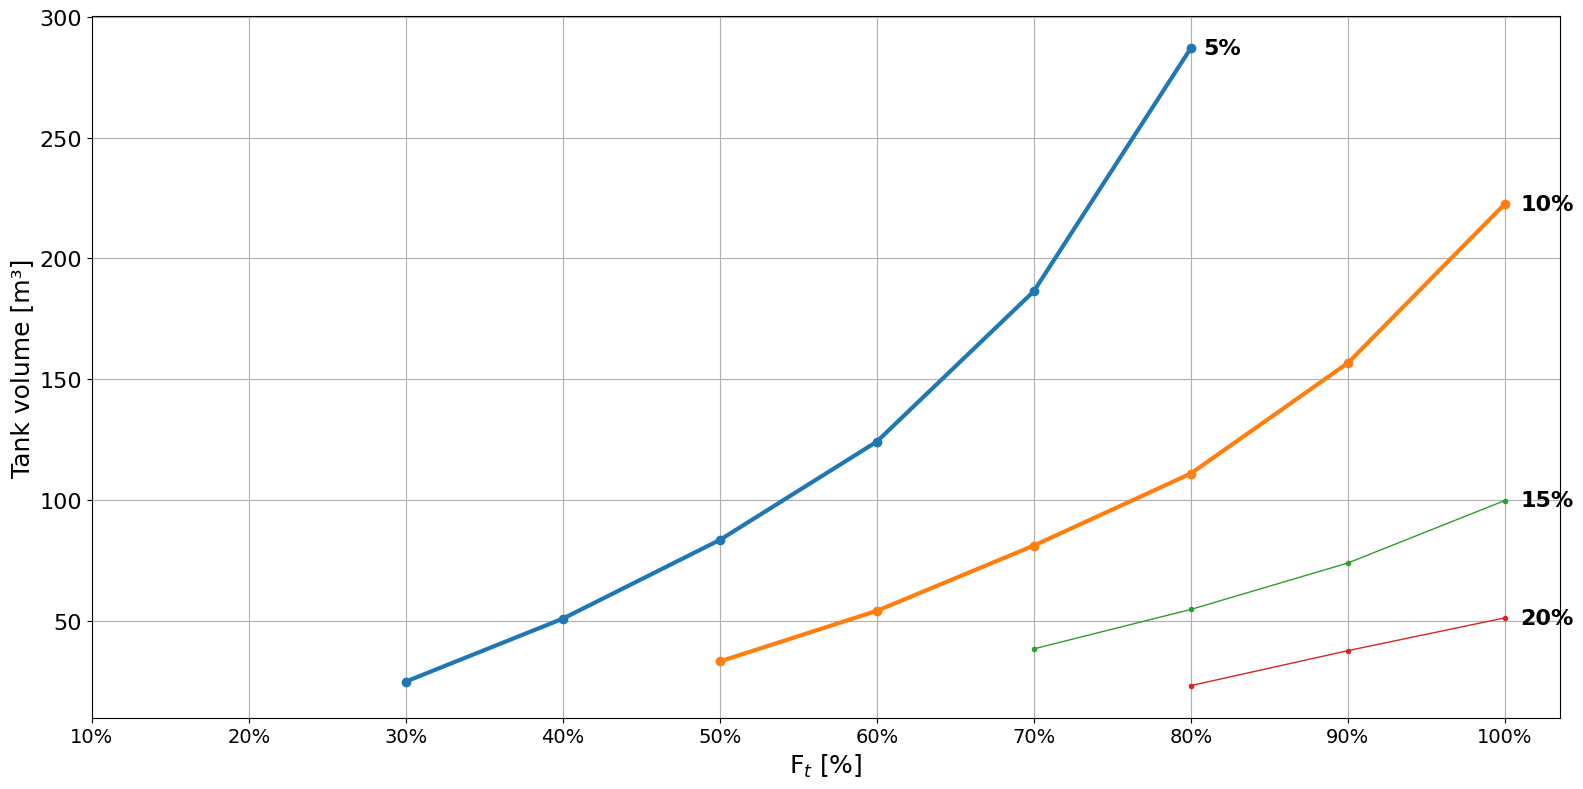

In [65]:
import matplotlib.pyplot as plt

# Define failure rates to extract
failure_levels = [5, 10, 15, 20]
highlighted_levels = [5,10]
fractions = sorted(interpolated_results.keys())  # Sorted fraction values

# Convert fractions to percentages
fraction_percentages = [f for f in fractions]

# Storage for interpolated Vmax values
interpolated_Vmax = {level: [] for level in failure_levels}

# Find Vmax for each failure level at each fraction using interpolation
for frac in fractions:
    y = interpolated_results[frac]  # Interpolated failure rates
    x = Vmax_continuous  # Interpolated Vmax values

    # Create an interpolation function (failure rate -> Vmax)
    f_interp = interp1d(y, x, kind='linear', fill_value="extrapolate")

    for level in failure_levels:
        if min(y) <= level <= max(y):  # Ensure level is within range
            interpolated_Vmax[level].append(f_interp(level))
        else:
            interpolated_Vmax[level].append(np.nan)  # Assign NaN if out of range

# Plotting the results
plt.figure(figsize=(16, 8))

for level, Vmax_interpolated in interpolated_Vmax.items():
    # Set line width for bold effect
    linewidth = 3 if level in highlighted_levels else 1
    marker = 'o' if level in highlighted_levels else '.'
    alpha = 1  # Keep all lines fully visible

    plt.plot(
        fraction_percentages, Vmax_interpolated, 
        marker=marker, linestyle='-', 
        linewidth=linewidth, alpha=alpha, 
        label=f"{level}% Failure Rate"
    )

    # Add text label near the end of each curve
    last_valid_idx = next((i for i in reversed(range(len(Vmax_interpolated))) if not np.isnan(Vmax_interpolated[i])), None)
    if last_valid_idx is not None:
        plt.text(fraction_percentages[last_valid_idx] * 1.01, Vmax_interpolated[last_valid_idx], f"{level}%", 
                 fontsize=16, ha='left', va='center', fontweight='bold', color='black')

# Set x-axis labels to percentages
plt.xticks(fraction_percentages, [f"{int(f)}%" for f in fraction_percentages],fontsize = 14)
plt.yticks(fontsize = 16)

#plt.title("Vmax vs. Fraction for Different Failure Rates", fontsize=16)
plt.xlabel("F$_t$ [%]", fontsize=18)
plt.ylabel("Tank volume [m³]", fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.savefig('presentation/failure.png', dpi=300)
plt.show()


#### test

Vmax at 5% Failure Rate for Each Fraction:
frac_rt2tk=0.1: No Vmax satisfies the target failure rate.
frac_rt2tk=0.2: No Vmax satisfies the target failure rate.
frac_rt2tk=0.3: No Vmax satisfies the target failure rate.
frac_rt2tk=0.4: Vmax=46.88 m³
frac_rt2tk=0.5: Vmax=79.24 m³
frac_rt2tk=0.6: Vmax=123.23 m³
frac_rt2tk=0.7: Vmax=186.89 m³
frac_rt2tk=0.8: Vmax=292.59 m³
frac_rt2tk=0.9: No Vmax satisfies the target failure rate.
frac_rt2tk=1.0: No Vmax satisfies the target failure rate.


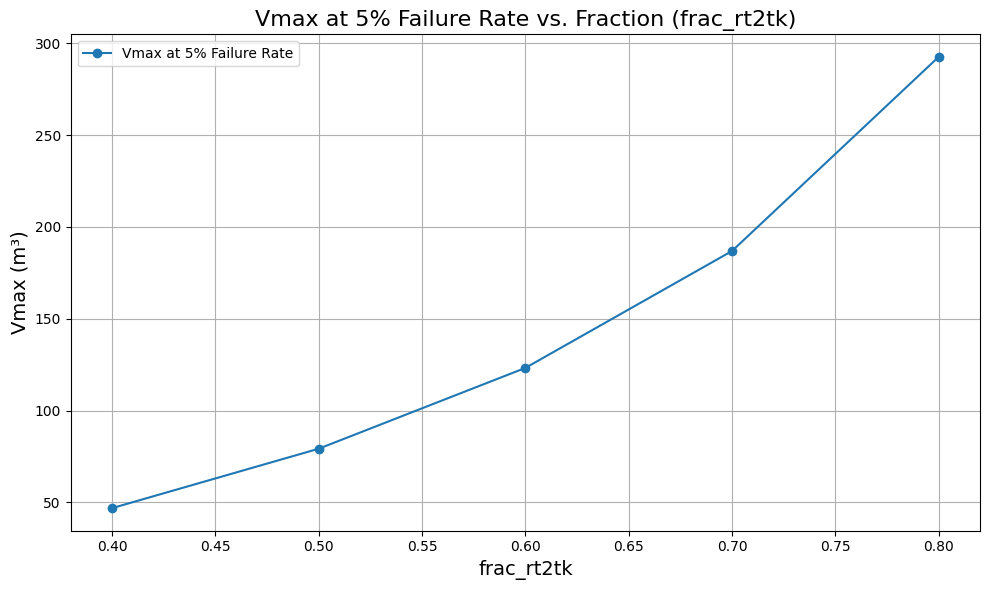

In [38]:

# Example usage with precomputed results
target_rate = 5.0  # Target failure rate in %
vmax_at_5_percent = find_vmax_at_failure_rate(results, target_rate)

# Print results
print("Vmax at 5% Failure Rate for Each Fraction:")
for frac_rt2tk, vmax in vmax_at_5_percent.items():
    if vmax is not None:
        print(f"frac_rt2tk={frac_rt2tk:.1f}: Vmax={vmax:.2f} m³")
    else:
        print(f"frac_rt2tk={frac_rt2tk:.1f}: No Vmax satisfies the target failure rate.")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(
    list(vmax_at_5_percent.keys()), 
    [v if v is not None else np.nan for v in vmax_at_5_percent.values()], 
    marker="o", linestyle="-", label="Vmax at 5% Failure Rate"
)
plt.title("Vmax at 5% Failure Rate vs. Fraction (frac_rt2tk)", fontsize=16)
plt.xlabel("frac_rt2tk", fontsize=14)
plt.ylabel("Vmax (m³)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [40]:
vmax_at_5_percent

{0.1: None,
 0.2: None,
 0.30000000000000004: None,
 0.4: 46.8821887213847,
 0.5: 79.23929505713892,
 0.6: 123.22958813154892,
 0.7000000000000001: 186.89189189189187,
 0.8: 292.59173723376955,
 0.9: None,
 1.0: None}

In [41]:
vmax_5 =  np.array(list(vmax_at_5_percent.values()))
for i in range(len(vmax_5)):
    if vmax_5[i] == None:
        vmax_5[i] = 0

vmax_5

array([0, 0, 0, 46.8821887213847, 79.23929505713892, 123.22958813154892,
       186.89189189189187, 292.59173723376955, 0, 0], dtype=object)

In [42]:
### Now we will compare the ratio Vout and Vin (sum of precipitation*area) for each frac. The goal is to reduce the ratio, which mean we reuse most of the water.

# Vin is the precipitation * area_total which is the same for each frac.

Vin = np.sum(df_precp_10yr["precp"]/1000)*imper # total volume on roads and soil, in m3

nb_steps = 10

Vout = np.zeros(nb_steps)

fraction = 0.1
resolution = 10

for i in range(10):
    df = model_st(df_precp_10yr, k=90, frac_rt2tk=fraction, lag=lagging, Vmax=vmax_5[i],resolution = 10)
    Vout[i] = np.sum(df['Qout']*60*10)
    fraction += 0.1


In [44]:
Vout

array([173496.30610806, 173496.30610806, 173496.30610806, 148600.13578086,
       140662.14248693, 134511.52344474, 130452.56815292, 127680.60100488,
       173496.30610806, 173496.30610806])

In [45]:
ratio = Vout/Vin

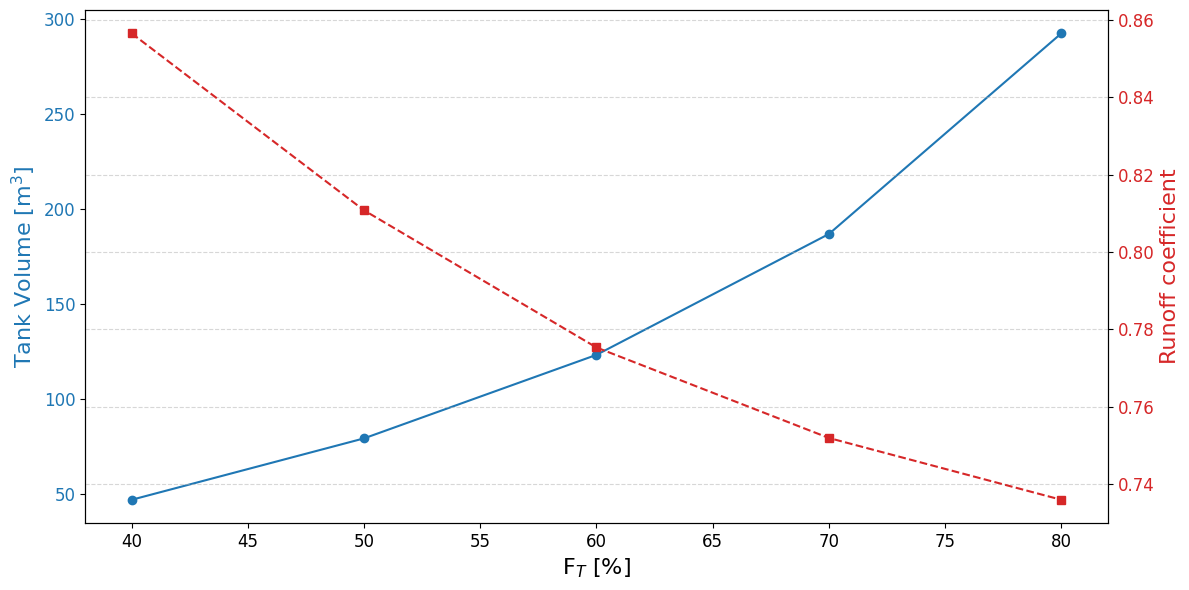

In [48]:
# Create a figure and axis

frac_rt2tk = np.arange(40, 90, 10)


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the volumes on the first y-axis
color1 = 'tab:blue'
ax1.set_xlabel('F$_T$ [%]',fontsize = 16)
ax1.set_ylabel('Tank Volume [m$^3$]', color=color1,fontsize = 16)
ax1.plot(frac_rt2tk, vmax_5[3:8:], marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1,labelsize=12)
ax1.tick_params(axis='x', labelsize=12)


# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Runoff coefficient', color=color2,fontsize = 16)
ax2.plot(frac_rt2tk, ratio[3:8:], marker='s', linestyle='--', color=color2)
ax2.tick_params(axis='y', labelcolor=color2,labelsize=12)

# Add a grid and layout
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("presentation/ratio.png", dpi=300, bbox_inches="tight") 
fig.tight_layout()

# Show the plot

Runoff results saved as 'runoff_results_failure_rates.pkl'


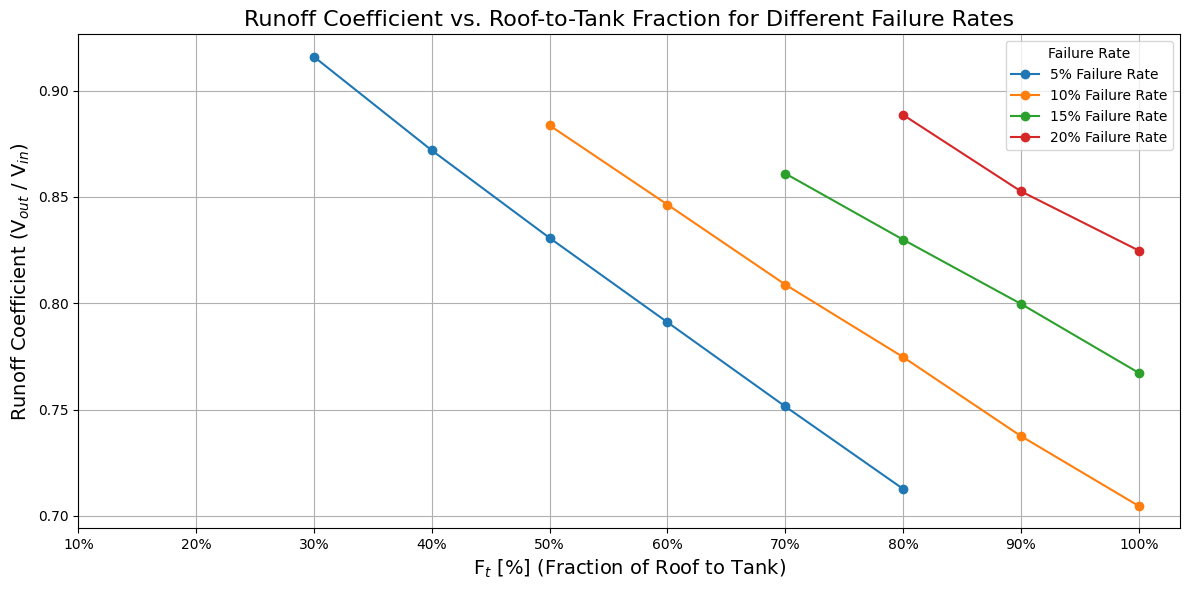

In [66]:
def calculate_runoff_for_failure_rates(df, model_st, k_st, lagging, interpolated_Vmax, fractions, flushing_frequency,resolution):
    """
    Compute runoff coefficients for different failure rates, fractions, and corresponding Vmax values.

    Parameters:
        df (DataFrame): Input precipitation data.
        model_st (function): The tank model function.
        k_st (float): Time constant for the model.
        lagging (int): Lag parameter for the model.
        interpolated_Vmax (dict): Dictionary containing Vmax values for different failure rates.
        time_step (float): Time step duration in seconds.
        fractions (list or array): Different values of frac_rt2tk to test.
        flushing_frequency (int): Frequency of flushing the tank.

    Returns:
        dict: Dictionary with failure rates as keys, each containing a list of runoff coefficients for each fraction.
    """
    results = {}

    # Compute total incoming volume (Vin) for the whole dataset
    Vin = np.sum(df["precp"] / 1000) * imper  # Convert mm to m³ over the impervious area

    for failure_rate, Vmax_list in interpolated_Vmax.items():
        runoff_coefficients = []

        for frac_idx, Vmax in enumerate(Vmax_list):
            if np.isnan(Vmax):  # Skip if Vmax is NaN
                runoff_coefficients.append(np.nan)
                continue
            
            fraction = fractions[frac_idx]  # Get the fraction corresponding to this index

            # Run the model
            df_model = model_st(df, k=k_st, frac_rt2tk=fraction, lag=lagging, Vmax=Vmax, flushing_frequency=flushing_frequency,resolution = resolution)
            
            # Calculate runoff coefficient (Vout/Vin)
            Vout = np.sum(df_model['Qout'] * resolution*60)  # Convert flow rate to volume
            runoff_coefficient = Vout / Vin  # Dimensionless ratio

            # Store result
            runoff_coefficients.append(runoff_coefficient)

        # Store results for this failure rate
        results[failure_rate] = runoff_coefficients

    return results

# Example usage
resolution = 10
flushing_frequency = 10
fractions = np.linspace(0.1, 1, 10)  # Roof-to-tank fractions

# Compute runoff coefficients
runoff_results = calculate_runoff_for_failure_rates(df_precp_10yr, model_st, 90, lagging, interpolated_Vmax, fractions, flushing_frequency,resolution)

# Save the results to a pickle file
with open("runoff_results_failure_rates.pkl", "wb") as f:
    pickle.dump(runoff_results, f)

print("Runoff results saved as 'runoff_results_failure_rates.pkl'")

# === Plot results ===
plt.figure(figsize=(12, 6))

for failure_rate, runoff_coeffs in runoff_results.items():
    plt.plot(fractions, runoff_coeffs, marker='o', linestyle='-', label=f"{failure_rate}% Failure Rate")

plt.xlabel("F$_t$ [%] (Fraction of Roof to Tank)", fontsize=14)
plt.ylabel("Runoff Coefficient (V$_{out}$ / V$_{in}$)", fontsize=14)
plt.title("Runoff Coefficient vs. Roof-to-Tank Fraction for Different Failure Rates", fontsize=16)
plt.xticks(fractions, [f"{int(f * 100)}%" for f in fractions])
plt.legend(title="Failure Rate")
plt.grid(True)
plt.tight_layout()

plt.savefig("runoff_vs_fraction_failure_rates.png", dpi=300)
plt.show()


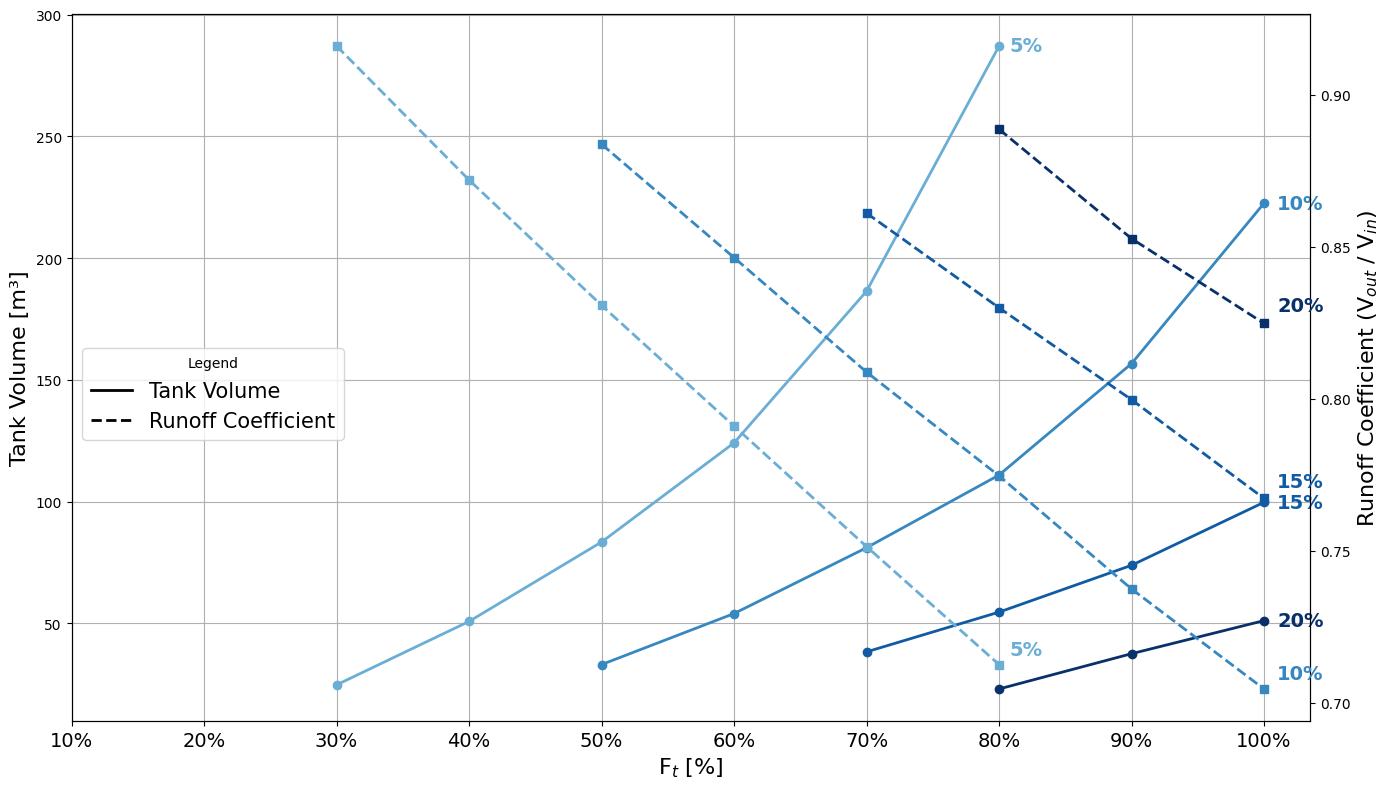

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors for each failure rate to ensure consistency
failure_rates = sorted(interpolated_Vmax.keys())  # Sorted failure rates
colors = plt.cm.Blues(np.linspace(0.5, 1, len(failure_rates)))  # Generate colors

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# --- Plot Tank Volume on Left Y-Axis ---
ax1.set_xlabel("F$_t$ [%]", fontsize=16)
ax1.set_ylabel("Tank Volume [m³]", fontsize=16, color='black')

for idx, failure_rate in enumerate(failure_rates):
    Vmax_interpolated = interpolated_Vmax[failure_rate]  # Extract Vmax values
    color = colors[idx]  # Assign corresponding color

    ax1.plot(
        fractions, Vmax_interpolated, 
        marker='o', linestyle='-', linewidth=2, 
        color=color, label=f"{failure_rate}% Failure Rate"
    )

    # Add text label near the last valid point
    last_valid_idx = next((i for i in reversed(range(len(Vmax_interpolated))) if not np.isnan(Vmax_interpolated[i])), None)
    if last_valid_idx is not None:
        ax1.text(fractions[last_valid_idx] * 1.01, Vmax_interpolated[last_valid_idx], 
                 f"{failure_rate}%", fontsize=14, ha='left', va='center', color=color, fontweight='bold')

ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# --- Plot Runoff Coefficient on Right Y-Axis ---
ax2 = ax1.twinx()  
ax2.set_ylabel("Runoff Coefficient (V$_{out}$ / V$_{in}$)", fontsize=16, color='black')

for idx, failure_rate in enumerate(failure_rates):
    runoff_coeffs = runoff_results[failure_rate]  # Extract runoff coefficient values
    color = colors[idx]  # Assign the same color as tank volume

    ax2.plot(
        fractions, runoff_coeffs, 
        marker='s', linestyle='--', linewidth=2, 
        color=color, label=f"{failure_rate}% Failure Rate"
    )

    # Add text label near the last valid point
    last_valid_idx = next((i for i in reversed(range(len(runoff_coeffs))) if not np.isnan(runoff_coeffs[i])), None)
    if last_valid_idx is not None:
        ax2.text(fractions[last_valid_idx] * 1.01, runoff_coeffs[last_valid_idx]*1.007, 
                 f"{failure_rate}%", fontsize=14, ha='left', va='center', color=color, fontweight='bold')

ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to percentages
ax1.set_xticks(fractions)
ax1.set_xticklabels([f"{int(f * 100)}%" for f in fractions], fontsize=14)

fig.legend(
    handles=[
        plt.Line2D([0], [0], linestyle='-', color='black', linewidth=2, label="Tank Volume"),
        plt.Line2D([0], [0], linestyle='--', color='black', linewidth=2, label="Runoff Coefficient")
    ],
    loc="center left", bbox_to_anchor=(0.055, 0.5), fontsize=15, title="Legend"
)

plt.tight_layout()

# Save and Show
plt.savefig("combined_runoff_tank_volume.png", dpi=300)
plt.show()


#### Work for the Hurst coefficient

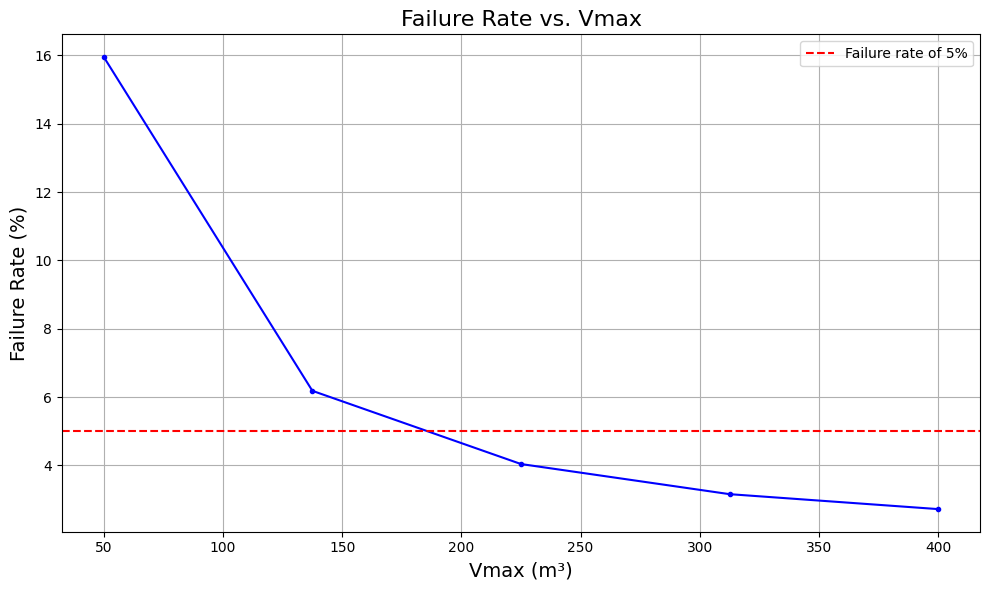

In [24]:
# Trying to find the volume of the tank for fraction = 1 and failure = 0 
Vmax_values = np.linspace(50,400,5)
time_step = 600 #resolution in seconds
fraction = 0.5
flushing_frequency = 10

# Call the function
failure_rates = calculate_failure_rate(df_precp_10yr, model_st, 90, lagging, Vmax_values, time_step , fraction , flushing_frequency)

# Plot failure rates vs. Vmax
plt.figure(figsize=(10, 6))
plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', color='blue')
plt.title("Failure Rate vs. Vmax", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()





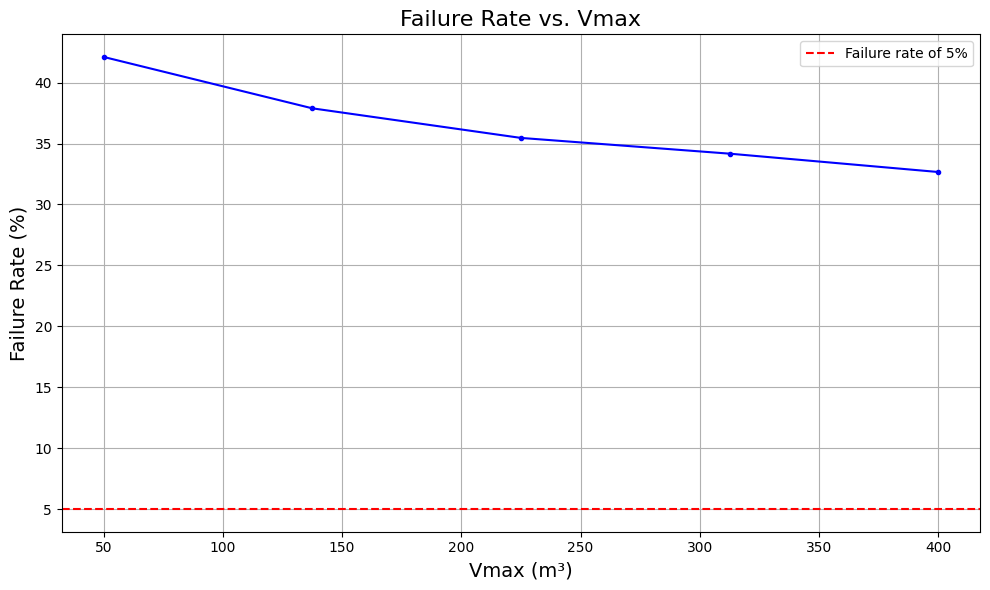

In [26]:
# Trying to find the volume of the tank for fraction = 1 and failure = 0 
Vmax_values = np.linspace(50,400,5)
time_step = 600 #resolution in seconds
fraction = 0.5
flushing_frequency = 10

# Call the function
failure_rates = calculate_failure_rate(df_precp_10yr, model_st, 90, lagging, Vmax_values, time_step , fraction , flushing_frequency)

# Plot failure rates vs. Vmax
plt.figure(figsize=(10, 6))
plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', color='blue')
plt.title("Failure Rate vs. Vmax", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()





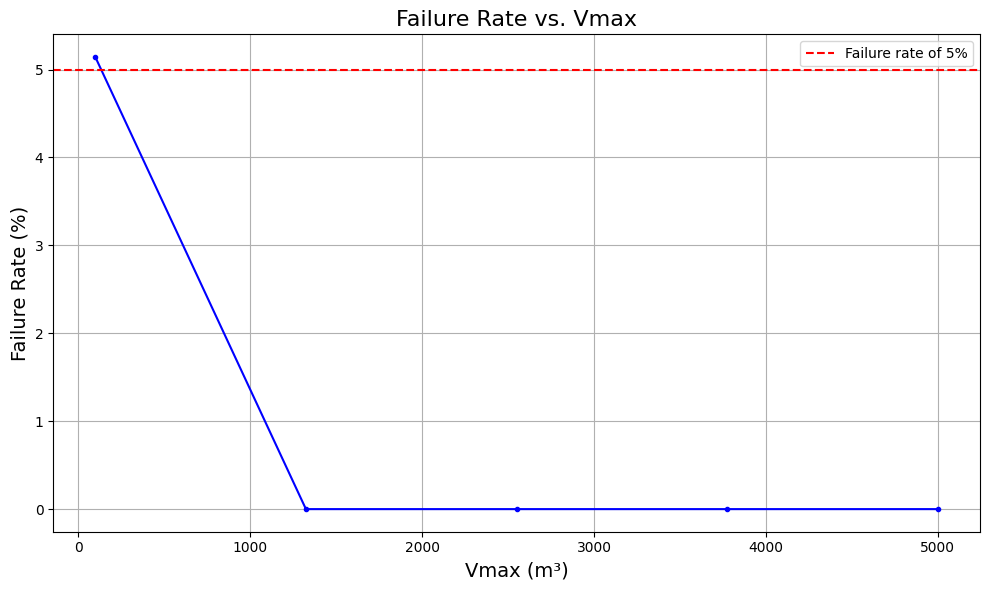

In [22]:
# Trying to find the volume of the tank for fraction = 1 and failure = 0 
Vmax_values = np.linspace(100,5000,5)
time_step = 600 #resolution in seconds

# Call the function
failure_rates = calculate_failure_rate(df_precp_10yr, model_st, 84, lagging, Vmax_values, time_step , 0.4 , 10)

# Plot failure rates vs. Vmax
plt.figure(figsize=(10, 6))
plt.plot(Vmax_values, list(failure_rates.values()), marker='.', linestyle='-', color='blue')
plt.title("Failure Rate vs. Vmax", fontsize=16)
plt.axhline(y=5, color="red", linestyle="--", label="Failure rate of 5%")
plt.xlabel("Vmax (m³)", fontsize=14)
plt.ylabel("Failure Rate (%)", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
np.sum(df_precp_10yr['precp'])*omegaRoof/1000

87309.67678204276

In [12]:
lagging = 0

In [32]:
### We made the modification on the rainfall date and added the memory effect, we will now run the model.
df_precp_10yr = pd.read_pickle('df_precp_10yr.pkl')

In [38]:
df_0 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.00001,Vmax=0,resolution=10,flushing_frequency=10)

In [33]:
df_500 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.99,Vmax=500,resolution=10,flushing_frequency=10)
df_1000 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.99,Vmax=1000,resolution=10,flushing_frequency=10)
df_1500 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.99,Vmax=1500,resolution=10,flushing_frequency=10)
df_2000 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.99,Vmax=2000,resolution=10,flushing_frequency=10)
df_2500 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.99,Vmax=2500,resolution=10,flushing_frequency=10)
df_3000 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.99,Vmax=3000,resolution=10,flushing_frequency=10)
df_3500 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.99,Vmax=3500,resolution=10,flushing_frequency=10)

In [63]:
df_25000 = model_st(df_precp_10yr,k=83.9,lag=lagging,frac_rt2tk=0.4,Vmax=25000,resolution=10,flushing_frequency=10)

In [15]:
df_500['Qout'].describe()

count     5.258880e+05
mean      7.256268e-04
std       4.493735e-03
min       0.000000e+00
25%      1.521387e-245
50%       2.244224e-87
75%       2.766864e-20
max       7.886386e-01
Name: Qout, dtype: float64

In [16]:
df_1500['Qout'].describe()

count     5.258880e+05
mean      7.140896e-04
std       4.444698e-03
min       0.000000e+00
25%      1.521387e-245
50%       2.244224e-87
75%       2.766864e-20
max       7.886719e-01
Name: Qout, dtype: float64

In [39]:
import pickle

# Create a dictionary to store Qout columns from each dataframe
Qout_all = {
    0 : df_0['Qout'],
    500: df_500['Qout'],
    1000: df_1000['Qout'],
    1500: df_1500['Qout'],
    2000: df_2000['Qout'],
    2500: df_2500['Qout'],
    3000: df_3000['Qout'],
    3500: df_3500['Qout'],
}

# Save the dictionary to a pkl file
with open("Qout_all.pkl", "wb") as f:
    pickle.dump(Qout_all, f)

print("File saved as Qout_all.pkl")


File saved as Qout_all.pkl


In [28]:
# Creating a new dataframe with recognizable titles for each column
df_combined = pd.DataFrame({
    'Qout_notank': df_notank['Qout'],
    'Qout_100': df_100['Qout'],
    'Qout_500': df_500['Qout'],
    'Qout_1500': df_1500['Qout']
})

# Saving the dataframe as a .pkl file
file_path = "combined_Qout_2.pkl"
df_combined.to_pickle(file_path)

# Returning the file path for download
file_path

'combined_Qout_2.pkl'

In [15]:

# Generate values for Vmax
Vmax_values = np.linspace(250, 2500, 10)

# Dictionary to store Qout
Qout_dict = {}

# Loop through Vmax values
for Vmax in Vmax_values:
    df = model_st(df_precp_10yr, k=83.9, lag=lagging, frac_rt2tk=0.999, Vmax=int(Vmax), resolution=10, flushing_frequency=10)
    
    # Store Qout in the dictionary with a key like "Qout_250"
    Qout_dict[f"Qout_{int(Vmax)}"] = df['Qout']

# Now you can access Qout values using:
# Qout_dict["Qout_250"], Qout_dict["Qout_500"], etc.

print(Qout_dict)  # Check stored keys


{'Qout_250': 0         0.000000e+00
1         0.000000e+00
2         0.000000e+00
3         1.176567e-03
4         1.667620e-03
              ...     
525883    1.881027e-14
525884    7.850677e-15
525885    3.276567e-15
525886    1.367512e-15
525887    0.000000e+00
Name: Qout, Length: 525888, dtype: float64, 'Qout_500': 0         0.000000e+00
1         0.000000e+00
2         0.000000e+00
3         1.176567e-03
4         1.667620e-03
              ...     
525883    1.881027e-14
525884    7.850677e-15
525885    3.276567e-15
525886    1.367512e-15
525887    0.000000e+00
Name: Qout, Length: 525888, dtype: float64, 'Qout_750': 0         0.000000e+00
1         0.000000e+00
2         0.000000e+00
3         1.176567e-03
4         1.667620e-03
              ...     
525883    1.881027e-14
525884    7.850677e-15
525885    3.276567e-15
525886    1.367512e-15
525887    0.000000e+00
Name: Qout, Length: 525888, dtype: float64, 'Qout_1000': 0         0.000000e+00
1         0.000000e+00
2         0.0

In [14]:
import pickle

# Define the filename
pkl_filename = "Qout_data.pkl"

# Save the dictionary to a file
with open(pkl_filename, 'wb') as file:
    pickle.dump(Qout_dict, file)

print(f"Dictionary saved successfully to {pkl_filename}")


Dictionary saved successfully to Qout_data.pkl


In [13]:
# Generate values for Vmax
Vmax_values = np.linspace(250, 2500, 10)

# Dictionary to store Qout
Qout_dict = {}

# Loop through Vmax values
for Vmax in Vmax_values:
    print(f"\nRunning model with Vmax = {Vmax}")  # Debugging print
    df = model_st(df_precp_10yr, k=83.9, lag=lagging, frac_rt2tk=0.999, Vmax=int(Vmax), resolution=10, flushing_frequency=10)

    # Check if Qout changes
    print(df['Qout'].describe())  # See if the mean, std, min, max change with Vmax
    
    # Store a copy of Qout to avoid overwriting references
    Qout_dict[f"Qout_{int(Vmax)}"] = df['Qout'].copy()



Running model with Vmax = 250.0
count     5.258880e+05
mean      7.277191e-04
std       4.717793e-03
min       0.000000e+00
25%      1.083771e-245
50%       1.598689e-87
75%       2.081156e-20
max       8.892082e-01
Name: Qout, dtype: float64

Running model with Vmax = 500.0
count     5.258880e+05
mean      7.197793e-04
std       4.673047e-03
min       0.000000e+00
25%      1.083771e-245
50%       1.598689e-87
75%       2.065458e-20
max       8.892415e-01
Name: Qout, dtype: float64

Running model with Vmax = 750.0
count     5.258880e+05
mean      7.171042e-04
std       4.656984e-03
min       0.000000e+00
25%      1.083771e-245
50%       1.598689e-87
75%       2.082103e-20
max       8.892415e-01
Name: Qout, dtype: float64

Running model with Vmax = 1000.0
count     5.258880e+05
mean      7.155886e-04
std       4.652081e-03
min       0.000000e+00
25%      1.083771e-245
50%       1.598689e-87
75%       2.074860e-20
max       8.892082e-01
Name: Qout, dtype: float64

Running model with Vma

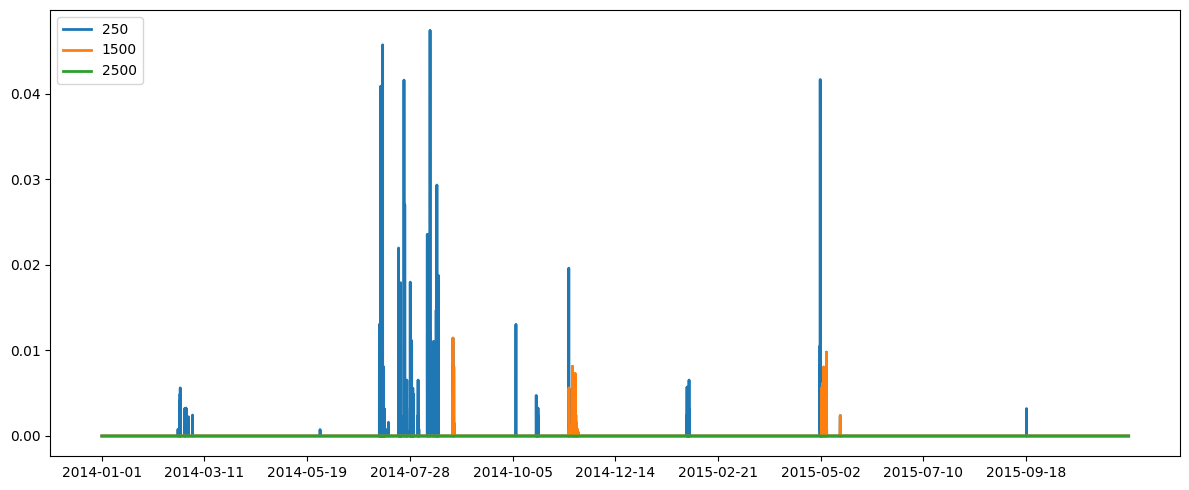

In [66]:
# Plot the results

start = 0
end = 100000

# Set the 'Date' column as the x-axis
plt.figure(figsize=(12, 5))

        ### Qirr

#plt.plot(df_model_10yr['time'][start:end], df_model_flush100['Qirr'][start:end]*2000, label='Qirr' ,linewidth=2)

        ### V_flush

#plt.plot(df_model_10yr['time'][start:end], df_model_10yr['Vflush'][start:end], label='Vflush_2', linewidth=1)
#plt.plot(df_model_10yr['time'][start:end], df_model_flush10['Vflush'][start:end], label='Vflush_10', linewidth=1)
#plt.plot(df_model_10yr['time'][start:end], df_model_flush100['Vflush'][start:end], label='Vflush_100', linewidth=1)

        ### V_tank

#plt.plot(df_model_10yr['time'][start:end], df_model_flush100['v_tank'][start:end], label='100 Flushes per hour',linewidth=2)
plt.plot(df_250['time'][start:end], df_250['Qtank'][start:end],label='250', linewidth=2)
plt.plot(df_1500['time'][start:end], df_1500['Qtank'][start:end],label='1500', linewidth=2)
plt.plot(df_2500['time'][start:end], df_2500['Qtank'][start:end],label='2500', linewidth=2)
#plt.plot(df_25000['time'][start:end], df_25000['v_tank'][start:end],label='25000', linewidth=2)

#plt.plot(df_model_10yr['time'][start:end], df_model_10yr['v_tank'][start:end],label='2 Flushes per hour', linewidth=2)

        ### Q_tank
#plt.plot(df_model_10yr.index[start:end], df_model_10yr['Qtank'][start:end], label='Qtank_2', linewidth=2)
#plt.plot(df_model_10yr.index[start:end], df_model_flush10['Qtank'][start:end], label='Qtank_10', linewidth=2)
#plt.plot(df_model_10yr.index[start:end], df_model_flush100['Qtank'][start:end], label='Qtank_100', linewidth=2)

#plt.plot(df_model_10yr['time'],df_precp_10yr['precp'],linewidth = 2)
#plt.plot(df_pluvio_2.index,df_pluvio_2['precp'],label = 'precp2',linewidth = 1)
#plt.plot(df_model_10yr['time'][start:end],df_model_10yr['soil_mois'][start:end],label = 'soil moisture',linewidth = 1)
#plt.plot(df_model_10yr['time'], df_model_10yr['Qout'], linewidth=2)

# Customize the plot
#plt.xlabel('Date',fontsize = 20)
#plt.ylabel('Qout [m$^3$]',fontsize = 20)
#plt.title('Time Series for 1 year')
plt.xticks(df_250['time'][start:end:10000], rotation=0,fontsize = 10)  # Show every 1000th date
plt.legend(loc="upper left")

plt.tight_layout()
#plt.savefig("presentation/flush.png", dpi=300, bbox_inches="tight")  # Save as a PNG file

# Show the plot
plt.show()

In [31]:
np.mean(df_2500['Qtank'])

0.00027020406712162707

In [29]:
df_precp_10yr

,stn,time,precp,precp2
0,LSN,2014-01-01 00:00:00,0.0,0.000000
1,LSN,2014-01-01 00:10:00,0.0,0.000000
2,LSN,2014-01-01 00:20:00,0.1,0.000000
3,LSN,2014-01-01 00:30:00,0.1,0.000285
4,LSN,2014-01-01 00:40:00,0.1,0.000914
...,...,...,...,...
525883,LSN,2023-12-31 23:10:00,0.0,0.000000
525884,LSN,2023-12-31 23:20:00,0.0,0.000000
525885,LSN,2023-12-31 23:30:00,0.0,0.000000
525886,LSN,2023-12-31 23:40:00,0.0,0.000000


In [30]:
np.sum(df_precp_10yr['precp'])

11203.599999999999

In [31]:
np.sum(df_precp_10yr['precp2'])

7120.513923591633

In [ ]:
# Output the plot inline in the notebook
output_notebook()
# Convert DataFrame to ColumnDataSource for Bokeh
source1 = ColumnDataSource(df_st_base)
# source2 = ColumnDataSource(df_test)

# Create a figure with a datetime x-axis
p = figure(x_axis_type="datetime", title="Measured", x_axis_label='Date', y_axis_label='Water discharge (L^3/s)', width=1000)
p.y_range = Range1d(0, np.max(df_st_base['precp']+0.05))
p.line('time', 'precp', source=source1, legend_label='Rainfall', color="cyan")
# Plot the first column as a line
p.extra_y_ranges = {
    "discharge": Range1d(start=0, end=np.max(df_st_base['discharge_de_shift']) + 0.05),
    "h": Range1d(start=0, end=np.max(df_st_base['Qout']) + 0.05)  # Define "h"
}
p.add_layout(LinearAxis(y_range_name="h", axis_label='Water level (mm)'), 'right')
p.line('time', 'discharge_de_shift', source=source1, legend_label="Discharge", line_width=3, color="blue", y_range_name="discharge")
p.line('time', 'Qout', source=source1, legend_label="Modeled", line_width=3, color="green")
p.line('time', 'Stormwater', source=source1, legend_label="Hydrique", line_width=3, color="red")

# p.line('Date', 'denoised_shift', source=source1, legend_label="Water level", line_width=1, color="green", y_range_name="h")

p.legend.location="top_left"
# Show the plot
show(p)

In [ ]:
lagging = 0
k_st = 60
rt2s = 0.5

df_st_base = model_st(df_swstch, k=k_st, lag=lagging, frac_rt2s=rt2s)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_st_base['time'], df_st_base['precp'], label="Rainfall")
# ax.bar(df_st_base['time'], df_st_base['precp'], width=0.05, alpha = 0.6, label='Rainfall')
ax.legend()
ax.set_ylabel("Rainfall intensity (mm/10min)")

# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=8))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2 = ax.twinx()
ax2.plot(df_st_base['time'], df_st_base['Qout'], label="Modeled discharge", color='red', linewidth=0.8)
ax2.legend(bbox_to_anchor=(0.21, 0.9))
ax2.set_ylabel("Water discharge ($m^3/s$)")
ax.set_title("Modeled Discharge of Swisstech01 Subcatchment")

In [ ]:
start1 = "2024-07-20 22:00:00"
end1 = "2024-07-21 14:00:00" #actually 10:00

In [ ]:
print(df_st_base.head())  # Shows the first 5 rows
k_st

In [ ]:
# Create the figure and axis 
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Soil Moisture on the primary y-axis
ax1.plot(df_st_base['time'], df_st_base['soil_mois'], label="Soil Moisture", color="blue", linewidth=2)
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("Soil Moisture", fontsize=14, color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a secondary y-axis for Qout
ax2 = ax1.twinx()
ax2.plot(df_st_base['time'], df_st_base['Qout'], label="Qout (Discharge)", color="red", linewidth=2)
ax2.set_ylabel("Discharge (m³/s)", fontsize=14, color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Add a title and legends
plt.title("Soil Moisture and Discharge Over Time", fontsize=16)
ax1.legend(loc="upper left", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)

#Save the file
output_file = "soil_moisture_and_discharge.png"  # Define the output file name and format
plt.tight_layout()
plt.savefig(output_file, dpi=300)  # Save with 300 DPI for high quality
print(f"Figure saved as {output_file}")

# Show the plot
plt.tight_layout()
plt.show()

### 4.2 Sensitivity analysis

#### 4.2.1 K

In [ ]:
df_testk = df_swstch.copy()
range_k = np.linspace(20, 120, 6, dtype=int)
for k_test in range_k:
    columnname = "Qout_k"+str(k_test)
    df = model_st(df_swstch, k=k_test)
    df_testk[columnname] = df['Qout']
    

In [ ]:
df_testk1 = slicing(df_testk, start1, end1, "time", date_index=False)
fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:00 \n %b %d"))
ax.bar(df_testk1['time'], df_testk1['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
ax.set_title("Sensitivity Analysis over Time Constant K")
ax.set_ylabel("Rainfall Intensity (mm/10min)")
ax.legend(loc="upper left")
ax2 = ax.twinx()
for k in range_k:
    columnname = "Qout_k"+str(k)
    ax2.plot(df_testk1['time'], df_testk1[columnname], label="K="+str(k))

ax2.legend(loc="upper right")
ax2.set_ylabel("Modeled Discharge ($m^3/s$)")



In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:00 \n %b %d"))
ax.bar(df_testk1['time'], df_testk1['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
# ax.set_title("Sensitivity Analysis over Time Constant K")
ax.set_ylabel("Rainfall intensity (mm/10min)")
ax.legend(loc="upper left")
ax2 = ax.twinx()
for k in range_k:
    columnname = "Qout_k"+str(k)
    ax2.plot(df_testk1['time'], df_testk1[columnname].cumsum()*300, label="K="+str(k))

ax2.legend(loc="lower right")
ax2.set_ylabel("Accumulated discharge ($m^3/s$)")


In [ ]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=True, figsize=(6,7))

for i, ax in enumerate(axs.flat):
    k = range_k[i]
    col = "Qout_k"+str(k)
    ax.plot(df_testk1['time'], df_testk1[col].cumsum()*300, label="K="+str(k))
    ax.legend(loc='lower right')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%b %d"))

plt.tight_layout()
fig.suptitle("Accumulated Discharge", x=0.5, y=1.02)
fig.supylabel("Accumulated discharge ($m^3/s$)", x=-0.02, y=0.5)


#### Soil

In [ ]:
df_tests = df_swstch.copy()

for t in soil:
    columnname = "Qout_"+t
    df = model_st(df_swstch, k=60, soiltype=t)
    df_tests[columnname] = df['Qout']

    colname_qs = "Qs_"+t
    df_tests[colname_qs] = df['Qs']

    colname_sm = "moisture_"+t
    df_tests[colname_sm] = df['soil_mois']
    

In [ ]:
df_tests1 = slicing(df_tests, start1, end1, "time", date_index=False)
fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:00 \n %b %d"))
ax.bar(df_tests['time'], df_tests['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
ax.set_title("Sensitivity Analysis over Time Constant K")
ax.set_ylabel("Rainfall Intensity (mm/10min)")
ax.legend(loc="upper left")
ax2 = ax.twinx()
for t in soil:
    columnname = "Qs_"+t
    ax2.plot(df_tests['time'], df_tests[columnname], label=t)

ax2.legend(loc="upper right")
ax2.set_ylabel("Modeled Discharge ($m^3/s$)")

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
# ax.bar(df_tests['time'], df_tests['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
ax.set_title("Soil Overflow Qs of Variant Soil Texture")
# ax.set_ylabel("Rainfall Intensity (mm/10min)")


for t in soil:
    columnname = "Qs_"+t
    ax.plot(df_tests['time'], df_tests[columnname], label=t)
ax.legend(loc="upper left")

ax.set_ylabel("Soil overflow ($m^3/s$)")

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
# ax.bar(df_tests['time'], df_tests['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
ax.set_title("Soil Moisture Traces of Variant Soil Texture")
# ax.set_ylabel("Rainfall Intensity (mm/10min)")


for t in soil:
    columnname = "moisture_"+t
    ax.plot(df_tests['time'], df_tests[columnname], label=t)
    # ax.hlines(y=soil[t]['sfc'], xmin=df_tests['time'][0],xmax=df_tests['time'][9000])
ax.legend(loc="upper left")

ax.set_ylabel("Soil moisture")

In [ ]:
fig, axs = plt.subplots(5,1, sharex=True, sharey=True, figsize=(5,12))

for i, ax in enumerate(axs.flat):
    t = texture[i]
    col = "moisture_"+t
    ax.plot(df_tests['time'], df_tests[col], label=t)
    ax.hlines(y=[soil[t]['sh'], soil[t]['sw'], soil[t]['ss'],soil[t]['sfc']], xmin=df_tests['time'][0], xmax=df_tests['time'][9000])
    ax.legend(loc='upper left')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%b %d"))

plt.tight_layout()
fig.suptitle("Accumulated Discharge", x=0.5, y=1.02)
fig.supylabel("Accumulated discharge ($m^3/s$)", x=-0.02, y=0.5)

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
# ax.bar(df_testk1['time'], df_testk1['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
# ax.set_title("Sensitivity Analysis over Time Constant K")
# ax.set_ylabel("Rainfall intensity (mm/10min)")
# ax.legend(loc="upper left")
# ax2 = ax.twinx()
for t in texture:
    columnname = "Qout_"+t
    ax.plot(df_tests['time'], df_tests[columnname].cumsum()*300, label=t)

ax.legend(loc="upper left")
ax.set_ylabel("Accumulated discharge ($m^3/s$)")

In [ ]:
start5 = "2024-08-17 18:00:00"
end5 = "2024-08-19 02:00:00"
df_tests5 = slicing(df_tests, start5, end5, "time", date_index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.bar(df_tests5['time'], df_tests5['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
ax.set_title("Soil Overflow Qs of Variant Soil Texture")
# ax.set_ylabel("Rainfall Intensity (mm/10min)")

ax2 = ax.twinx()
for i,t in enumerate(soil):
    columnname = "Qs_"+t
    ax2.plot(df_tests5['time'], df_tests5[columnname], label=t, linewidth=4-0.8*i)
ax2.legend(loc="upper left")

ax.set_ylabel("Soil overflow ($m^3/s$)")

In [ ]:
list(soil.keys())[0]

In [ ]:
fig, axs = plt.subplots(5,1,figsize=(9,12), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    t = list(soil.keys())[i]
    columnname = "Qs_" + t
    ax.plot(df_tests5['time'], df_tests5[columnname], label="Qs")
    col_qout = "Qout_" + t

    ax.plot(df_tests5['time'], df_tests5[col_qout], label="Qout")
    ax.legend(loc="upper right")
    x_text_position = df_tests5['time'][9400]
    y_text_position = df_tests5[columnname].max() * 0.8  # 在最大值下方放置文本
    ax.text(x=x_text_position, y=y_text_position, s=t)
    # ax.text(x=0,y=0,s="sand")

fig.suptitle("Soil Overflow of Variant Soil Texture (Aug 17th-18th)", x=0.5, y=0.9)
fig.supylabel("Soil overflow Qs ($m^3/s$)",x=0.05)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:00\n%b %d'))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:00\n%b %d"))
ax.bar(df_tests5['time'], df_tests5['precp'], edgecolor='black', width=0.004, alpha = 0.2, label='Rainfall')
# ax.set_title("Sensitivity Analysis over Time Constant K")
ax.set_ylabel("Rainfall intensity (mm/10min)")
# ax.legend(loc="upper left")
ax2 = ax.twinx()
for t in texture:
    columnname = "Qout_"+t
    ax2.plot(df_tests5['time'], df_tests5[columnname].cumsum()*300, label=t, linewidth=1)

ax.legend(loc="upper left")
ax2.legend(loc="lower right")
ax2.set_ylabel("Accumulated discharge ($m^3/s$)")

In [ ]:
fig, axs = plt.subplots(3,1, sharex=True, sharey=True, figsize=(12,8))

# axs[0].plot(df_st_base['time'], df_st_base['precp'], label="Rainfall")
# ax.bar(df_st_base['time'], df_st_base['precp'], width=0.05, alpha = 0.6, label='Rainfall')
# ax.legend()
# ax.set_ylabel("Rainfall intensity (mm/10min)")
axs[0].plot(df_st_base['time'], df_st_base['discharge_de_shift'], label="Measured discharge", linewidth=0.8)
axs[1].plot(df_st_base['time'], df_st_base['Qout'], label="Modeled discharge", linewidth=0.8)
axs[2].plot(df_st_base['time'], df_st_base['Stormwater'], label="Hydrique model", linewidth=0.8)
# ax2.legend(bbox_to_anchor=(0.21, 0.9))
# ax2.set_ylabel("Water discharge ($m^3/s$)")
# ax.set_title("Modeled Discharge of Swisstech01 Subcatchment")
for i, ax in enumerate(axs.flat):
    ax.legend(loc="upper left")
fig.suptitle("Measured and Modeled Runoff", y=0.92)
fig.supylabel("Water discharge ($m^3/s$)", x=0.07)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

In [ ]:
area_tt = sum(omega0_st)+sum(omegas_st)+sum(omegat_st)

In [ ]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9,7))

axs[0,0].plot(df_st_base['time'], df_st_base['precp'].cumsum()*0.5*area_tt/1000, label="Rainfall")
axs[0,1].plot(df_st_base['time'], df_st_base['discharge_de_shift'].cumsum()*300, label="Measured runoff")
axs[1,0].plot(df_st_base['time'], df_st_base['Stormwater'].cumsum()*300, label="Hydrique runoff")
axs[1,1].plot(df_st_base['time'], df_st_base['Qout'].cumsum()*300, label="Modeled runoff")

for ax in axs.flat:
    ax.legend(loc="upper left")

fig.suptitle("Accumulated Discharge", y=0.92)
fig.supylabel("Water volume ($m^3$)", x=0.04)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_st_base['time'], df_st_base['precp'], linewidth=1, color="black", label="Rainfall")
ax.set_ylabel("Rainfall intensity (mm/10min)")
ax.legend(bbox_to_anchor=(0.12,0.75))
ax2 = ax.twinx()
ax2.plot(df_st_base['time'], df_st_base['precp'].cumsum()*0.5*area_tt/1000, label="Accumulated rainfall")
ax2.plot(df_st_base['time'], df_st_base['discharge_de_shift'].cumsum()*300, label="Measured runoff")
ax2.plot(df_st_base['time'], df_st_base['Stormwater'].cumsum()*300, label="Hydrique runoff")
ax2.plot(df_st_base['time'], df_st_base['Qout'].cumsum()*300, label="Modeled runoff")
ax2.set_ylabel("Water volume ($m^3$)")

ax2.legend(loc="upper left")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.set_title("Accumulated Discharge")

In [ ]:
source1 = ColumnDataSource(df_st_base)
# Create a new plot with a title and axis labels
p = figure(title="Swisstech", x_axis_type="datetime",x_axis_label='Date', y_axis_label='Rainfall intensity (mm/10min)', width =1000)

# Add the first line (linked to the default primary y-axis)
# p.line('time', 'precp',source=source1, legend_label="Rainfall", line_color="blue", line_width=0.5)
p.vbar(x='time', top='precp', width=1000, source=source1, color='navy', alpha=0.6, legend_label="Rainfall")

# Add a second y-axis to the plot
p.extra_y_ranges = {"test": Range1d(start=0, end=np.max(df_st_base['Qout']+0.05))}
p.add_layout(LinearAxis(y_range_name="test", axis_label='Water Discharge (m^3/s)'), 'right')

# Add the second line (linked to the secondary y-axis)
p.line('time', 'Qout', source=source1, legend_label="Modeled", line_color="green", line_width=2, y_range_name="test")
p.line('time', 'discharge_de_shift', source=source1, legend_label="Measured", line_color="red", line_width=2, y_range_name="test")
# p.line('time', 'Stormwater', source=source1, legend_label="Stormwater", line_color="purple", line_width=2, y_range_name="test")
# p.line('time', 'Simulation', source=source1, legend_label="Simulation", line_color="black", line_width=2, y_range_name="test")
# p.line('time', 'Qs', source=source1, legend_label="Qs", line_color="pink", line_width=2, y_range_name="test")
p.legend.location="top_left"
# Show the plot
show(p)


In [ ]:
lagging = 0
k_st = 100
rt2s = 0.5

df_st_base = model_st(df_swstch, k=k_st, lag=lagging, frac_rt2s=rt2s)
# df_st_base

fig, ax = plt.subplots(2,2, sharex=True, sharey=True)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# plt.xticks(rotation=45)

area_tt = sum(omega0_st)+sum(omegat_st)+sum(omegas_st)
area_imp = sum(omega0_st)+rt2s*sum(omegat_st)

ax[0,0].plot(df_st_base['time'], df_st_base['precp'].cumsum()*0.5*area_tt/1000, alpha = 0.2, label='Rainfall')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Accumulated rainfall [$m^3$]')
# ax.set_xticks(overlap['time'][::6])  
# ax.set_xticklabels(overlap['time'][::6].dt.strftime("%H:%M"), rotation=45, ha='right')

ax[0,1].plot(df_st_base['time'], df_st_base['Stormwater'].cumsum()*300, label='Hydrique')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('Accumulated Discharge $[m^3]$')

ax[1,1].plot(df_st_base['time'], df_st_base['Qout'].cumsum()*300, label='Modeled', color='#6D8E5D')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('Accumulated Q$_{out} [m^3]$')

# ax[0, 1].get_shared_y_axes().join(ax[0, 1], ax[1, 1])

# ax[1,0].plot(df_swstch['time'], simulated_st[6], label='Qs_accu', color='#D9AB42')
# ax[1,0].legend(loc='upper left')
# ax[1,0].set_ylabel('Accumulated Q$_{s} [m^3]$')

ax[1,0].plot(df_st_base['time'], df_st_base['discharge_de_shift'].cumsum()*300, label='Discharge', color='#D9AB42')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('Accumulated discharge$[m^3]$')

V_h = max(df_st_base['Stormwater'].cumsum()*300)
V_m = max(df_st_base['Qout'].cumsum()*300)
V_p = max(df_st_base['precp'].cumsum()*0.5*area_tt/1000)
V_d = max(df_st_base['discharge_de_shift'].cumsum()*300)

# fig.text(0, -0.15,f"Rainfall to modeled discharge = {V_p/V_m}\n\
# Discharge from water level/ modeled discharge = {V_d/V_m}\n\
# nash-sutcliffe: {nash_sutcliffe(df_st_base['discharge_de_shift'], df_st_base['Qout'])}\n\
# lagging: {0*10/60}h \n\
# k = {k_st} /day")

plt.tight_layout()
plt.show()

In [ ]:
lastweek_start = '2024-08-17 18:00:00'
lastweek_end = '2024-08-18 12:00:00'
lastweek = slicing(test1, lastweek_start, lastweek_end)

In [ ]:
fig, ax = plt.subplots()
ax.plot(lastweek.index, lastweek['rre150z0'], label="Rainfall")
ax.legend()
ax.set_ylabel("Rainfall intensity (mm/10min)")
ax2 = ax.twinx()
ax2.plot(lastweek.index, lastweek['Qout'], label="Modeled", color='red')
ax2.plot(lastweek.index, lastweek['Qs'], label="Qs", color='green')
ax2.legend()
ax2.set_ylabel("Water discharge ($m^3/s$)")
# ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### 4.3 First change

In [ ]:
infiltration = 6.7*10**(-6)  #[m/s]
Qmax = infiltration*sum(omegas_st)
Qmax

In [ ]:
def model_st3(df, k=100, frac_rt2s=0.5, frac_rt2tk=1, Z_root=70, E_max=0.5, E_w=0.0625, soiltype="loamy sand",\
        omegas=sum(omegas_st), omega0=sum(omega0_st), omegat=sum(omegat_st), hmax=0.1, heavy=infiltration, lag=0, resolution=5, qp='linear', qp_value=0, kp=0):
    
    rain = df['precp'].fillna(0)
    rain_lag = rain if lag==0 else np.concatenate((np.zeros(lag), rain[:-lag]))


     # Soil parameters
    Ks = soil[soiltype]['Ks']
    n = soil[soiltype]['n']
    beta = soil[soiltype]['beta']
    s_h = soil[soiltype]['sh']
    s_w = soil[soiltype]['sw']
    s_s = soil[soiltype]['ss']
    s_fc = soil[soiltype]['sfc']
    # Initialization
    y_result = np.zeros((df.shape[0], 3))
    y0 = [0, s_s, 0]
    y_result[0] = y0
    dydt = np.zeros(3)
    Qs = np.zeros(df.shape[0])
    Qout = np.zeros(df.shape[0])
    Qt = np.zeros(df.shape[0])
    Qr = np.zeros(df.shape[0])
    Qp = np.zeros(df.shape[0])
    Qp2s = np.zeros(df.shape[0])
    Qpmax = heavy*omegas
    Vtmax = hmax*frac_rt2tk*omegat

    for i in range(df.shape[0]-1):
        p = rain_lag[i]/(1000*10*60) #convert from mm/10min to m/s

        #============ Qs ===============#
        if y_result[i,1] >= s_fc:
            Qs[i] = p * (omegas + (1-frac_rt2tk)*frac_rt2s*omegat)
        elif p>heavy:
            Qs[i] = (p-heavy)*(omegas + (1-frac_rt2tk)*frac_rt2s*omegat)
        else:
            Qs[i] = 0

        #============ Qr ===============#
        V_runoff = y_result[i,0]*omega0 # Water volume of V0 reservoir at time point i
        Qr[i] = k * V_runoff / 86400 # Turn k [/day] to k [/s]

        #============ Qt =================#
        Vt = frac_rt2tk*omegat*y_result[i, 2]
        Qt[i] = p*frac_rt2tk*omegat if (Vt>Vtmax) else 0

        #============ Qp =================#
        if p==0:
            if qp=="linear" and y_result[i,2]>=0:
                Qp[i] = qp_value
            else:
                Qp[i] = min(kp*y_result[i, 2]*frac_rt2tk*omegat, Qpmax)
                # Qp[i] = min(kp*y_result[i, 2], Qpmax)

        #============ Qout =================#
        Qout[i] = Qt[i] + Qr[i]
        #==============Road reservoir==========#
        dydt[0] = (p*(omega0+(1-frac_rt2tk)*(1-frac_rt2s)*omegat) + Qs[i] - Qr[i])/omega0
        
        y_result[i+1, 0] = y_result[i, 0] + dydt[0]*60*resolution # tspan resolution is 10 min = 600s
        if y_result[i+1, 0] < 0:
            y_result[i+1, 0] = 0
        #==============Soil reservoir==========#
        Z_soil = n*Z_root
        Qp2s[i] = Qp[i] if y_result[i, 1]<s_fc else 0
        # dydt[1] = p*(1+(1-frac_rt2tk)*frac_rt2s*omegat/omegas)/ (Z_soil / 100) + Qp2s[i]/(Z_soil/100) \
        #          - rho(y_result[i, 1],n, Z_root, E_max, E_w, beta, s_h, s_w, s_s, s_fc, Ks) / 86400
        
        dydt[1] = p*(1+(1-frac_rt2tk)*frac_rt2s*omegat/omegas)/ (Z_soil / 100) + \
                 - rho(y_result[i, 1],n, Z_root, E_max, E_w, beta, s_h, s_w, s_s, s_fc, Ks) / 86400

        y_result[i+1, 1] = y_result[i, 1] + dydt[1]*60*resolution
        if y_result[i+1, 1] >= s_fc:
            y_result[i+1, 1] = s_fc
        #==============Tank reservoir==========#
        if frac_rt2tk != 0:
            dydt[2] = p - (Qt[i]+Qp2s[i])/(frac_rt2tk*omegat)

            y_result[i+1, 2] = y_result[i, 2] + dydt[2]*60*resolution
            # hmax = Vtmax/(frac_rt2tk*omegat)
            if y_result[i+1, 2] >= hmax:
                y_result[i+1, 2] = hmax
        else:
            dydt[2] = 0
            y_result[i, 2] = 0

        
    df_return = df.copy()
    df_return['Qout'] = Qout
    df_return['Qs'] = Qs
    df_return['Qt'] = Qt
    df_return['Qr'] = Qr
    df_return['Qp'] = Qp
    df_return['soil_mois'] = y_result[:,1]
    df_return['h_tank'] = y_result[:,2]

    return df_return

In [ ]:
sum(omegat_st)

In [ ]:
sum(omegat_st)/(sum(omega0_st)+sum(omegat_st)+sum(omegas_st))

In [ ]:
lagging = 0
k_st = 60
rt2s = 0.5
rt2tk = 1
df_st3 = model_st3(df_swstch, k=k_st, lag=lagging, frac_rt2s=rt2s, hmax=0.1, frac_rt2tk=rt2tk, qp="", qp_value=0.0001, kp=0.01)
# df_st_base

fig, ax = plt.subplots(2,2, sharex=True, sharey=True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# plt.xticks(rotation=45)
    
area_tt = sum(omega0_st)+sum(omegat_st)+sum(omegas_st)
area_imp = sum(omega0_st)+rt2s*sum(omegat_st)

ax[0,0].plot(df_st3['time'], df_st3['precp'].cumsum()*0.5*area_tt/1000, alpha = 0.2, label='Rainfall')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Accumulated rainfall [$m^3$]')
# ax.set_xticks(overlap['time'][::6])  
# ax.set_xticklabels(overlap['time'][::6].dt.strftime("%H:%M"), rotation=45, ha='right')

ax[0,1].plot(df_st3['time'], df_st3['Stormwater'].cumsum()*300, label='Hydrique')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('Accumulated Discharge $[m^3]$')

ax[1,1].plot(df_st3['time'], df_st3['Qout'].cumsum()*300, label='Modeled', color='#6D8E5D')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('Accumulated Q$_{out} [m^3]$')

# ax[0, 1].get_shared_y_axes().join(ax[0, 1], ax[1, 1])

# ax[1,0].plot(df_swstch['time'], simulated_st[6], label='Qs_accu', color='#D9AB42')
# ax[1,0].legend(loc='upper left')
# ax[1,0].set_ylabel('Accumulated Q$_{s} [m^3]$')

ax[1,0].plot(df_st3['time'], df_st3['discharge_de_shift'].cumsum()*300, label='Discharge', color='#D9AB42')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('Accumulated Q$_{s} [m^3]$')

V_h = max(df_st3['Stormwater'].cumsum()*300)
V_m = max(df_st3['Qout'].cumsum()*300)
V_p = max(df_st3['precp'].cumsum()*0.5*area_tt/1000)
V_d = max(df_st3['discharge_de_shift'].cumsum()*300)

fig.text(0, -0.15,f"Modeled discharge to rainfall = {V_m/V_p}\n\
Modeled/Measured = {V_m/V_d}\n\
nash-sutcliffe: {nash_sutcliffe(df_st3['discharge_de_shift'], df_st3['Qout'])}\n\
lagging: {lagging*5/60}h \n\
k = {k_st} /day")

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import LinearAxis, Range1d
source1 = ColumnDataSource(df_st3)
# Create a new plot with a title and axis labels
tool=("box_zoom", "wheel_zoom", "save", "reset", "pan","hover")
p = figure(title="Swisstech", x_axis_type="datetime",x_axis_label='Date', y_axis_label='Rainfall intensity (mm/10min)', width =1000, tools=tool)

hover = HoverTool(
    tooltips=[
        ("Date", "@time{%b %d %H:%M}"),  # 正确的日期格式
        ("Rainfall", "@precp mm"),
        ("Qout", "@Qout m^3/s")
    ],
    formatters={
        '@time': 'datetime'  # 告诉 Bokeh 解释为 datetime
    },
    mode='mouse'
)

# 将 HoverTool 添加到图形中
p.add_tools(hover)



# Add the first line (linked to the default primary y-axis)
# p.line('time', 'precp',source=source1, legend_label="Rainfall", line_color="blue", line_width=0.5)
p.vbar(x='time', top='precp', width=0.5, source=source1, color='navy', alpha=0.6)

# Add a second y-axis to the plot
p.extra_y_ranges = {"test": Range1d(start=0, end=np.max(df_st3['Qout']+0.05)), \
    "height": Range1d(start=0, end=np.max(df_st3['h_tank'])+0.05)}
# p.add_layout(LinearAxis(y_range_name="test", axis_label='Water Discharge (m^3/s)'), 'right')
p.add_layout(LinearAxis(y_range_name="test", axis_label='discharge'), 'right')

# Add the second line (linked to the secondary y-axis)
p.line('time', 'Qout', source=source1, legend_label="Modeled", line_color="green", line_width=2, y_range_name="test")
# p.line('time', 'discharge_de_shift', source=source1, legend_label="Measured", line_color="red", line_width=2, y_range_name="test")
# p.line('time', 'Stormwater', source=source1, legend_label="Stormwater", line_color="purple", line_width=2, y_range_name="test")
# p.line('time', 'Simulation', source=source1, legend_label="Simulation", line_color="black", line_width=2, y_range_name="test")
p.line('time', 'Qs', source=source1, legend_label="Qs", line_color="pink", line_width=2, y_range_name="test")
# p.line('time', 'h_tank', source=source1, legend_label="h_tank", line_color="violet", line_width=2, y_range_name="height")
p.line('time', 'Qt', source=source1, legend_label="Qt", line_color="red", line_width=2, y_range_name="test")
p.legend.location="top_left"
# Show the plot
show(p)


In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import LinearAxis, Range1d
source1 = ColumnDataSource(df_st3)
# Create a new plot with a title and axis labels
tool=("box_zoom", "wheel_zoom", "save", "reset", "pan","hover")
p = figure(title="Swisstech", x_axis_type="datetime",x_axis_label='Date', y_axis_label='Rainfall intensity (mm/10min)', width =1000, tools=tool, tooltips="@time{%b %d %H:%M}, @y")

hover = HoverTool(
    tooltips=[
        ("Date", "@time{%b %d %H:%M}"),  # 正确的日期格式
        ("Rainfall", "@precp mm"),
        ("Qout", "@Qout m^3/s")
    ],
    formatters={
        '@time': 'datetime'  # 告诉 Bokeh 解释为 datetime
    },
    mode='mouse'
)

# 将 HoverTool 添加到图形中
p.add_tools(hover)



# Add the first line (linked to the default primary y-axis)
# p.line('time', 'precp',source=source1, legend_label="Rainfall", line_color="blue", line_width=0.5)
p.vbar(x='time', top='precp', width=0.5, source=source1, color='navy', alpha=0.6)

# Add a second y-axis to the plot
p.extra_y_ranges = {"test": Range1d(start=0, end=np.max(df_st3['Qout']+0.05)), \
    "height": Range1d(start=np.min(df_st3['h_tank']), end=np.max(df_st3['h_tank'])+0.05)}
p.add_layout(LinearAxis(y_range_name="test", axis_label='Water Discharge (m^3/s)'), 'right')
# p.add_layout(LinearAxis(y_range_name="height", axis_label='h_tank'), 'right')

# Add the second line (linked to the secondary y-axis)
p.line('time', 'Qout', source=source1, legend_label="Modeled", line_color="green", line_width=2, y_range_name="test")
# p.line('time', 'discharge_de_shift', source=source1, legend_label="Measured", line_color="red", line_width=2, y_range_name="test")
# p.line('time', 'Stormwater', source=source1, legend_label="Stormwater", line_color="purple", line_width=2, y_range_name="test")
# p.line('time', 'Simulation', source=source1, legend_label="Simulation", line_color="black", line_width=2, y_range_name="test")
# p.line('time', 'Qs', source=source1, legend_label="Qs", line_color="pink", line_width=2, y_range_name="test")
# p.line('time', 'h_tank', source=source1, legend_label="h_tank", line_color="violet", line_width=2, y_range_name="height")
p.line('time', 'Qs', source=source1, legend_label="Qt", line_color="red", line_width=2, y_range_name="test")
p.legend.location="top_left"
# Show the plot
show(p)

p1: constant use (linear) boundary limit
p2: proportional to the volume (kh)

Why not discharge during rianfall?

In [ ]:
np.max(df_st3['h_tank'])

In [ ]:
sum(np.max(df_st3['h_tank'])*omegat_st)

In [ ]:
df_st3_accum = df_st3.copy()
df_st3_accum['precp_accu'] = df_st3['precp'].cumsum()*0.5*area_tt/1000
df_st3_accum['Qout_accu'] = df_st3['Qout'].cumsum()*300
df_st3_accum['discharge_accu'] = df_st3['discharge_de_shift'].cumsum()*300

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import LinearAxis, Range1d
source1 = ColumnDataSource(df_st3_accum)
# Create a new plot with a title and axis labels
p = figure(title="Swisstech_cumulative", x_axis_type="datetime",x_axis_label='Date', y_axis_label='Accumulated volume ($m^3$)', width =1000)

# Add the first line (linked to the default primary y-axis)
# p.line('time', 'precp',source=source1, legend_label="Rainfall", line_color="blue", line_width=0.5)
p.line('time', 'precp_accu', source=source1, legend_label="Rain", line_color="violet", line_width=2)
p.line('time', 'Qout_accu', source=source1, legend_label="Modeled", line_color="brown", line_width=2)
p.line('time', 'discharge_accu', source=source1, legend_label="Measured", line_color="black", line_width=2)
# p.line('time', 'Qt', source=source1, legend_label="Qs", line_color="pink", line_width=2, y_range_name="test")
p.legend.location="top_left"
show(p)

In [ ]:
startp1 = "2024-08-17 20:00:00"
endp1 = "2024-08-17 22:00:00"
startd1 = "2024-08-17 22:00:00"
endd1 = "2024-08-18 00:00:00"
startp2 = "2024-08-18 01:00:00"
endp2 = "2024-08-18 02:30:00"
startd2 = "2024-08-18 02:00:00"
endd2 = "2024-08-18 05:30:00"
startp3 = "2024-08-18 04:00:00"
endp3 = "2024-08-18 06:00:00"
startd3 = "2024-08-18 05:30:00"
endd3 = "2024-08-18 8:00:00"

In [ ]:
precp1 =  df_swstch.loc[(df_swstch['time'] >= startp1) & (df_swstch['time'] <= endp1), 'precp'].sum()*0.5*area_tt/1000
precp2 =  df_swstch.loc[(df_swstch['time'] >= startp2) & (df_swstch['time'] <= endp2), 'precp'].sum()*0.5*area_tt/1000
precp3 =  df_swstch.loc[(df_swstch['time'] >= startp3) & (df_swstch['time'] <= endp3), 'precp'].sum()*0.5*area_tt/1000
discharge1 = df_swstch.loc[(df_swstch['time'] >= startd1) & (df_swstch['time'] <= endd1), 'discharge_de_shift'].sum()*300
discharge2 = df_swstch.loc[(df_swstch['time'] >= startd2) & (df_swstch['time'] <= endd2), 'discharge_de_shift'].sum()*300
discharge3 = df_swstch.loc[(df_swstch['time'] >= startd3) & (df_swstch['time'] <= endd3), 'discharge_de_shift'].sum()*300

In [ ]:
x = ['event1', 'event2', 'event3']  # x 轴的标签 (0, 1, 2, 3, 4)
y1 = [precp1, precp2, precp3]  # 第一个数组
y2 = [discharge1, discharge2, discharge3]  # 第二个数组

# 设置条形宽度
bar_width = 0.35  # 条形的宽度
x_indices = np.arange(len(x))  # x 轴的索引

# 绘制第一个条形图
plt.bar(x_indices, y1, width=bar_width, label='Rainfall', color='#C2CEDC')

# 绘制第二个条形图，并将其向右偏移
plt.bar(x_indices + bar_width, y2, width=bar_width, label='Discharge', color='#979771')

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('Rainfall and discharge volume comparison')
# plt.xlabel('X Axis')
plt.ylabel('Volume ($m^3$)')

# 设置x轴的刻度
plt.xticks(x_indices + bar_width / 2, x)

# 显示图表
plt.show()


# 10yr

In [ ]:
df_precp_10yr = pd.read_csv("D:/OneDrive - epfl.ch/Master_thesis/Scripts/precp_10yr/order_124645_data.txt", delimiter=";")
df_precp_10yr

In [ ]:
df_precp_10yr['time'] = pd.to_datetime(df_precp_10yr['time'], format="%Y%m%d%H%M")
df_precp_10yr

In [ ]:
df_precp_10yr.rename(columns={"rre150z0": "precp"}, inplace=True)


In [ ]:
df_precp_10yr['precp'] = df_precp_10yr['precp'].replace("-", 0)
df_precp_10yr

In [ ]:
df_precp_10yr['precp'] = pd.to_numeric(df_precp_10yr['precp'])

In [ ]:
df_precp_10yr

In [ ]:
df_precp_10yr = dataresample(df_precp_10yr, "time", "5T")
df_precp_10yr.head()

In [ ]:
df_precp_10yr.to_pickle("df_precp_10yr.pkl")

In [ ]:
df_precp_10yr

In [ ]:
df_st_10yr = model_st3(df_precp_10yr, qp="", kp=0.01/10000)

In [ ]:
sum(omegat_st)

## First run

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_st_10yr['time'], df_st_10yr['precp'], label='Rainfall')
ax2 = ax.twinx()
ax2.plot(df_st_10yr['time'], df_st_10yr['h_tank'], label='h_tank', color='red')

In [ ]:
df_st_10yr[df_st_10yr['h_tank'] == 0.1]

In [ ]:
df_st_10yr[df_st_10yr['precp']!=0].shape[0]

In [ ]:
13286/76745

In [ ]:
df

In [ ]:
# rt2tk_range = np.linspace(0.1,1,3)
hmax_range = np.linspace(0.001,0.5,10)
kp_range = np.linspace(0.01,0.1,10)
fig, ax = plt.subplots(figsize=(12,10))

for k_p in kp_range:
    p_fail = []
    for h in hmax_range:
        # vtmax= rt2tk*sum(omegat_st)*hmax
        df = model_st3(df_precp_10yr, frac_rt2tk=1,hmax=h, qp="", kp=k_p/86400)
        time_fail = df[df['h_tank']==h].shape[0]
        time_rain = df[df['precp']!=0].shape[0]
        p_fail.append(time_fail/time_rain)

    p_fail = np.array(p_fail, dtype=float)  # 转换为 float 类型
    p_fail[p_fail == 0] = np.nan  # 将 0 替换为 NaN
    ax.plot(hmax_range, p_fail, label=f"kp={k_p:.2f}", marker='o')
    ax.hlines(y=0.05, xmin=np.min(hmax_range), xmax=np.max(hmax_range), linestyles='dashed', color='black')
    ax.legend()
    ax.set_xlabel("h_max (m)")
    ax.set_ylabel("Failure rate")


In [ ]:
def count_value_segments(data, value):
    # count = 0
    in_segment = False
    lengths = []
    length = 0

    for x in data:
        if x == value:
            if not in_segment:
                in_segment = True
                length = 1
            else:
                length += 1
        else:
            if in_segment:
                lengths.append(length)
                in_segment=False

    if in_segment:
        lengths.append(length)

    return lengths

In [ ]:
limit_times = count_value_segments(df_st_10yr['h_tank'], 0.1)


In [ ]:
limit_times = np.array(limit_times)
limit_times = limit_times*5

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_kde(data):
    # data = np.array(data)
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data, shade=True)
    plt.vlines(np.mean(data), ymin=0, ymax=0.005, label='mean', color='purple')
    plt.vlines(np.median(data), ymin=0, ymax=0.005, label='median')
    plt.title('Data Distribution - KDE')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


plot_kde(limit_times)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdf(data):
    # 对数据进行排序并计算累积概率
    sorted_data = np.sort(data)
    cumulative_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    plt.figure(figsize=(8, 6))
    plt.step(sorted_data, cumulative_prob, where="post")
    plt.title('Cumulative Distribution Function (CDF)')
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.show()

# 示例使用
data = [1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 9, 10]
plot_cdf(limit_times)


In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(data, bins=10):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=bins, edgecolor='black')
    plt.title('Data Distribution - Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# 示例使用
data = [1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 9, 10]
plot_histogram(limit_times, bins=100)


In [ ]:
df_st_10yr[df_st_10yr['h_tank']==0.1].shape[0]*5/692

## runoff_coefficient versus hmax, divided by frac

In [ ]:
rt2tk_range = np.linspace(0.1,1,5)
hmax_range = np.linspace(0,0.1,5)
fig, ax = plt.subplots()

for rt2tk in rt2tk_range:
    p_fail = []
    rc = []
    for h in hmax_range:
        # vtmax= rt2tk*sum(omegat_st)*hmax
        df = model_st3(df_precp_10yr, frac_rt2tk=rt2tk,hmax=h, qp="", kp=0.001)
        # time_fail = df[df['h_tank']==h].shape[0]
        # p_fail.append(time_fail/df.shape[0])
        rain_total = np.max(df['precp'].cumsum()*0.5*area_tt/1000)
        runoff_total = np.max(df['Qout'].cumsum()*300)
        rc.append(runoff_total/rain_total)

    # p_fail = np.array(p_fail, dtype=float)  # 转换为 float 类型
    # p_fail[p_fail == 0] = np.nan  # 将 0 替换为 NaN
    ax.scatter(hmax_range, rc, label="frac="+str(rt2tk))

In [ ]:
rc

In [ ]:
source1 = ColumnDataSource(df_st_10yr)
# Create a new plot with a title and axis labels
p = figure(title="Swisstech", x_axis_type="datetime",x_axis_label='Date', y_axis_label='Rainfall intensity (mm/10min)', width =1000)

# Add the first line (linked to the default primary y-axis)
# p.line('time', 'precp',source=source1, legend_label="Rainfall", line_color="blue", line_width=0.5)
p.vbar(x='time', top='precp', width=0.5, source=source1, color='navy', alpha=0.6)

# Add a second y-axis to the plot
p.extra_y_ranges = {"test": Range1d(start=0, end=np.max(df_st_base['discharge_de_shift']+0.05))}
p.add_layout(LinearAxis(y_range_name="test", axis_label='Water Discharge (m^3/s)'), 'right')

# Add the second line (linked to the secondary y-axis)
p.line('time', 'Qout', source=source1, legend_label="Modeled", line_color="green", line_width=2, y_range_name="test")
p.line('time', 'discharge_de_shift', source=source1, legend_label="Measured", line_color="red", line_width=2, y_range_name="test")
p.line('time', 'Stormwater', source=source1, legend_label="Stormwater", line_color="purple", line_width=2, y_range_name="test")
# p.line('time', 'Simulation', source=source1, legend_label="Simulation", line_color="black", line_width=2, y_range_name="test")
# p.line('time', 'Qs', source=source1, legend_label="Qs", line_color="pink", line_width=2, y_range_name="test")
p.legend.location="top_left"
# Show the plot
show(p)

# Discuss and check

## Rainfall + 3 models